In [ ]:
import pandas as pd

# Caminho do arquivo Excel
caminho_arquivo = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'

# Ler a aba "Planilha1"
df = pd.read_excel(caminho_arquivo, sheet_name='Planilha1')

# Mostrar as primeiras linhas para conferir
print(df.head())


         Data                Parametro        Valor
0  31/07/2008     Nitrogênio Amoniacal  28,20000000
1  31/07/2008                       OD   0,07000000
2  31/07/2008  Sólido Dissolvido Total          414
3  31/07/2008            Fósforo Total   2,57000000
4  31/07/2008   Chuvas nas últimas 24h            0


In [ ]:
import pandas as pd

# Caminho do arquivo
caminho_arquivo = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'

# Ler a aba
df = pd.read_excel(caminho_arquivo, sheet_name='Planilha1')

# Converter coluna Data para datetime (ajustando formato dd/mm/yyyy)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Filtrar dados entre 2010 e 2025
df_filtrado = df[(df['Data'].dt.year >= 2010) & (df['Data'].dt.year <= 2025)]

# Contar quantos dados para cada parâmetro nesse período
contagem = df_filtrado['Parametro'].value_counts()

print(contagem)


Parametro
OD                         84
pH                         84
Condutividade              84
Chuvas nas últimas 24h     83
Nitrogênio Amoniacal       82
Fósforo Total              82
Sólido Dissolvido Total    81
Name: count, dtype: int64


In [ ]:
# -*- coding: utf-8 -*-
# TABELA ESTATÍSTICA POR PARÂMETRO (para colar no chat)
# Dados longos: colunas ['Data','Parametro','Valor']
# Recorte: 2019 até o último dado

import numpy as np
import pandas as pd

# ===== CONFIG =====
CAMINHO_ARQUIVO = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'
ABA        = 'Planilha1'
COL_DATA   = 'Data'
COL_PARAM  = 'Parametro'
COL_VALOR  = 'Valor'
ANO_INICIO = 2019
# ==================

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 220)
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

def to_numeric_robusto(s: pd.Series) -> pd.Series:
    s2 = pd.to_numeric(s, errors='coerce')
    if s2.isna().mean() > 0.2:
        s2 = pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')
    return s2

def qtile(s: pd.Series, p: float):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.percentile(s, p)) if len(s) else np.nan

def safe_min(s): 
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.min(s)) if len(s) else np.nan

def safe_max(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.max(s)) if len(s) else np.nan

def safe_mean(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.mean(s)) if len(s) else np.nan

def safe_std(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.std(s, ddof=1)) if len(s) > 1 else np.nan

# ===== Leitura e recorte =====
df = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=ABA)
df = df.rename(columns={COL_DATA: 'Data', COL_PARAM: 'Parametro', COL_VALOR: 'Valor'})
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Data']).copy()
df['Ano'] = df['Data'].dt.year
df = df[df['Ano'] >= ANO_INICIO].copy()

# valor numérico robusto
df['Valor_num'] = to_numeric_robusto(df['Valor'])

# considera somente parâmetros que têm ao menos 1 valor numérico válido no recorte
params_validos = (df.groupby('Parametro')['Valor_num'].apply(lambda s: s.notna().any()))
params_validos = params_validos[params_validos].index.tolist()
dfv = df[df['Parametro'].isin(params_validos)].copy()

# ===== Estatística por parâmetro com named aggregations =====
g = dfv.groupby('Parametro')['Valor_num']

tabela = g.agg(
    N           = 'size',                                # total de linhas (inclui NaN)
    N_valid     = lambda s: int(s.notna().sum()),
    Missing     = lambda s: int(s.isna().sum()),
    Min         = safe_min,
    Q1          = lambda s: qtile(s, 25),
    Mediana     = lambda s: qtile(s, 50),
    Média       = safe_mean,
    Q3          = lambda s: qtile(s, 75),
    Máx         = safe_max,
    Desvio_Padrão = safe_std,
    p10         = lambda s: qtile(s, 10),
    p90         = lambda s: qtile(s, 90),
)

# colunas derivadas
tabela['Missing_%'] = np.where(tabela['N'] > 0, (tabela['Missing'] / tabela['N'] * 100).round(2), np.nan)
tabela['IQR'] = (tabela['Q3'] - tabela['Q1']).astype(float)

# ordena colunas na sequência desejada
cols_ordem = ['N','N_valid','Missing','Missing_%','Min','Q1','Mediana','Média','Q3','Máx','Desvio_Padrão','IQR','p10','p90']
tabela = tabela[cols_ordem].reset_index()

# ordena linhas por nome do parâmetro (opcional)
tabela = tabela.sort_values('Parametro').reset_index(drop=True)

print("\n=== TABELA ESTATÍSTICA (2019+ até o último dado) ===")
print(tabela.round(3).to_string(index=False))




=== TABELA ESTATÍSTICA (2019+ até o último dado) ===
              Parametro  N  N_valid  Missing  Missing_%     Min      Q1  Mediana   Média      Q3     Máx  Desvio_Padrão     IQR     p10     p90
 Chuvas nas últimas 24h 29       29        0      0.000   0.000   0.000    0.000   0.414   1.000   1.000          0.501   1.000   0.000   1.000
          Condutividade 30       30        0      0.000 236.000 457.000  596.000 572.267 693.250 810.000        158.975 236.250 335.200 753.000
          Fósforo Total 28       28        0      0.000   0.290   0.958    1.615   1.750   2.412   4.330          0.971   1.455   0.558   2.753
   Nitrogênio Amoniacal 28       28        0      0.000   3.630   9.242   16.500  15.862  21.975  29.900          7.339  12.733   5.720  24.660
                     OD 30       30        0      0.000   0.210   0.228    0.540   0.939   0.830   8.110          1.466   0.602   0.210   1.915
Sólido Dissolvido Total 28       28        0      0.000 140.000 229.500  288.000 2

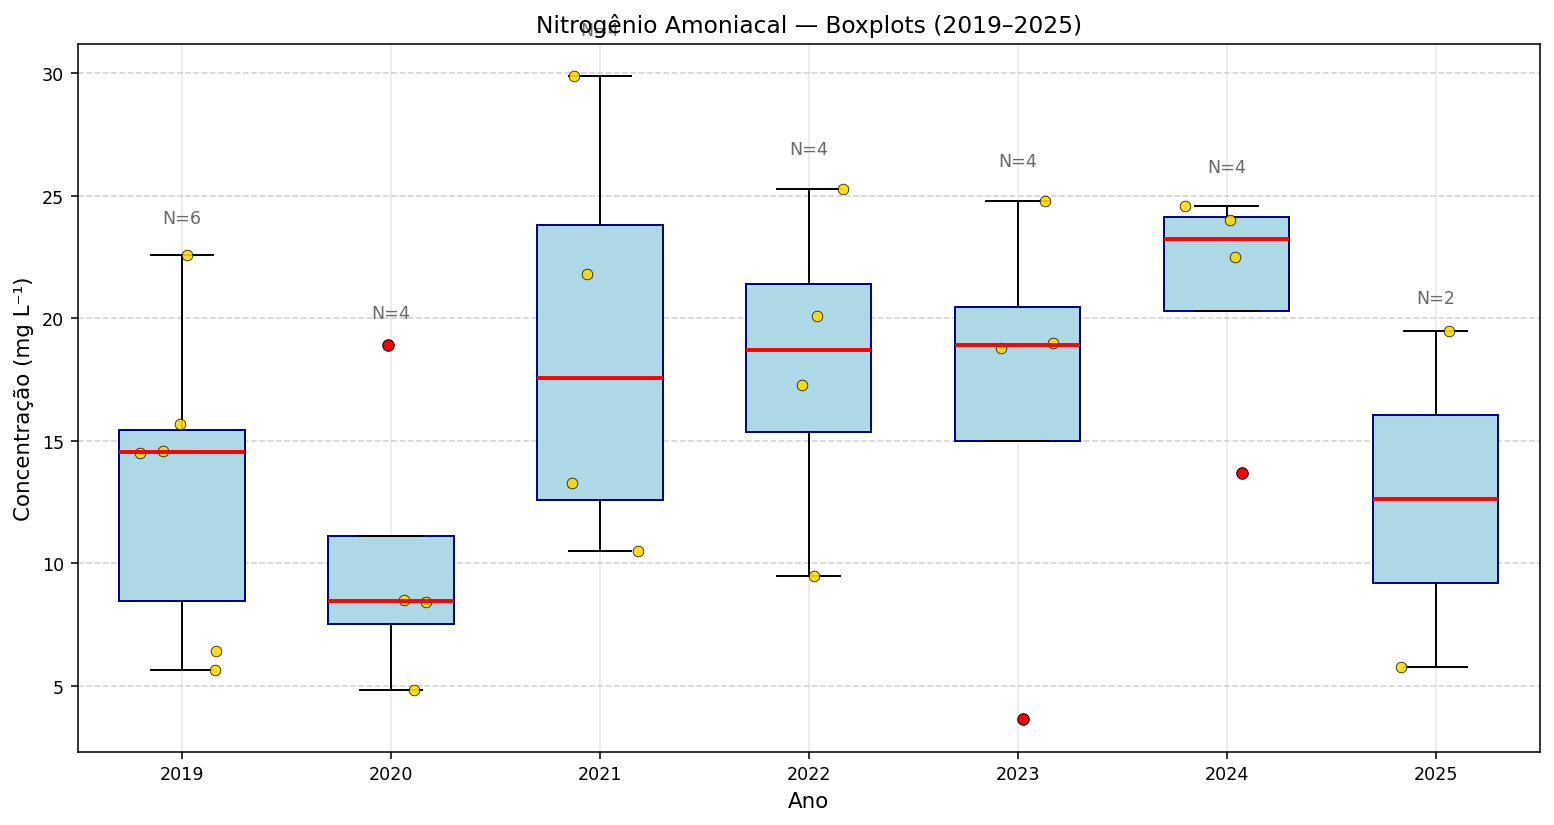

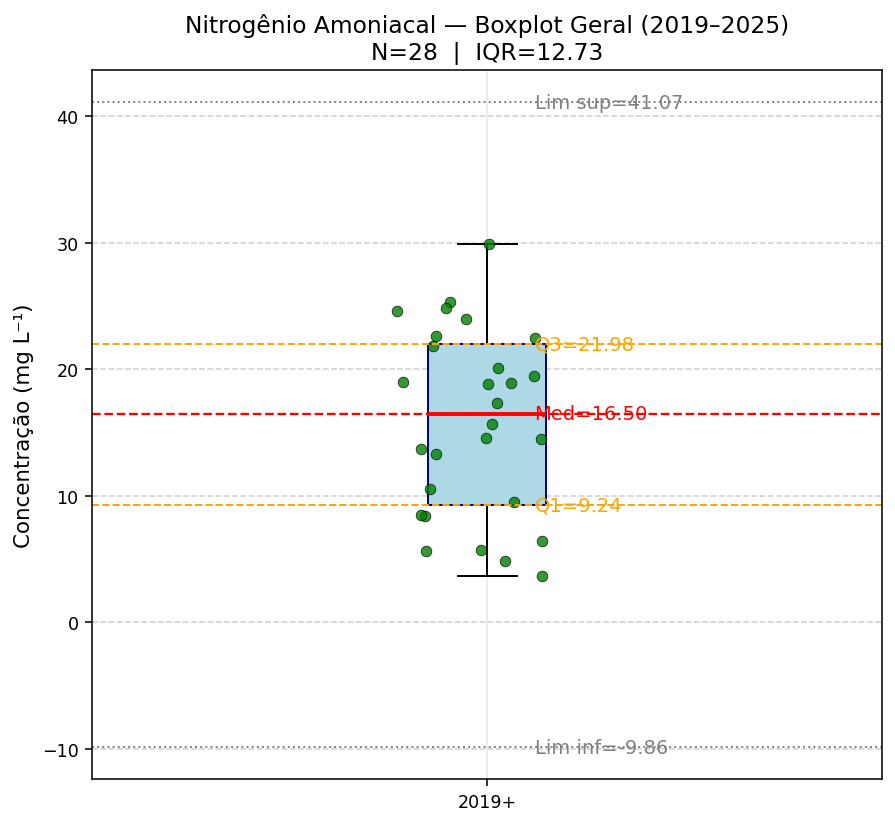


Resumo geral (2019+):
N=28, Min=3.63, Q1=9.24, Mediana=16.50, Q3=21.98, Max=29.90, IQR=12.73
Limites de Tukey: inferior=-9.86, superior=41.07
Outliers detectados: 0 (em vermelho)


In [ ]:
# -*- coding: utf-8 -*-
"""
Boxplots do Nitrogênio Amoniacal com frequência e destaque:
- Pontos verdes = valores dentro dos limites (normais)
- Pontos vermelhos = outliers (Tukey)
- Boxplots por ano e geral (2019+)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============== CONFIGURAÇÕES ==============
CAMINHO_ARQUIVO = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'
ABA         = 'Planilha1'
COL_DATA    = 'Data'
COL_PARAM   = 'Parametro'
COL_VALOR   = 'Valor'
PARAM_ALVO  = 'nitrogênio amoniacal'
ANO_INICIO  = 2019
# ===========================================

def to_num(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')

def tukey_limits(arr):
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return q1, q3, iqr, low, high

# ---------- Leitura e preparo ----------
df = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=ABA)
df[COL_DATA] = pd.to_datetime(df[COL_DATA], dayfirst=True, errors='coerce')
df = df.dropna(subset=[COL_DATA])
df = df[df[COL_DATA].dt.year >= ANO_INICIO].copy()

mask_alvo = df[COL_PARAM].astype(str).str.lower().str.contains(PARAM_ALVO)
df_nh4 = df.loc[mask_alvo, [COL_DATA, COL_VALOR]].copy()
df_nh4['Valor_num'] = to_num(df_nh4[COL_VALOR])
df_nh4 = df_nh4.dropna(subset=['Valor_num']).copy()
df_nh4['Ano'] = df_nh4[COL_DATA].dt.year

if df_nh4.empty:
    raise ValueError("Sem dados numéricos de Nitrogênio Amoniacal no recorte 2019+.")

# =================== FIGURA 1: por ANO ===================
anos = sorted(df_nh4['Ano'].unique().tolist())
data_by_year = [df_nh4.loc[df_nh4['Ano']==a, 'Valor_num'].values for a in anos]

plt.figure(figsize=(max(10, 1.6*len(anos)), 6))

bp = plt.boxplot(
    data_by_year,
    positions=np.arange(1, len(anos)+1),
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='lightblue', edgecolor='navy'),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
)

# pontos e outliers
for i, a in enumerate(anos, start=1):
    yvals = df_nh4.loc[df_nh4['Ano']==a, 'Valor_num'].values
    if len(yvals) == 0:
        continue

    q1, q3, iqr, low, high = tukey_limits(yvals)
    out_mask = (yvals < low) | (yvals > high)
    norm_mask = ~out_mask

    # pontos normais (amarelo)
    x_norm = np.random.uniform(low=i-0.22, high=i+0.22, size=norm_mask.sum())
    plt.scatter(x_norm, yvals[norm_mask], s=30, alpha=0.9, color='gold', edgecolors='black', linewidths=0.4, zorder=2)

    # pontos outliers (vermelho)
    if np.any(out_mask):
        x_out = np.random.uniform(low=i-0.22, high=i+0.22, size=out_mask.sum())
        plt.scatter(x_out, yvals[out_mask], s=35, color='red', edgecolors='black', linewidths=0.5, zorder=3)

    # rótulo N
    y_top = np.nanmax(yvals)
    plt.text(i, y_top*1.05 if y_top>0 else y_top+0.1, f'N={len(yvals)}', ha='center', va='bottom', fontsize=9, color='dimgray')

plt.title(f'Nitrogênio Amoniacal — Boxplots (2019–{max(anos)})')
plt.xlabel('Ano')
plt.ylabel('Concentração (mg L⁻¹)')
plt.xticks(ticks=np.arange(1, len(anos)+1), labels=anos, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# =================== FIGURA 2: GERAL ===================
vals = df_nh4['Valor_num'].values
q1, q3, iqr, low, high = tukey_limits(vals)
q2 = np.percentile(vals, 50)
out_mask = (vals < low) | (vals > high)
norm_mask = ~out_mask

plt.figure(figsize=(6.5, 6))
plt.boxplot(
    vals,
    vert=True,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='lightblue', edgecolor='navy'),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
)

# pontos normais (verde)
x0 = 1.0
x_norm = np.random.uniform(low=x0-0.12, high=x0+0.12, size=norm_mask.sum())
plt.scatter(x_norm, vals[norm_mask], s=30, alpha=0.8, color='green', edgecolors='black', linewidths=0.4, zorder=2)

# outliers (vermelho)
if np.any(out_mask):
    x_out = np.random.uniform(low=x0-0.12, high=x0+0.12, size=out_mask.sum())
    plt.scatter(x_out, vals[out_mask], s=35, color='red', edgecolors='black', linewidths=0.5, zorder=3)

# linhas de quartis e limites
plt.axhline(q1, color='orange', linestyle='--', linewidth=1)
plt.axhline(q2, color='red', linestyle='--', linewidth=1.2)
plt.axhline(q3, color='orange', linestyle='--', linewidth=1)
plt.axhline(low, color='gray', linestyle=':', linewidth=1)
plt.axhline(high, color='gray', linestyle=':', linewidth=1)

# anotações
plt.text(1.06, q1,   f'Q1={q1:.2f}',   va='center', color='orange')
plt.text(1.06, q2,   f'Med={q2:.2f}',  va='center', color='red')
plt.text(1.06, q3,   f'Q3={q3:.2f}',   va='center', color='orange')
plt.text(1.06, low,  f'Lim inf={low:.2f}', va='center', color='gray')
plt.text(1.06, high, f'Lim sup={high:.2f}',va='center', color='gray')

plt.title(f'Nitrogênio Amoniacal — Boxplot Geral (2019–{max(anos)})\nN={len(vals)}  |  IQR={iqr:.2f}')
plt.ylabel('Concentração (mg L⁻¹)')
plt.xticks([1], ['2019+'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ---------- Resumo ----------
print("\nResumo geral (2019+):")
print(f"N={len(vals)}, Min={np.min(vals):.2f}, Q1={q1:.2f}, Mediana={q2:.2f}, Q3={q3:.2f}, Max={np.max(vals):.2f}, IQR={iqr:.2f}")
print(f"Limites de Tukey: inferior={low:.2f}, superior={high:.2f}")
print(f"Outliers detectados: {out_mask.sum()} (em vermelho)")




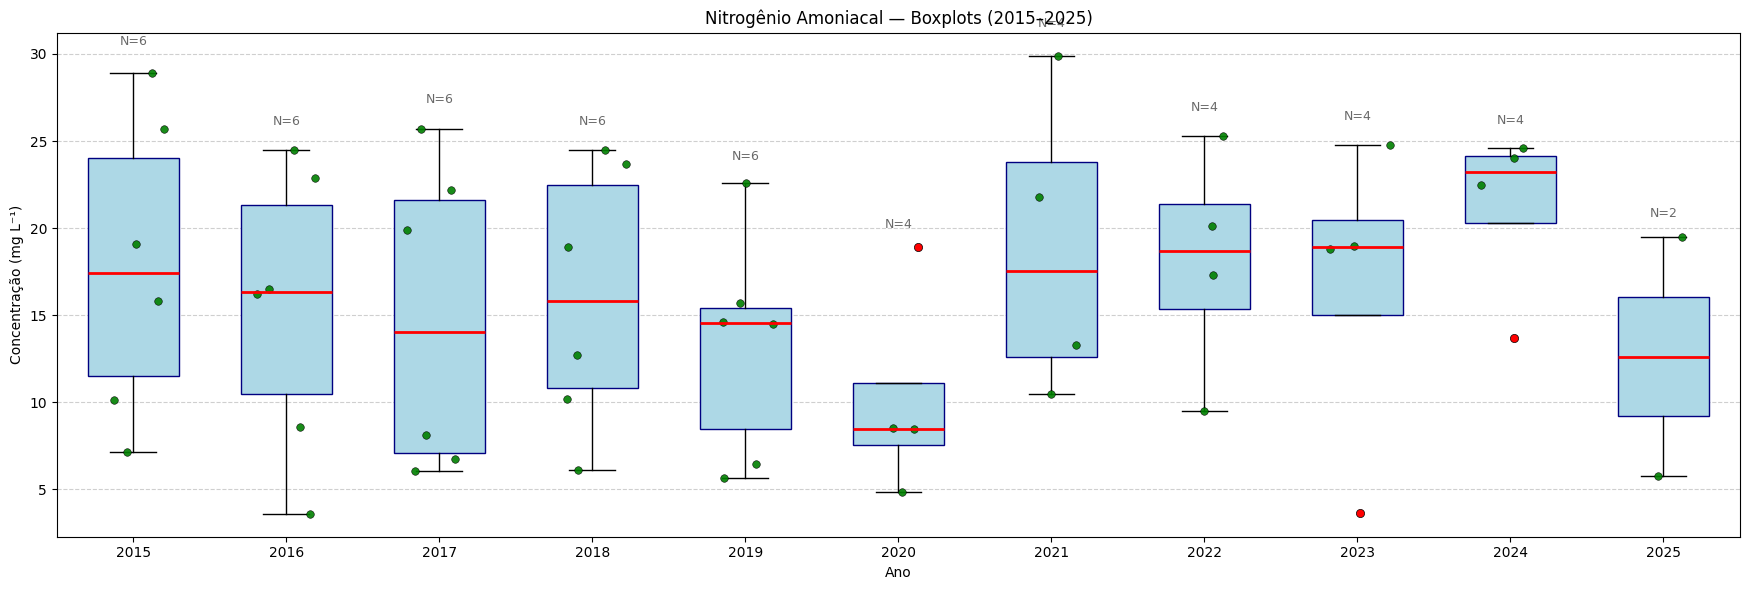

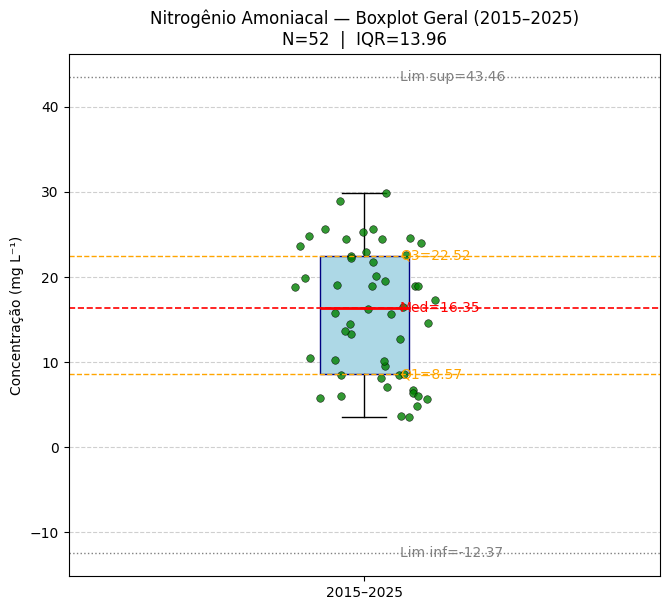


Resumo geral (2015–2025):
N=52, Min=3.59, Q1=8.57, Mediana=16.35, Q3=22.52, Max=29.90, IQR=13.96
Limites de Tukey: inferior=-12.37, superior=43.46
Outliers detectados: 0 (em vermelho)


In [ ]:
# -*- coding: utf-8 -*-
"""
Boxplots do Nitrogênio Amoniacal com frequência e destaque (2010–2025):
- Pontos verdes = valores dentro dos limites (normais)
- Pontos vermelhos = outliers (Tukey)
- Boxplots por ano e geral (intervalo definido por ANO_INICIO e ANO_FIM)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============== CONFIGURAÇÕES ==============
CAMINHO_ARQUIVO = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'
ABA         = 'Planilha1'
COL_DATA    = 'Data'
COL_PARAM   = 'Parametro'
COL_VALOR   = 'Valor'
PARAM_ALVO  = 'nitrogênio amoniacal'  # filtro case-insensitive por "contém"
ANO_INICIO  = 2015
ANO_FIM     = 2025
# ===========================================

def to_num(s):
    """Converte strings com vírgula decimal para float (coerce)."""
    return pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')

def tukey_limits(arr):
    """Calcula Q1, Q3, IQR e limites de Tukey."""
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return q1, q3, iqr, low, high

# ---------- Leitura e preparo ----------
df = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=ABA)

# Datas
df[COL_DATA] = pd.to_datetime(df[COL_DATA], dayfirst=True, errors='coerce')
df = df.dropna(subset=[COL_DATA])

# Janela de anos 2010–2025 (inclusive)
df = df[(df[COL_DATA].dt.year >= ANO_INICIO) & (df[COL_DATA].dt.year <= ANO_FIM)].copy()

# Parâmetro alvo
mask_alvo = df[COL_PARAM].astype(str).str.lower().str.contains(PARAM_ALVO)
df_nh4 = df.loc[mask_alvo, [COL_DATA, COL_VALOR]].copy()

# Valor numérico
df_nh4['Valor_num'] = to_num(df_nh4[COL_VALOR])
df_nh4 = df_nh4.dropna(subset=['Valor_num']).copy()
df_nh4['Ano'] = df_nh4[COL_DATA].dt.year

if df_nh4.empty:
    raise ValueError(f"Sem dados numéricos de Nitrogênio Amoniacal no recorte {ANO_INICIO}–{ANO_FIM}.")

# =================== FIGURA 1: por ANO ===================
anos = sorted(df_nh4['Ano'].unique().tolist())
data_by_year = [df_nh4.loc[df_nh4['Ano'] == a, 'Valor_num'].values for a in anos]

plt.figure(figsize=(max(10, 1.6*len(anos)), 6))

bp = plt.boxplot(
    data_by_year,
    positions=np.arange(1, len(anos)+1),
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='lightblue', edgecolor='navy'),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
)

# Pontos (verdes = normais) e outliers (vermelhos)
for i, a in enumerate(anos, start=1):
    yvals = df_nh4.loc[df_nh4['Ano'] == a, 'Valor_num'].values
    if len(yvals) == 0:
        continue

    q1, q3, iqr, low, high = tukey_limits(yvals)
    out_mask = (yvals < low) | (yvals > high)
    norm_mask = ~out_mask

    # Dispersão horizontal para evitar sobreposição
    jitter_norm = np.random.uniform(low=i-0.22, high=i+0.22, size=norm_mask.sum())
    jitter_out  = np.random.uniform(low=i-0.22, high=i+0.22, size=out_mask.sum())

    # Pontos normais (verde)
    if norm_mask.any():
        plt.scatter(jitter_norm, yvals[norm_mask], s=30, alpha=0.9,
                    color='green', edgecolors='black', linewidths=0.4, zorder=2)

    # Pontos outliers (vermelho)
    if out_mask.any():
        plt.scatter(jitter_out, yvals[out_mask], s=35,
                    color='red', edgecolors='black', linewidths=0.5, zorder=3)

    # Rótulo com N por ano
    y_top = np.nanmax(yvals)
    y_label = y_top*1.05 if y_top > 0 else y_top + (abs(y_top) * 0.05 + 0.1)
    plt.text(i, y_label, f'N={len(yvals)}', ha='center', va='bottom',
             fontsize=9, color='dimgray')

plt.title(f'Nitrogênio Amoniacal — Boxplots ({ANO_INICIO}–{ANO_FIM})')
plt.xlabel('Ano')
plt.ylabel('Concentração (mg L⁻¹)')
plt.xticks(ticks=np.arange(1, len(anos)+1), labels=anos, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# =================== FIGURA 2: GERAL ===================
vals = df_nh4['Valor_num'].values
q1, q3, iqr, low, high = tukey_limits(vals)
q2 = np.percentile(vals, 50)
out_mask = (vals < low) | (vals > high)
norm_mask = ~out_mask

plt.figure(figsize=(6.8, 6.2))
plt.boxplot(
    vals,
    vert=True,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='lightblue', edgecolor='navy'),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
)

# Pontos normais (verde) e outliers (vermelho)
x0 = 1.0
if norm_mask.any():
    x_norm = np.random.uniform(low=x0-0.12, high=x0+0.12, size=norm_mask.sum())
    plt.scatter(x_norm, vals[norm_mask], s=30, alpha=0.8,
                color='green', edgecolors='black', linewidths=0.4, zorder=2)

if out_mask.any():
    x_out = np.random.uniform(low=x0-0.12, high=x0+0.12, size=out_mask.sum())
    plt.scatter(x_out, vals[out_mask], s=35,
                color='red', edgecolors='black', linewidths=0.5, zorder=3)

# Linhas de quartis e limites
plt.axhline(q1,  color='orange', linestyle='--', linewidth=1)
plt.axhline(q2,  color='red',    linestyle='--', linewidth=1.2)
plt.axhline(q3,  color='orange', linestyle='--', linewidth=1)
plt.axhline(low, color='gray',   linestyle=':',  linewidth=1)
plt.axhline(high,color='gray',   linestyle=':',  linewidth=1)

# Anotações
plt.text(1.06, q1,   f'Q1={q1:.2f}',        va='center', color='orange')
plt.text(1.06, q2,   f'Med={q2:.2f}',       va='center', color='red')
plt.text(1.06, q3,   f'Q3={q3:.2f}',        va='center', color='orange')
plt.text(1.06, low,  f'Lim inf={low:.2f}',  va='center', color='gray')
plt.text(1.06, high, f'Lim sup={high:.2f}', va='center', color='gray')

plt.title(f'Nitrogênio Amoniacal — Boxplot Geral ({ANO_INICIO}–{ANO_FIM})'
          f'\nN={len(vals)}  |  IQR={iqr:.2f}')
plt.ylabel('Concentração (mg L⁻¹)')
plt.xticks([1], [f'{ANO_INICIO}–{ANO_FIM}'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ---------- Resumo ----------
print(f"\nResumo geral ({ANO_INICIO}–{ANO_FIM}):")
print(f"N={len(vals)}, Min={np.min(vals):.2f}, Q1={q1:.2f}, Mediana={q2:.2f}, "
      f"Q3={q3:.2f}, Max={np.max(vals):.2f}, IQR={iqr:.2f}")
print(f"Limites de Tukey: inferior={low:.2f}, superior={high:.2f}")
print(f"Outliers detectados: {out_mask.sum()} (em vermelho)")


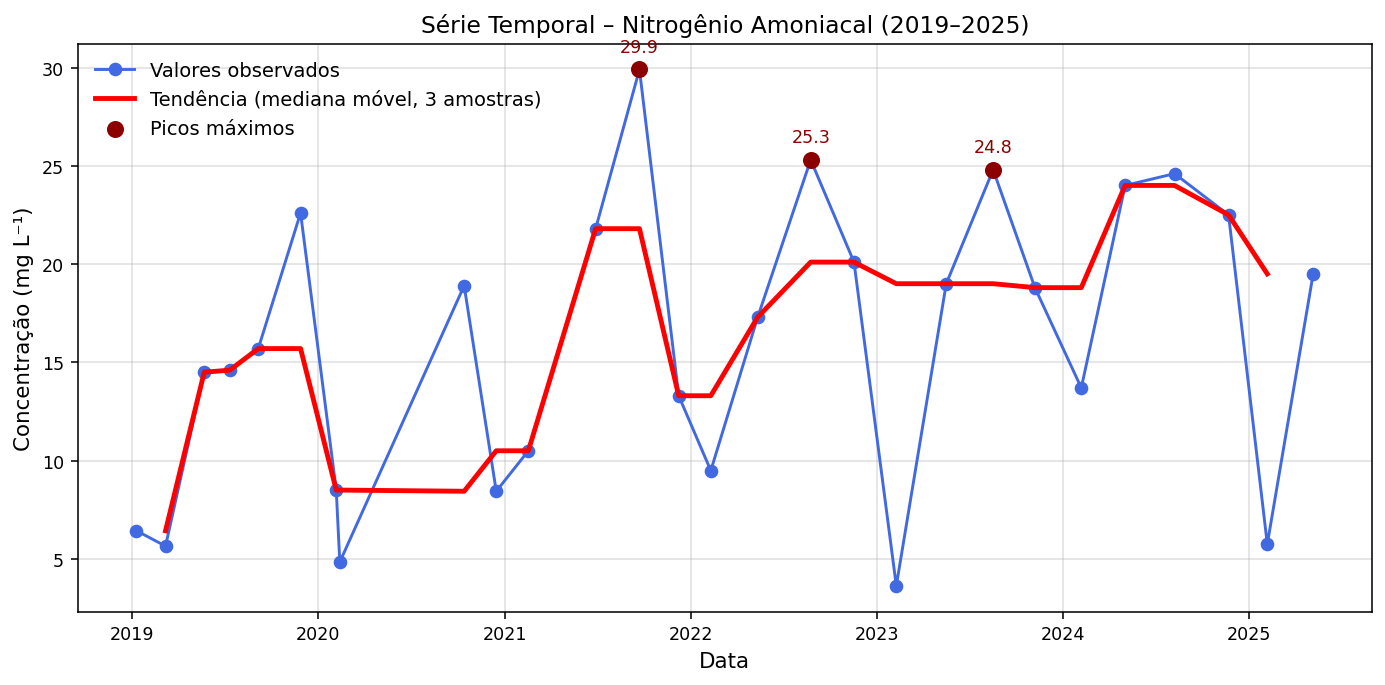

Período: 2019-01-09 a 2025-05-06
N=28, Média=15.86, Mediana=16.50, Máx=29.90
Top 3 picos:
Data
2021-09-22   29.900
2022-08-24   25.300
2023-08-17   24.800
Name: Valor_num, dtype: float64


In [ ]:
# -*- coding: utf-8 -*-
"""
Série temporal do Nitrogênio Amoniacal (2019–2025)
- Mostra evolução temporal, picos e tendência suavizada (mediana móvel)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============== CONFIGURAÇÕES ==============
CAMINHO_ARQUIVO = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'
ABA         = 'Planilha1'
COL_DATA    = 'Data'
COL_PARAM   = 'Parametro'
COL_VALOR   = 'Valor'
PARAM_ALVO  = 'nitrogênio amoniacal'
ANO_INICIO  = 2019
# ===========================================

def to_num(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')

# ---------- Leitura e preparo ----------
df = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=ABA)
df[COL_DATA] = pd.to_datetime(df[COL_DATA], dayfirst=True, errors='coerce')
df = df.dropna(subset=[COL_DATA])
df = df[df[COL_DATA].dt.year >= ANO_INICIO].copy()

mask_alvo = df[COL_PARAM].astype(str).str.lower().str.contains(PARAM_ALVO)
df_nh4 = df.loc[mask_alvo, [COL_DATA, COL_VALOR]].copy()
df_nh4['Valor_num'] = to_num(df_nh4[COL_VALOR])
df_nh4 = df_nh4.dropna(subset=['Valor_num']).sort_values(COL_DATA)

if df_nh4.empty:
    raise ValueError("Sem dados numéricos de Nitrogênio Amoniacal no recorte 2019+.")

# ---------- Série temporal ----------
serie = df_nh4.set_index(COL_DATA)['Valor_num']

# linha suavizada (mediana móvel de 3 amostras)
serie_smooth = serie.rolling(window=3, center=True).median()

# identifica picos (3 maiores)
top3 = serie.nlargest(3)

# ---------- Plot ----------
plt.figure(figsize=(10,5))
plt.plot(serie.index, serie.values, color='royalblue', marker='o', linewidth=1.5, label='Valores observados')
plt.plot(serie_smooth.index, serie_smooth.values, color='red', linewidth=2.5, label='Tendência (mediana móvel, 3 amostras)')

# destaca picos
plt.scatter(top3.index, top3.values, color='darkred', s=60, zorder=5, label='Picos máximos')
for i, (d, v) in enumerate(top3.items()):
    plt.text(d, v+0.7, f'{v:.1f}', ha='center', va='bottom', fontsize=9, color='darkred')

plt.title('Série Temporal – Nitrogênio Amoniacal (2019–2025)', fontsize=12)
plt.xlabel('Data')
plt.ylabel('Concentração (mg L⁻¹)')
plt.grid(alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---------- Resumo textual ----------
print(f"Período: {serie.index.min().date()} a {serie.index.max().date()}")
print(f"N={len(serie)}, Média={serie.mean():.2f}, Mediana={serie.median():.2f}, Máx={serie.max():.2f}")
print("Top 3 picos:")
print(top3)


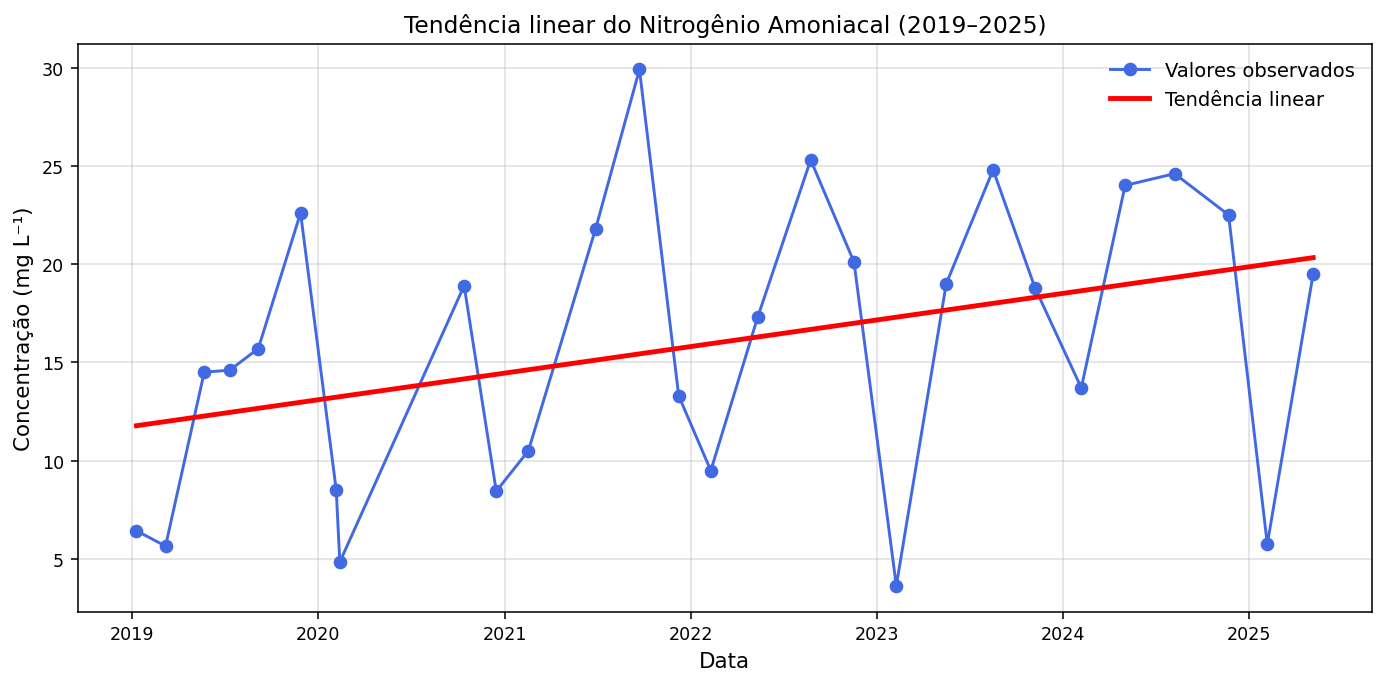

Inclinação da tendência: 0.0037 mg/L por dia


In [27]:
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

# converte data para números (regressão usa valores contínuos)
X = mdates.date2num(df_nh4['Data']).reshape(-1,1)
y = df_nh4['Valor_num'].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

plt.figure(figsize=(10,5))
plt.plot(df_nh4['Data'], y, marker='o', color='royalblue', linewidth=1.5, label='Valores observados')
plt.plot(df_nh4['Data'], y_pred, color='red', linewidth=2.5, label='Tendência linear')
plt.title('Tendência linear do Nitrogênio Amoniacal (2019–2025)')
plt.xlabel('Data')
plt.ylabel('Concentração (mg L⁻¹)')
plt.grid(alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# inclina da tendência:
coef = reg.coef_[0]
print(f"Inclinação da tendência: {coef:.4f} mg/L por dia")


Período: 2010-01-07 a 2025-05-06
N=82, média=15.01, mediana=14.55


C:\Users\gustavo.nunes\AppData\Local\Temp\ipykernel_16508\1852648443.py:106: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(m, m + pd.offsets.MonthEnd(1),


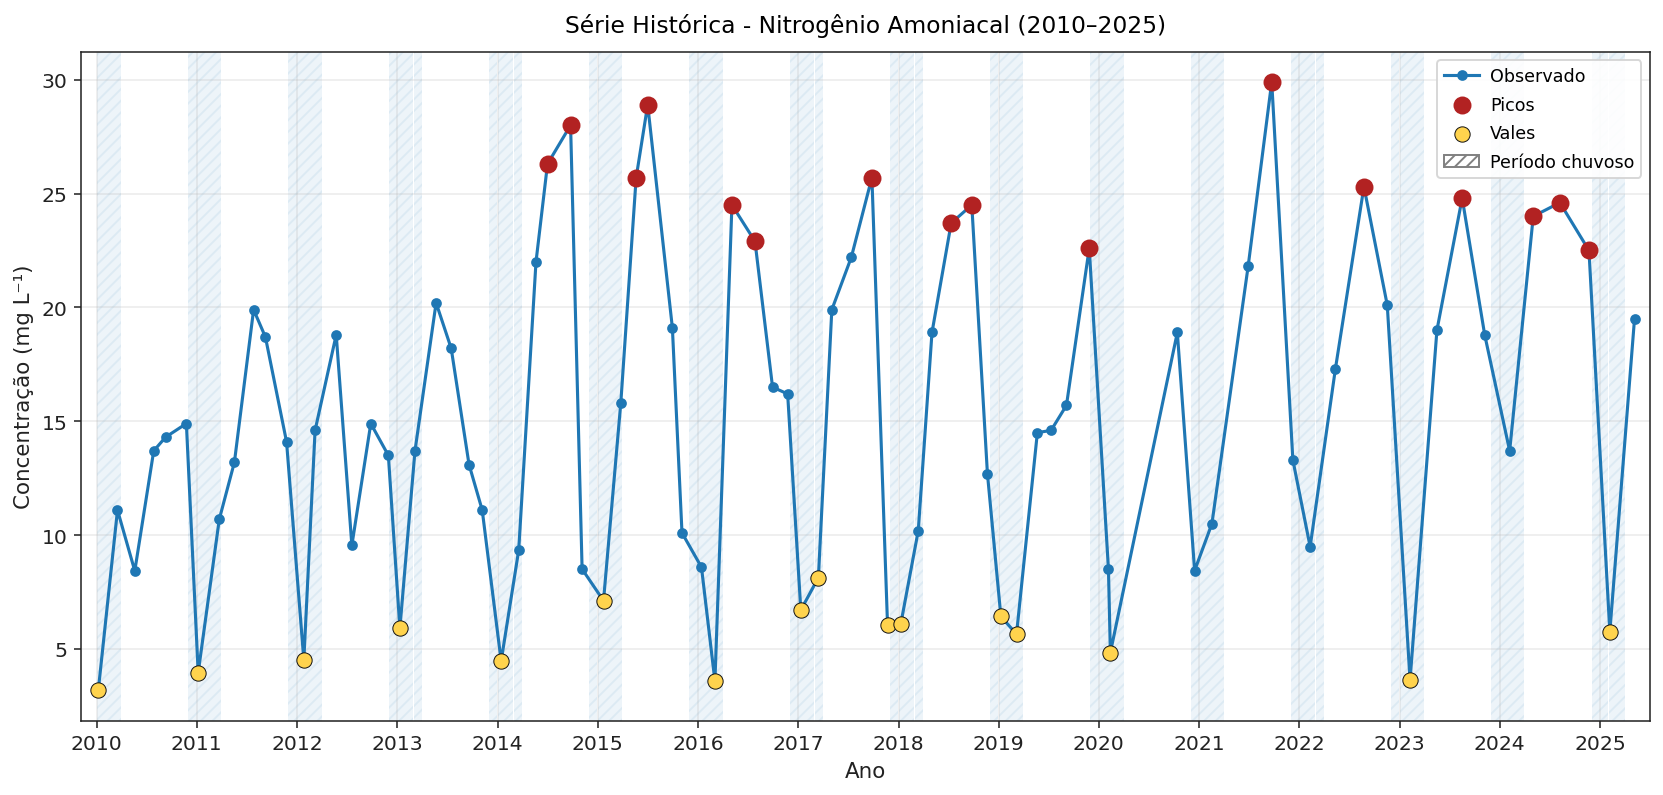

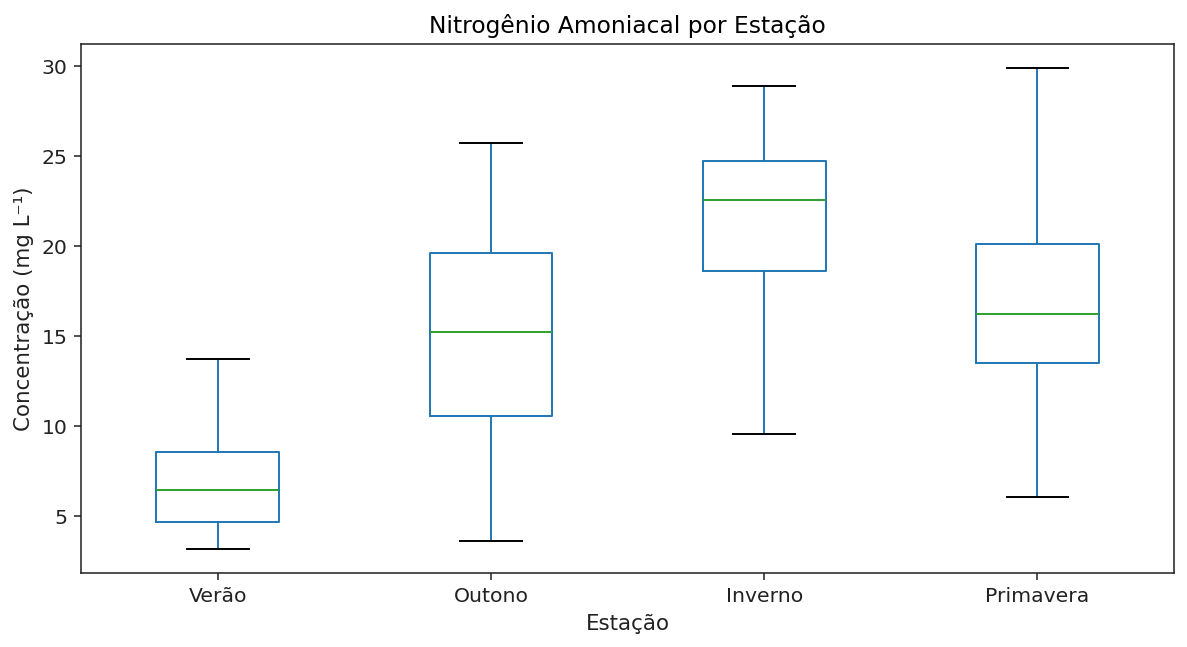

C:\Users\gustavo.nunes\AppData\Local\Temp\ipykernel_16508\1852648443.py:165: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos = [g['Valor_num'].values for _, g in tmp.groupby('Estacao')]


Kruskal–Wallis (entre estações): H=37.15, p=0.0000


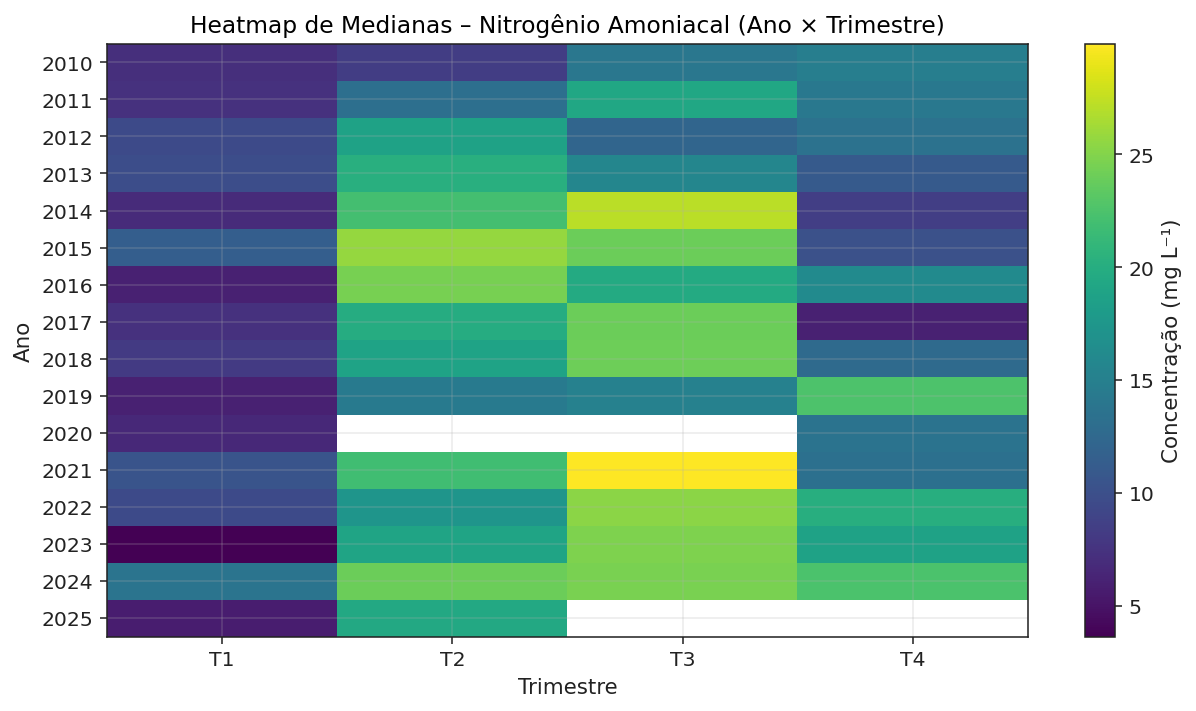

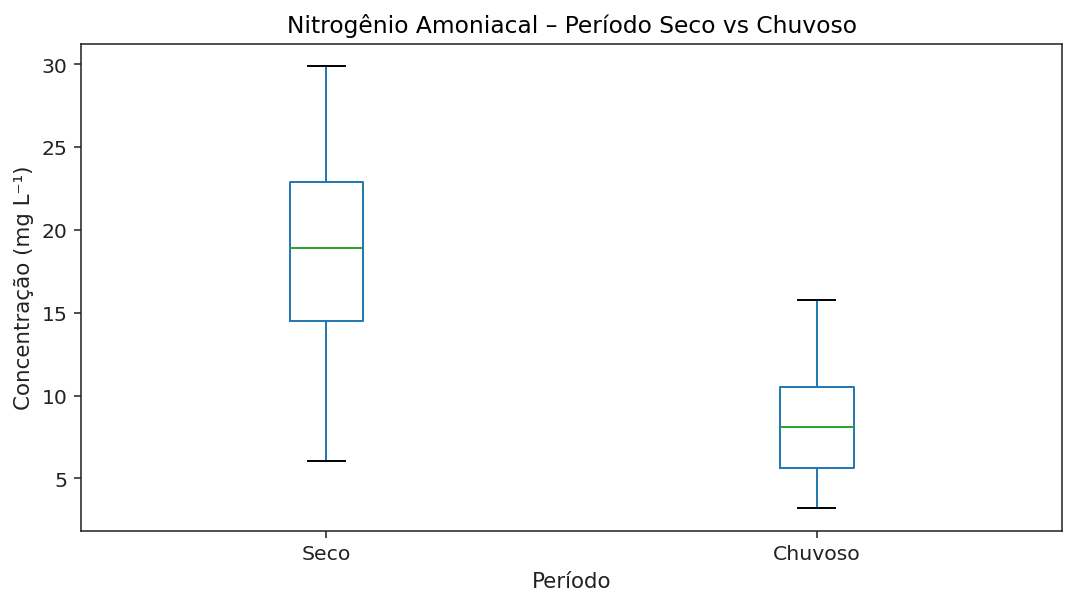

Mann–Whitney Seco vs Chuvoso: U=1436, p=0.0000


In [ ]:
# -*- coding: utf-8 -*-
"""
Série Histórica - Nitrogênio Amoniacal (2010–2025)
Visual moderno + picos/vales + hachura sazonal (período chuvoso)
+ Boxplot por estação (Kruskal–Wallis)
+ Heatmap Ano × Trimestre (medianas)
+ Boxplot Chuvoso × Seco (Mann–Whitney)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.stats import kruskal, mannwhitneyu

# ============== CONFIGURAÇÕES ==============
CAMINHO_ARQUIVO = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'
ABA         = 'Planilha1'
COL_DATA    = 'Data'
COL_PARAM   = 'Parametro'
COL_VALOR   = 'Valor'
PARAM_ALVO  = 'nitrogênio amoniacal'   # busca em lower()
ANO_INICIO  = 2010

# Sombreamento sazonal (Dez–Mar)
ATIVAR_SOMBREAMENTO_CHUVA = True
MESES_CHUVOSOS = {12, 1, 2, 3}

# Aparência moderna
plt.rcParams.update({
    "figure.dpi": 140,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.edgecolor": "#222",
    "axes.labelcolor": "#222",
    "xtick.color": "#222",
    "ytick.color": "#222",
    "font.size": 10.5,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.facecolor": "white",
    "legend.edgecolor": "#ccc",
})

# Paleta
COR_SERIE   = "#1f77b4"   # azul principal
COR_PICOS   = "#b22222"   # vermelho escuro
COR_VALES   = "#ffd34d"   # amarelo forte
COR_VALES_BORDA = "#111"  # borda dos vales
COR_HACHURA = "#1f77b4"   # azul para hachura

def to_num(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')

def estacao_do_ano(m):
    # Estações (Hemisfério Sul, BR)
    # Verão: Dez–Fev | Outono: Mar–Mai | Inverno: Jun–Ago | Primavera: Set–Nov
    if m in (12, 1, 2):  return 'Verão'
    if m in (3, 4, 5):   return 'Outono'
    if m in (6, 7, 8):   return 'Inverno'
    return 'Primavera'

def eh_chuvoso(m):
    return 'Chuvoso' if m in MESES_CHUVOSOS else 'Seco'

# ---------- Leitura e preparo ----------
df = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=ABA)
df[COL_DATA] = pd.to_datetime(df[COL_DATA], dayfirst=True, errors='coerce')
df = df.dropna(subset=[COL_DATA])
df = df[df[COL_DATA].dt.year >= ANO_INICIO].copy()

# Série alvo (NH4)
mask_alvo = df[COL_PARAM].astype(str).str.lower().str.contains(PARAM_ALVO)
df_nh4 = df.loc[mask_alvo, [COL_DATA, COL_VALOR]].copy()
df_nh4['Valor_num'] = to_num(df_nh4[COL_VALOR])
df_nh4 = df_nh4.dropna(subset=['Valor_num']).sort_values(COL_DATA).reset_index(drop=True)

if df_nh4.empty:
    raise ValueError("Sem dados de Nitrogênio Amoniacal no período solicitado.")

# ---------- Estatísticas básicas ----------
print(f"Período: {df_nh4[COL_DATA].min().date()} a {df_nh4[COL_DATA].max().date()}")
print(f"N={len(df_nh4)}, média={df_nh4['Valor_num'].mean():.2f}, mediana={df_nh4['Valor_num'].median():.2f}")

# ---------- Picos & Vales (ambos 20%, mínimo 5) ----------
n_total = len(df_nh4)
n_picos = max(5, int(0.2 * n_total))   # 20% superiores
n_vales = max(5, int(0.2 * n_total))   # 20% inferiores

picos = df_nh4.nlargest(n_picos, 'Valor_num')
vales = df_nh4.nsmallest(n_vales, 'Valor_num')

# ---------- PLOT 0: Série histórica ----------
fig, ax = plt.subplots(figsize=(12, 5.8))

# (A) Hachura sazonal (período chuvoso)
if ATIVAR_SOMBREAMENTO_CHUVA:
    inicio = df_nh4[COL_DATA].min().to_period('M').to_timestamp()
    fim    = df_nh4[COL_DATA].max().to_period('M').to_timestamp() + pd.offsets.MonthEnd(0)
    meses = pd.date_range(inicio, fim, freq='MS')
    for m in meses:
        if m.month in MESES_CHUVOSOS:
            ax.axvspan(m, m + pd.offsets.MonthEnd(1),
                       facecolor='none', edgecolor='none',
                       hatch='////', linewidth=0,
                       alpha=0.08, color=COR_HACHURA,
                       zorder=0)

# (B) Série principal
ax.plot(df_nh4[COL_DATA], df_nh4['Valor_num'],
        color=COR_SERIE, marker='o', markersize=4.5, linewidth=1.6,
        label='Observado')

# (C) Picos e Vales
ax.scatter(picos[COL_DATA], picos['Valor_num'],
           color=COR_PICOS, s=68, zorder=5, label='Picos')
ax.scatter(vales[COL_DATA], vales['Valor_num'],
           color=COR_VALES, edgecolor=COR_VALES_BORDA, linewidths=0.5, s=62, zorder=5, label='Vales')

# (D) Eixo X – marcação anual
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=0)

# (E) Títulos e rótulos
ax.set_title('Série Histórica - Nitrogênio Amoniacal (2010–2025)', loc='center', pad=10)
ax.set_xlabel('Ano')
ax.set_ylabel('Concentração (mg L⁻¹)')

# (F) Legenda interna com hachura
handles, labels = ax.get_legend_handles_labels()
handles.append(Patch(facecolor='none', edgecolor='gray', hatch='////', label='Período chuvoso'))
ax.legend(handles=handles, loc='upper right', fontsize=9,
          frameon=True, framealpha=0.9, facecolor='white',
          edgecolor='lightgray', labelspacing=0.6, handletextpad=0.6)

# Aparência final
ax.margins(x=0.01)
ax.grid(which='major', alpha=0.25)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

# ======================================================================
# 1) BOXPLOT POR ESTAÇÃO + KRUSKAL–WALLIS
# ======================================================================
tmp = df_nh4.copy()
tmp['Mes'] = tmp[COL_DATA].dt.month
tmp['Estacao'] = tmp['Mes'].map(estacao_do_ano)
ordem_estacoes = ['Verão','Outono','Inverno','Primavera']
tmp['Estacao'] = pd.Categorical(tmp['Estacao'], categories=ordem_estacoes, ordered=True)

fig, ax = plt.subplots(figsize=(8.6, 4.9))
tmp.boxplot(column='Valor_num', by='Estacao', grid=False, ax=ax)
ax.set_title('Nitrogênio Amoniacal por Estação')
ax.set_xlabel('Estação')
ax.set_ylabel('Concentração (mg L⁻¹)')
plt.suptitle('')
plt.tight_layout()
plt.show()

grupos = [g['Valor_num'].values for _, g in tmp.groupby('Estacao')]
grupos_validos = [g for g in grupos if len(g) > 0]
if len(grupos_validos) >= 2:
    H, p = kruskal(*grupos_validos)
    print(f"Kruskal–Wallis (entre estações): H={H:.2f}, p={p:.4f}")
else:
    print("Kruskal–Wallis não executado: menos de 2 grupos com dados.")

# ======================================================================
# 2) HEATMAP ANO × TRIMESTRE (MEDIANAS)
# ======================================================================
tmp2 = df_nh4.copy()
tmp2['Ano'] = tmp2[COL_DATA].dt.year
tmp2['Tri'] = ((tmp2[COL_DATA].dt.month - 1) // 3 + 1)  # 1..4
mat = tmp2.pivot_table(index='Ano', columns='Tri', values='Valor_num', aggfunc='median')

# Garantir grade completa (anos e trimestres)
anos = np.arange(tmp2['Ano'].min(), tmp2['Ano'].max() + 1)
mat = mat.reindex(index=anos, columns=[1, 2, 3, 4])

fig, ax = plt.subplots(figsize=(9.2, 5.2))
im = ax.imshow(mat.values, aspect='auto')
ax.set_yticks(np.arange(len(mat.index)))
ax.set_yticklabels(mat.index.astype(int))
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['T1','T2','T3','T4'])
ax.set_xlabel('Trimestre')
ax.set_ylabel('Ano')
ax.set_title('Heatmap de Medianas – Nitrogênio Amoniacal (Ano × Trimestre)')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Concentração (mg L⁻¹)')
plt.tight_layout()
plt.show()

# ======================================================================
# 3) BOXPLOT CHUVOSO × SECO + MANN–WHITNEY
# ======================================================================
tmp3 = df_nh4.copy()
tmp3['Mes'] = tmp3[COL_DATA].dt.month
tmp3['Periodo'] = tmp3['Mes'].map(eh_chuvoso)
tmp3['Periodo'] = pd.Categorical(tmp3['Periodo'], categories=['Seco','Chuvoso'], ordered=True)

fig, ax = plt.subplots(figsize=(7.8, 4.6))
tmp3.boxplot(column='Valor_num', by='Periodo', grid=False, ax=ax)
ax.set_title('Nitrogênio Amoniacal – Período Seco vs Chuvoso')
ax.set_xlabel('Período')
ax.set_ylabel('Concentração (mg L⁻¹)')
plt.suptitle('')
plt.tight_layout()
plt.show()

# Mann–Whitney (bicaudal) entre Seco e Chuvoso
grupo_seco = tmp3.loc[tmp3['Periodo']=='Seco', 'Valor_num'].values
grupo_chuva = tmp3.loc[tmp3['Periodo']=='Chuvoso', 'Valor_num'].values

if len(grupo_seco) > 0 and len(grupo_chuva) > 0:
    U, p_mw = mannwhitneyu(grupo_seco, grupo_chuva, alternative='two-sided')
    print(f"Mann–Whitney Seco vs Chuvoso: U={U:.0f}, p={p_mw:.4f}")
else:
    print("Mann–Whitney não executado: faltam dados em um dos grupos (Seco/Chuvoso).")


Período: 2010-01-07 a 2025-05-06
N=82, média=15.01, mediana=14.55


C:\Users\gustavo.nunes\AppData\Local\Temp\ipykernel_16508\3056124917.py:149: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(m, m + pd.offsets.MonthEnd(1),


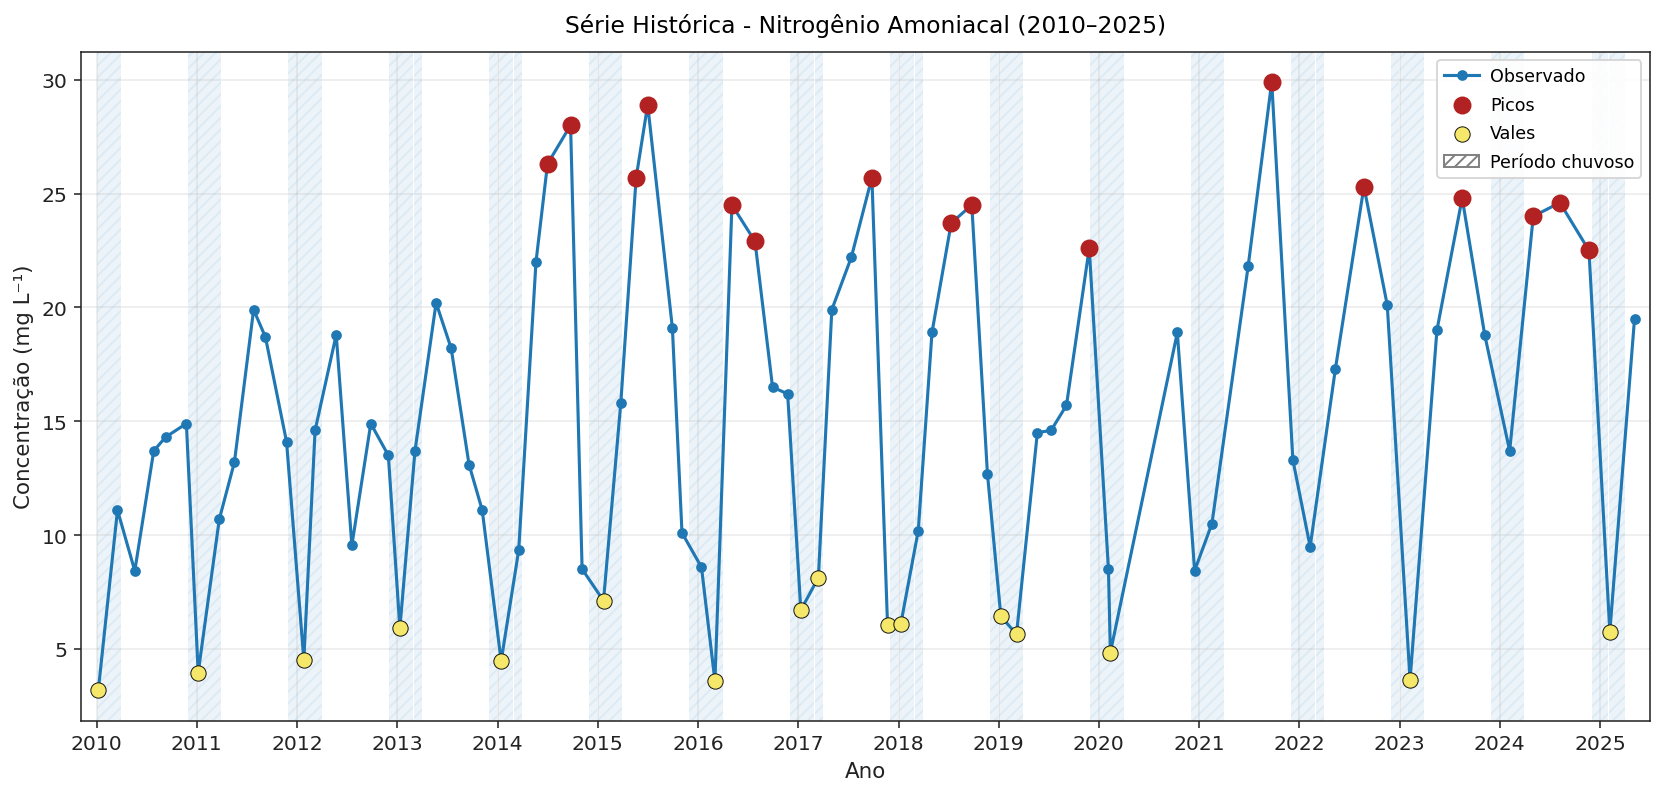

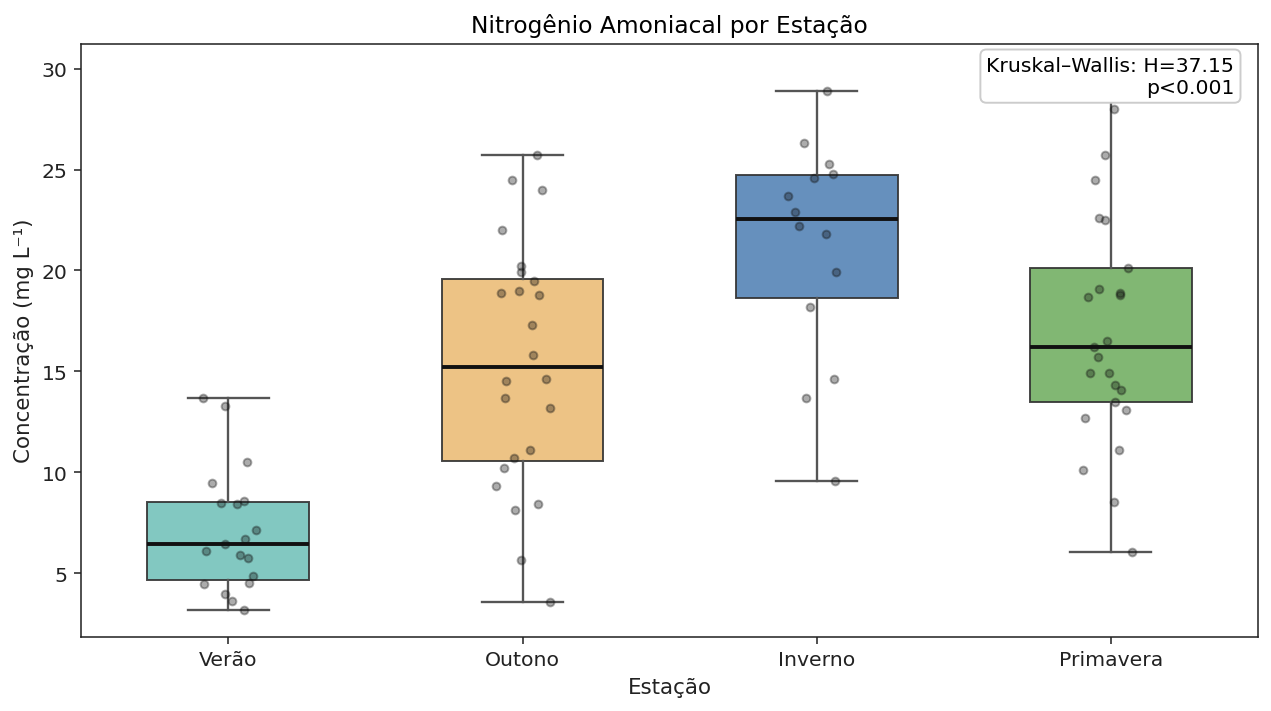

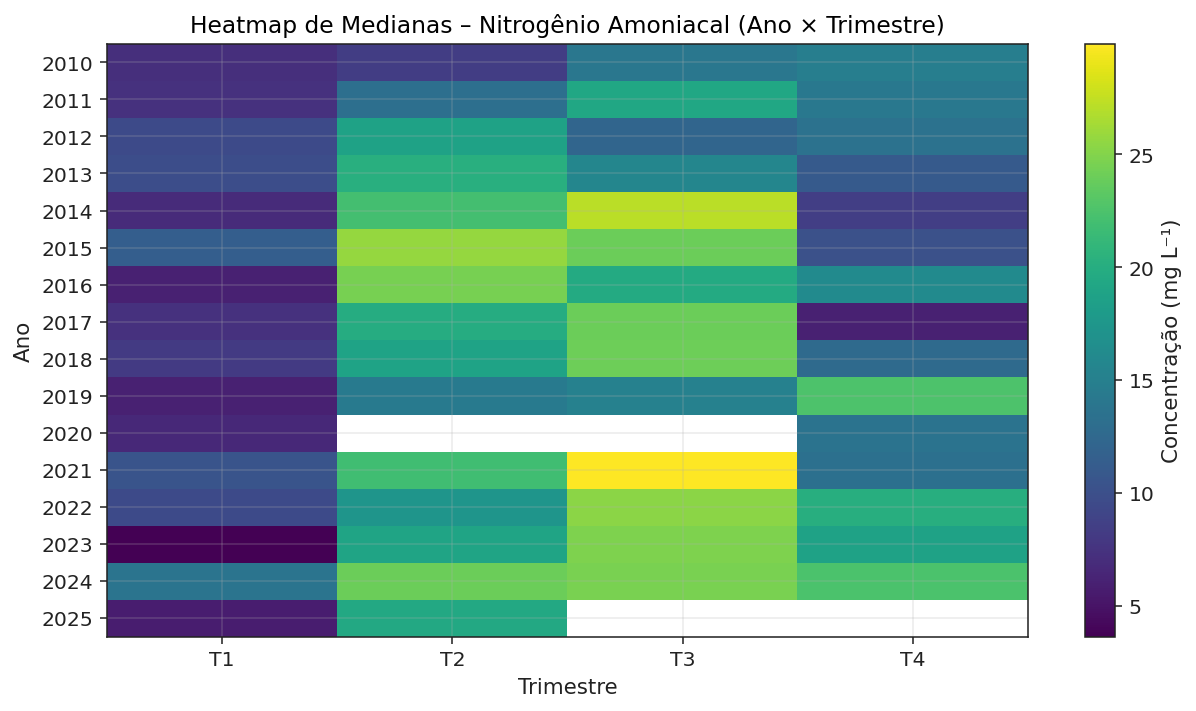

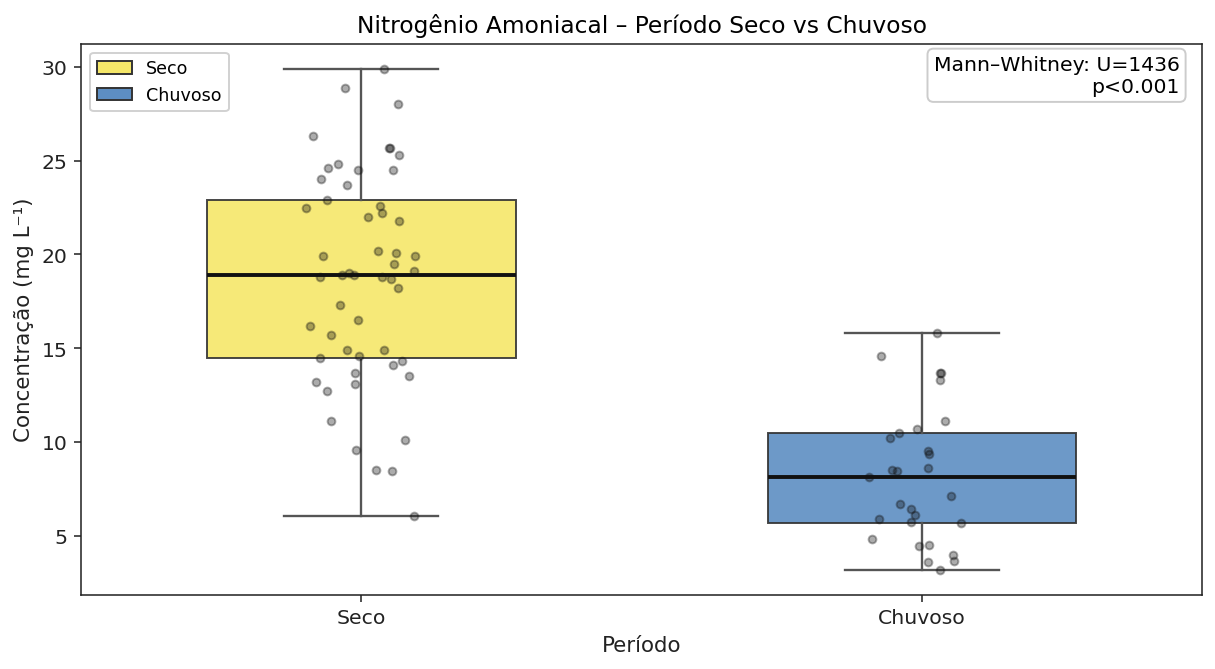

In [ ]:
# -*- coding: utf-8 -*-
"""
Série Histórica - Nitrogênio Amoniacal (2010–2025)
Visual moderno + picos/vales + hachura sazonal (período chuvoso)
+ Boxplot por estação (Kruskal–Wallis) [estilizado, sem média/sem n/sem grade]
+ Heatmap Ano × Trimestre (medianas)
+ Boxplot Chuvoso × Seco (Mann–Whitney) [estilizado, sem média/sem n/sem grade, legenda custom]
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.stats import kruskal, mannwhitneyu

# ============== CONFIGURAÇÕES ==============
CAMINHO_ARQUIVO = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'
ABA         = 'Planilha1'
COL_DATA    = 'Data'
COL_PARAM   = 'Parametro'
COL_VALOR   = 'Valor'
PARAM_ALVO  = 'nitrogênio amoniacal'   # busca em lower()
ANO_INICIO  = 2010

# Sombreamento sazonal (Dez–Mar)
ATIVAR_SOMBREAMENTO_CHUVA = True
MESES_CHUVOSOS = {12, 1, 2, 3}

# Aparência moderna (mantém grade só na série histórica)
plt.rcParams.update({
    "figure.dpi": 140,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.edgecolor": "#222",
    "axes.labelcolor": "#222",
    "xtick.color": "#222",
    "ytick.color": "#222",
    "font.size": 10.5,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.facecolor": "white",
    "legend.edgecolor": "#ccc",
})

# Paleta da série
COR_SERIE   = "#1f77b4"
COR_PICOS   = "#b22222"
COR_VALES   = "#f5e769"
COR_VALES_BORDA = "#111"
COR_HACHURA = "#1f77b4"

# ======= PALETA BOXPLOTS =======
PALETA = {
    'Verão':      "#74C2BB",
    'Outono':     "#EBBD78",
    'Inverno':    "#5584B6",
    'Primavera':  "#73AF64",
    'Seco':       "#F5E769",
    'Chuvoso':    "#5D8EC2",
}

def _styled_boxplot(ax, grupos, cores, titulo, xlabel, labels=None, ylabel='Concentração (mg L⁻¹)'):
    """Boxplot com caixas coloridas, mediana espessa, jitter, rótulos fixos e SEM grade."""
    bp = ax.boxplot(
        grupos, patch_artist=True, widths=0.55, notch=False, showmeans=False,
        medianprops=dict(color='#111', linewidth=2.0),
        whiskerprops=dict(color='#555', linewidth=1.2),
        capprops=dict(color='#555', linewidth=1.2),
        flierprops=dict(marker='o', markersize=3.5, markerfacecolor='#999',
                        markeredgecolor='#777', alpha=0.5)
    )
    for patch, c in zip(bp['boxes'], cores):
        patch.set_facecolor(c)
        patch.set_alpha(0.9)
        patch.set_edgecolor('#333')
        patch.set_linewidth(1.0)

    # jitter (pontos)
    rng = np.random.default_rng(42)
    for i, arr in enumerate(grupos, start=1):
        if len(arr) == 0:
            continue
        x = i + (rng.random(len(arr)) - 0.5) * 0.2
        ax.scatter(x, arr, s=16, alpha=0.35, color='#111', zorder=2)

    # rótulos do eixo X
    if labels is not None:
        ax.set_xticks(range(1, len(labels) + 1))
        ax.set_xticklabels(labels)

    ax.grid(False)  # sem grade nos boxplots
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(titulo)
    ax.set_axisbelow(True)
    return bp

def to_num(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')

def estacao_do_ano(m):
    # Verão: Dez–Fev | Outono: Mar–Mai | Inverno: Jun–Ago | Primavera: Set–Nov
    if m in (12, 1, 2):  return 'Verão'
    if m in (3, 4, 5):   return 'Outono'
    if m in (6, 7, 8):   return 'Inverno'
    return 'Primavera'

def eh_chuvoso(m):
    return 'Chuvoso' if m in MESES_CHUVOSOS else 'Seco'

# ---------- Leitura e preparo ----------
df = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=ABA)
df[COL_DATA] = pd.to_datetime(df[COL_DATA], dayfirst=True, errors='coerce')
df = df.dropna(subset=[COL_DATA])
df = df[df[COL_DATA].dt.year >= ANO_INICIO].copy()

# Série alvo (NH4)
mask_alvo = df[COL_PARAM].astype(str).str.lower().str.contains(PARAM_ALVO)
df_nh4 = df.loc[mask_alvo, [COL_DATA, COL_VALOR]].copy()
df_nh4['Valor_num'] = to_num(df_nh4[COL_VALOR])
df_nh4 = df_nh4.dropna(subset=['Valor_num']).sort_values(COL_DATA).reset_index(drop=True)

if df_nh4.empty:
    raise ValueError("Sem dados de Nitrogênio Amoniacal no período solicitado.")

# ---------- Estatísticas básicas ----------
print(f"Período: {df_nh4[COL_DATA].min().date()} a {df_nh4[COL_DATA].max().date()}")
print(f"N={len(df_nh4)}, média={df_nh4['Valor_num'].mean():.2f}, mediana={df_nh4['Valor_num'].median():.2f}")

# ---------- Picos & Vales ----------
n_total = len(df_nh4)
n_picos = max(5, int(0.2 * n_total))
n_vales = max(5, int(0.2 * n_total))
picos = df_nh4.nlargest(n_picos, 'Valor_num')
vales = df_nh4.nsmallest(n_vales, 'Valor_num')

# ---------- PLOT 0: Série histórica (mantém grade) ----------
fig, ax = plt.subplots(figsize=(12, 5.8))

if ATIVAR_SOMBREAMENTO_CHUVA:
    inicio = df_nh4[COL_DATA].min().to_period('M').to_timestamp()
    fim    = df_nh4[COL_DATA].max().to_period('M').to_timestamp() + pd.offsets.MonthEnd(0)
    meses = pd.date_range(inicio, fim, freq='MS')
    for m in meses:
        if m.month in MESES_CHUVOSOS:
            ax.axvspan(m, m + pd.offsets.MonthEnd(1),
                       facecolor='none', edgecolor='none',
                       hatch='////', linewidth=0, alpha=0.08,
                       color=COR_HACHURA, zorder=0)

ax.plot(df_nh4[COL_DATA], df_nh4['Valor_num'],
        color=COR_SERIE, marker='o', markersize=4.5, linewidth=1.6, label='Observado')

ax.scatter(picos[COL_DATA], picos['Valor_num'], color=COR_PICOS, s=68, zorder=5, label='Picos')
ax.scatter(vales[COL_DATA], vales['Valor_num'], color=COR_VALES, edgecolor=COR_VALES_BORDA,
           linewidths=0.5, s=62, zorder=5, label='Vales')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=0)

ax.set_title('Série Histórica - Nitrogênio Amoniacal (2010–2025)', loc='center', pad=10)
ax.set_xlabel('Ano'); ax.set_ylabel('Concentração (mg L⁻¹)')

handles, labels = ax.get_legend_handles_labels()
handles.append(Patch(facecolor='none', edgecolor='gray', hatch='////', label='Período chuvoso'))
ax.legend(handles=handles, loc='upper right', fontsize=9,
          frameon=True, framealpha=0.9, facecolor='white', edgecolor='lightgray',
          labelspacing=0.6, handletextpad=0.6)

ax.margins(x=0.01)
ax.grid(which='major', alpha=0.25)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

# ======================================================================
# 1) BOXPLOT POR ESTAÇÃO + KRUSKAL–WALLIS (estilizado, sem média/sem n/sem grade)
# ======================================================================
tmp = df_nh4.copy()
tmp['Mes'] = tmp[COL_DATA].dt.month
tmp['Estacao'] = tmp['Mes'].map(estacao_do_ano)
ordem_estacoes = ['Verão','Outono','Inverno','Primavera']

grupos_est = [tmp.loc[tmp['Estacao']==e, 'Valor_num'].values for e in ordem_estacoes]
cores_est   = [PALETA[e] for e in ordem_estacoes]

fig, ax = plt.subplots(figsize=(9.2, 5.2))
_styled_boxplot(
    ax, grupos_est, cores_est,
    titulo='Nitrogênio Amoniacal por Estação',
    xlabel='Estação',
    labels=ordem_estacoes  # <<< rótulos corretos
)

# Kruskal–Wallis + p-valor no gráfico
grupos_validos = [g for g in grupos_est if len(g) > 0]
if len(grupos_validos) >= 2:
    H, p = kruskal(*grupos_validos)
    ax.text(0.98, 0.98, f"Kruskal–Wallis: H={H:.2f}\n" + ("p<0.001" if p < 0.001 else f"p={p:.3f}"),
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#ccc'))
else:
    ax.text(0.98, 0.98, "Kruskal–Wallis não aplicado", transform=ax.transAxes,
            ha='right', va='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#ccc'))

plt.tight_layout()
plt.show()

# ======================================================================
# 2) HEATMAP ANO × TRIMESTRE (MEDIANAS)  [inalterado]
# ======================================================================
tmp2 = df_nh4.copy()
tmp2['Ano'] = tmp2[COL_DATA].dt.year
tmp2['Tri'] = ((tmp2[COL_DATA].dt.month - 1) // 3 + 1)  # 1..4
mat = tmp2.pivot_table(index='Ano', columns='Tri', values='Valor_num', aggfunc='median')

anos = np.arange(tmp2['Ano'].min(), tmp2['Ano'].max() + 1)
mat = mat.reindex(index=anos, columns=[1, 2, 3, 4])

fig, ax = plt.subplots(figsize=(9.2, 5.2))
im = ax.imshow(mat.values, aspect='auto')
ax.set_yticks(np.arange(len(mat.index))); ax.set_yticklabels(mat.index.astype(int))
ax.set_xticks([0,1,2,3]); ax.set_xticklabels(['T1','T2','T3','T4'])
ax.set_xlabel('Trimestre'); ax.set_ylabel('Ano')
ax.set_title('Heatmap de Medianas – Nitrogênio Amoniacal (Ano × Trimestre)')
cbar = plt.colorbar(im, ax=ax); cbar.set_label('Concentração (mg L⁻¹)')
plt.tight_layout(); plt.show()

# ======================================================================
# 3) BOXPLOT CHUVOSO × SECO + MANN–WHITNEY (estilizado, sem média/sem n/sem grade)
# ======================================================================
tmp3 = df_nh4.copy()
meses = tmp3[COL_DATA].dt.month
tmp3['Periodo'] = np.where(meses.isin(MESES_CHUVOSOS), 'Chuvoso', 'Seco')
ordem_periodo = ['Seco','Chuvoso']

grupos_per = [tmp3.loc[tmp3['Periodo']==p, 'Valor_num'].values for p in ordem_periodo]
cores_per  = [PALETA[p] for p in ordem_periodo]

fig, ax = plt.subplots(figsize=(8.8, 4.9))
_styled_boxplot(
    ax, grupos_per, cores_per,
    titulo='Nitrogênio Amoniacal – Período Seco vs Chuvoso',
    xlabel='Período',
    labels=ordem_periodo  # <<< rótulos corretos
)

# Legenda customizada (evita "1" e "2")
leg_patches = [Patch(facecolor=PALETA[nm], edgecolor='#333', label=nm) for nm in ordem_periodo]
ax.legend(handles=leg_patches, loc='upper left', frameon=True, framealpha=0.9, edgecolor='#ccc', fontsize=9)

# Mann–Whitney + p-valor no gráfico
if all(len(g) > 0 for g in grupos_per):
    U, p_mw = mannwhitneyu(grupos_per[0], grupos_per[1], alternative='two-sided')
    ax.text(0.98, 0.98, f"Mann–Whitney: U={U:.0f}\n" + ("p<0.001" if p_mw < 0.001 else f"p={p_mw:.3f}"),
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#ccc'))
else:
    ax.text(0.98, 0.98, "Mann–Whitney não aplicado", transform=ax.transAxes,
            ha='right', va='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#ccc'))

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

caminho_arquivo = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'
df = pd.read_excel(caminho_arquivo, sheet_name='Planilha1')

df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Filtrar intervalo
df_filtrado = df[(df['Data'].dt.year >= 2010) & (df['Data'].dt.year <= 2025)]

# Corrigir valores numéricos
df_filtrado['Valor'] = df_filtrado['Valor'].astype(str).str.replace(',', '.', regex=False).astype(float)

# Pivotar
df_wide = df_filtrado.pivot(index='Data', columns='Parametro', values='Valor')

# Calcular correlação
correlacoes = df_wide.corr()

print(correlacoes)


Parametro                Chuvas nas últimas 24h  Condutividade  Fósforo Total  Nitrogênio Amoniacal     OD  Sólido Dissolvido Total     pH
Parametro                                                                                                                                 
Chuvas nas últimas 24h                    1.000         -0.706         -0.581                -0.709  0.265                   -0.681 -0.145
Condutividade                            -0.706          1.000          0.858                 0.951 -0.361                    0.912  0.254
Fósforo Total                            -0.581          0.858          1.000                 0.892 -0.316                    0.806  0.232
Nitrogênio Amoniacal                     -0.709          0.951          0.892                 1.000 -0.372                    0.863  0.316
OD                                        0.265         -0.361         -0.316                -0.372  1.000                   -0.256 -0.348
Sólido Dissolvido Total    

C:\Users\gustavo.nunes\AppData\Local\Temp\ipykernel_39984\2855410297.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Valor'] = df_filtrado['Valor'].astype(str).str.replace(',', '.', regex=False).astype(float)


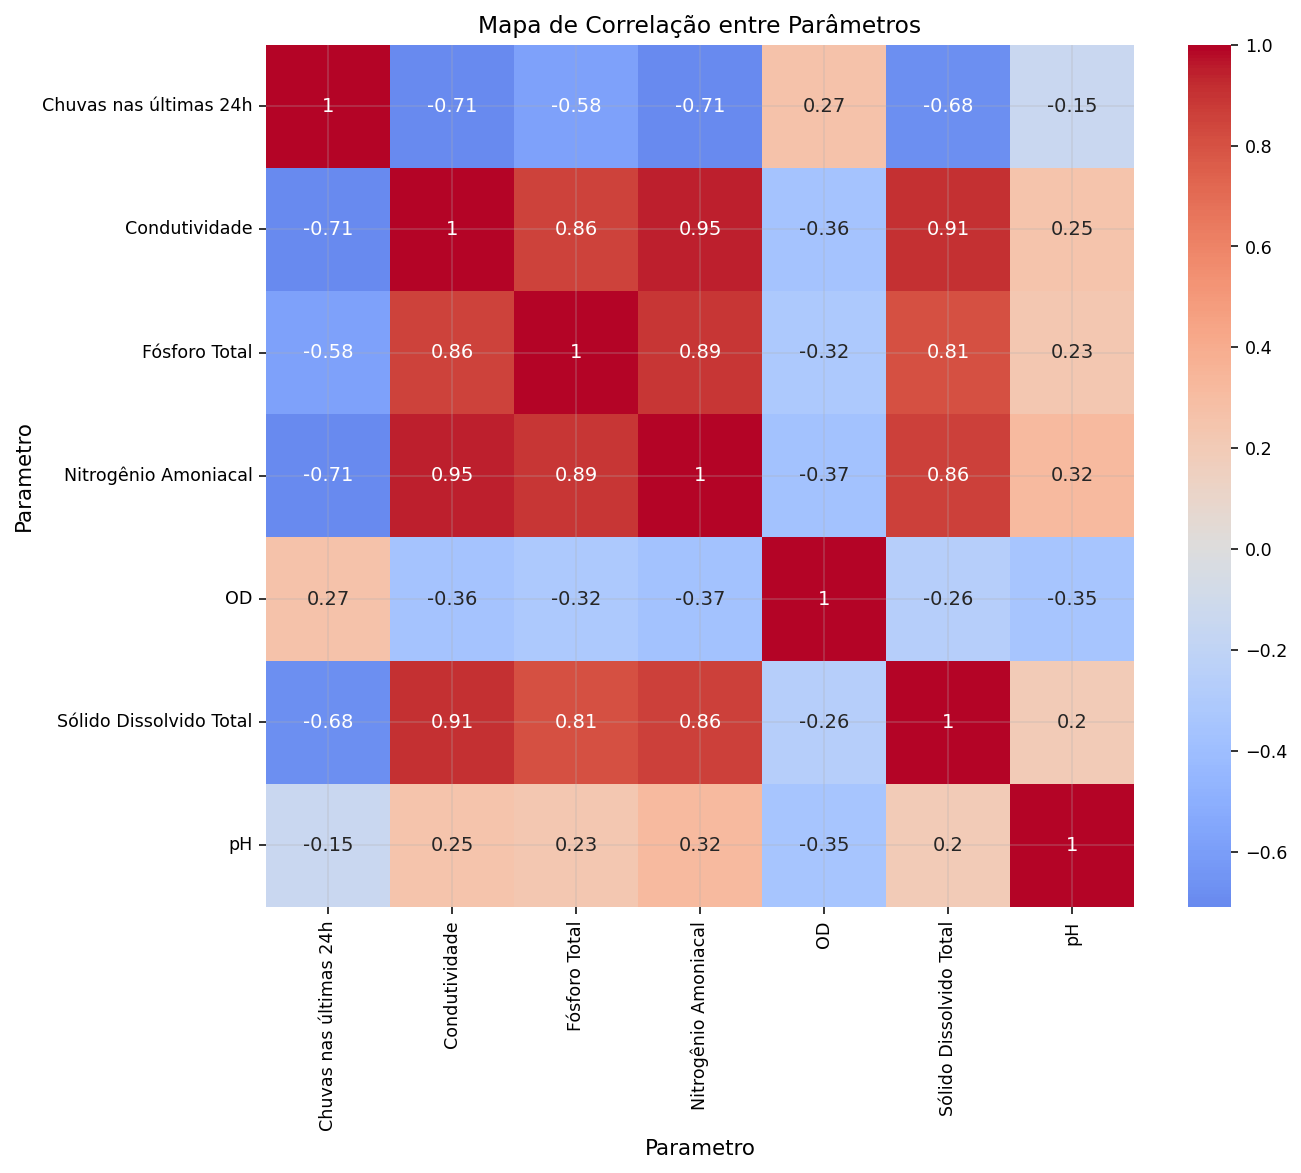

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlacoes, annot=True, cmap='coolwarm', center=0)
plt.title('Mapa de Correlação entre Parâmetros')
plt.show()


In [ ]:
import pandas as pd

# Carregar os dados
caminho_arquivo = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'
df = pd.read_excel(caminho_arquivo, sheet_name='Planilha1')

# Garantir que a coluna Data está no formato datetime
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True, errors='coerce')

# Remover linhas sem data ou parâmetro
df = df.dropna(subset=['Data', 'Parametro'])

# Criar coluna com o ano
df['Ano'] = df['Data'].dt.year

# Ano limite para últimos 5 anos
ano_limite = pd.Timestamp.today().year - 5

# Filtrar os dados dos últimos 5 anos
df_ultimos_5_anos = df[df['Ano'] >= ano_limite]

# Contar ocorrências por ano e parâmetro
contagem = df_ultimos_5_anos.groupby(['Ano', 'Parametro']).size().reset_index(name='Contagem')

# Ordenar para facilitar visualização
contagem = contagem.sort_values(by=['Ano', 'Contagem'], ascending=[False, False])

print(contagem)



     Ano                Parametro  Contagem
35  2025   Chuvas nas últimas 24h         4
36  2025            Condutividade         4
39  2025                       OD         4
41  2025                       pH         4
37  2025            Fósforo Total         2
38  2025     Nitrogênio Amoniacal         2
40  2025  Sólido Dissolvido Total         2
29  2024            Condutividade         4
30  2024            Fósforo Total         4
31  2024     Nitrogênio Amoniacal         4
32  2024                       OD         4
33  2024  Sólido Dissolvido Total         4
34  2024                       pH         4
28  2024   Chuvas nas últimas 24h         3
21  2023   Chuvas nas últimas 24h         4
22  2023            Condutividade         4
23  2023            Fósforo Total         4
24  2023     Nitrogênio Amoniacal         4
25  2023                       OD         4
26  2023  Sólido Dissolvido Total         4
27  2023                       pH         4
14  2022   Chuvas nas últimas 24

[INFO] Dados (após filtro ANO_MINIMO=2019 e alvo não nulo): 2019-01-09 a 2025-05-06
[INFO] CV temporal (OOF): treina sequencialmente desde 2019-01-09
[INFO] Gráficos gerais: exibidos desde 2019-01-01
[INFO] Backtesting (gráficos): desde 2022-01-01 (ou 12 meses antes do início, o que for mais recente)


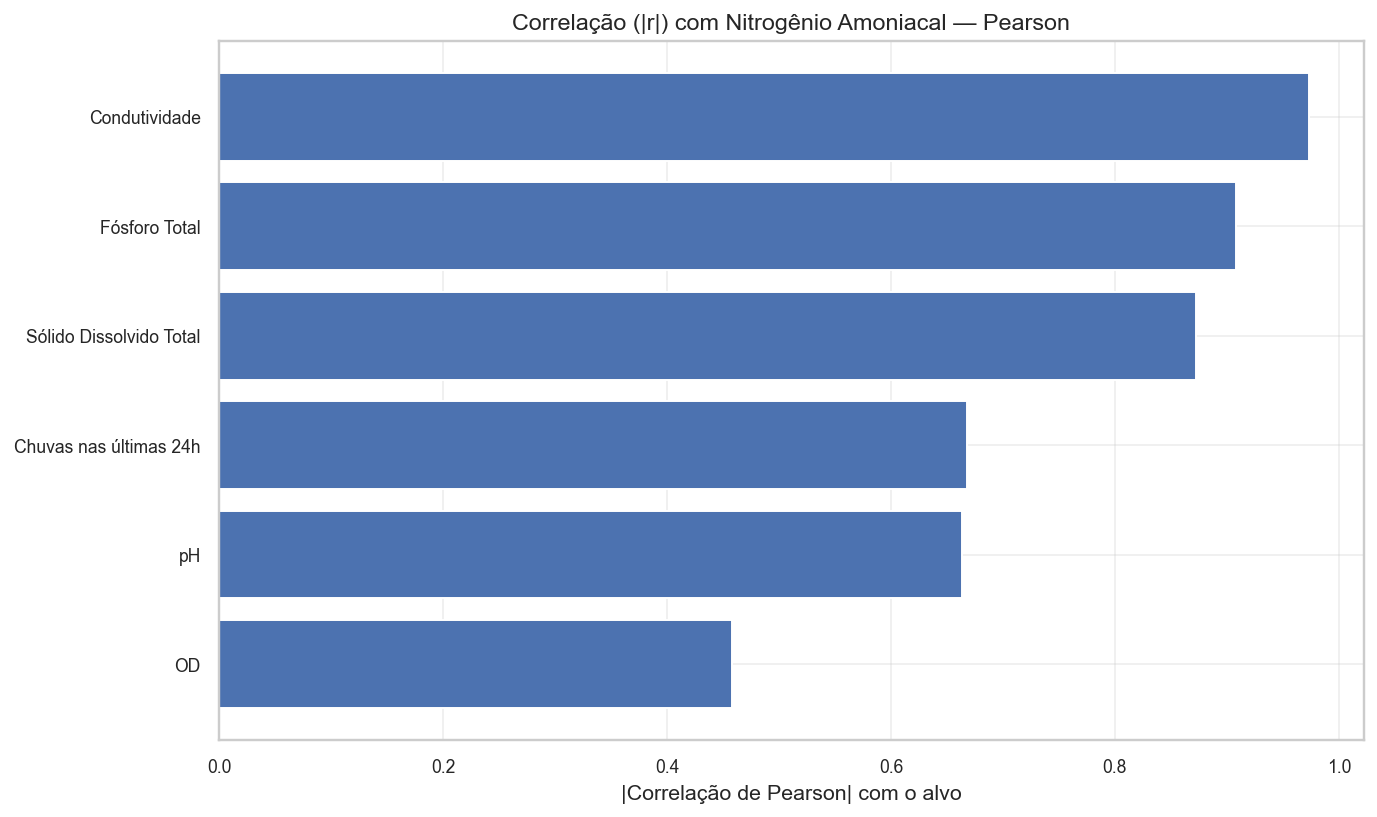

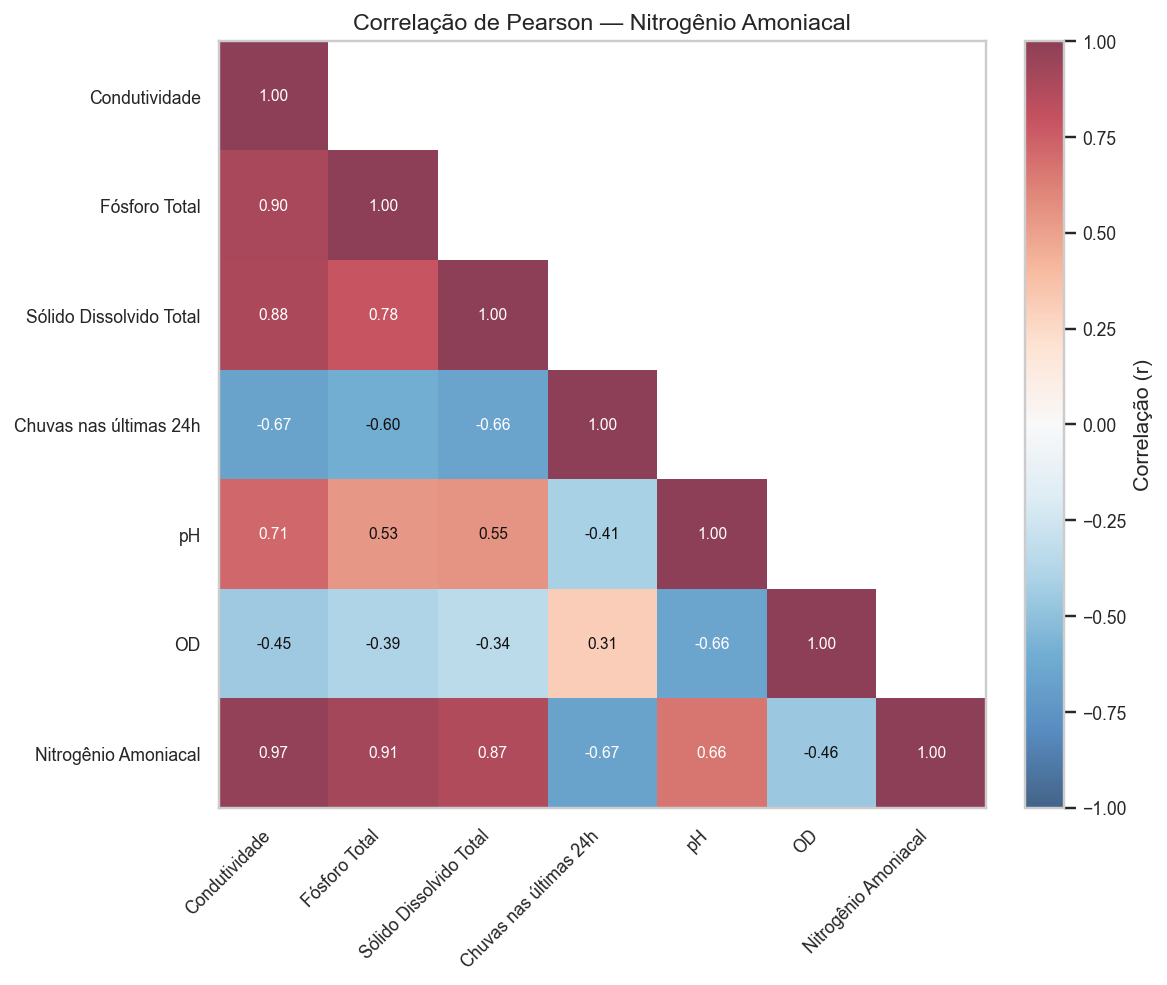

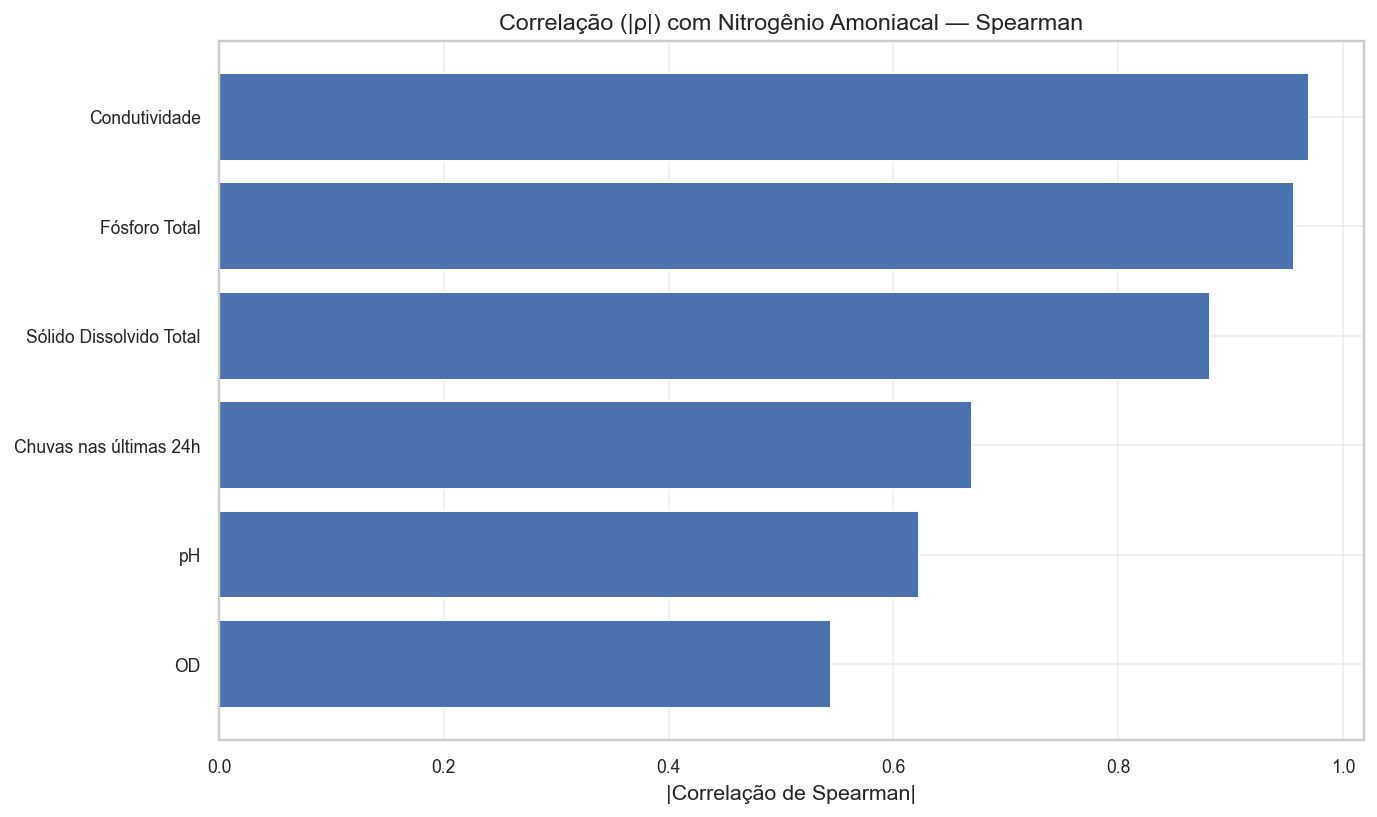

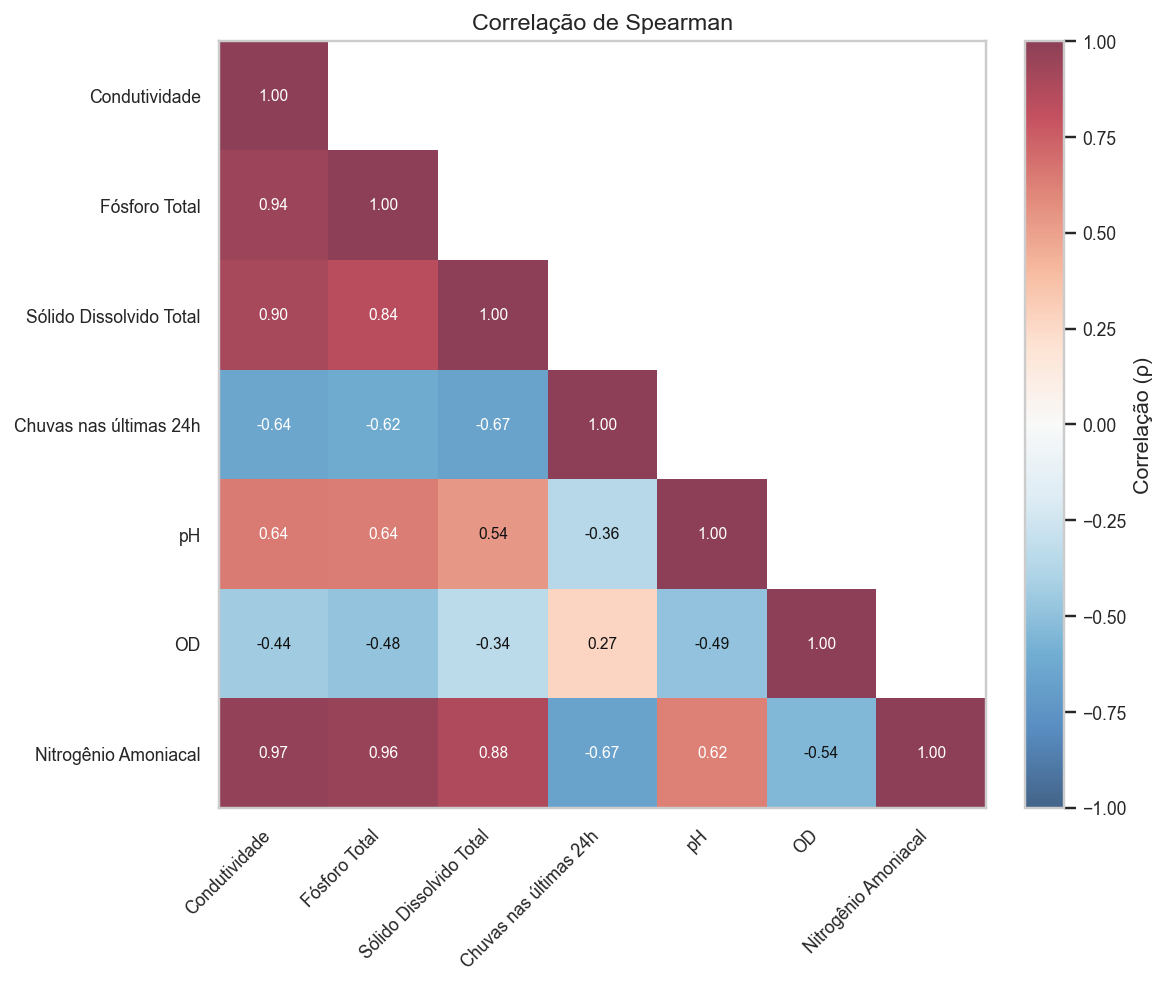

C:\Users\gustavo.nunes\AppData\Local\Temp\ipykernel_1860\1990749861.py:451: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  oof_preds_por_modelo[nome] = pd.concat(
C:\Users\gustavo.nunes\AppData\Local\Temp\ipykernel_1860\1990749861.py:451: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  oof_preds_por_modelo[nome] = pd.concat(
C:\Users\gustavo.nunes\AppData\Local\Temp\ipykernel_1860\1990749861.py:451: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determini


=== MÉTRICAS (média ± desvio; e OOF) ===
  Modelo Seletor_corr  R2_mean  R2_std    R2_OOF  RMSE_mean  RMSE_std  \
1     RF     spearman      NaN     NaN  0.843174        NaN       NaN   
2    XGB     spearman      NaN     NaN  0.807834        NaN       NaN   
0    MLP     spearman      NaN     NaN  0.774721        NaN       NaN   

   RMSE_OOF  MAE_mean  MAE_std  ...  MAPE_OOF(%)  R_mean(Pearson)  \
1  2.769846       NaN      NaN  ...    12.665261              NaN   
2  3.066090       NaN      NaN  ...    15.896039              NaN   
0  3.319768       NaN      NaN  ...    25.659471              NaN   

   R_std(Pearson)  R_OOF(Pearson)  R_mean(Spearman)  R_std(Spearman)  \
1             NaN        0.946775               NaN              NaN   
2             NaN        0.951151               NaN              NaN   
0             NaN        0.884699               NaN              NaN   

   R_OOF(Spearman)  CCC_mean  CCC_std   CCC_OOF  
1         0.950376       NaN      NaN  0.910410  

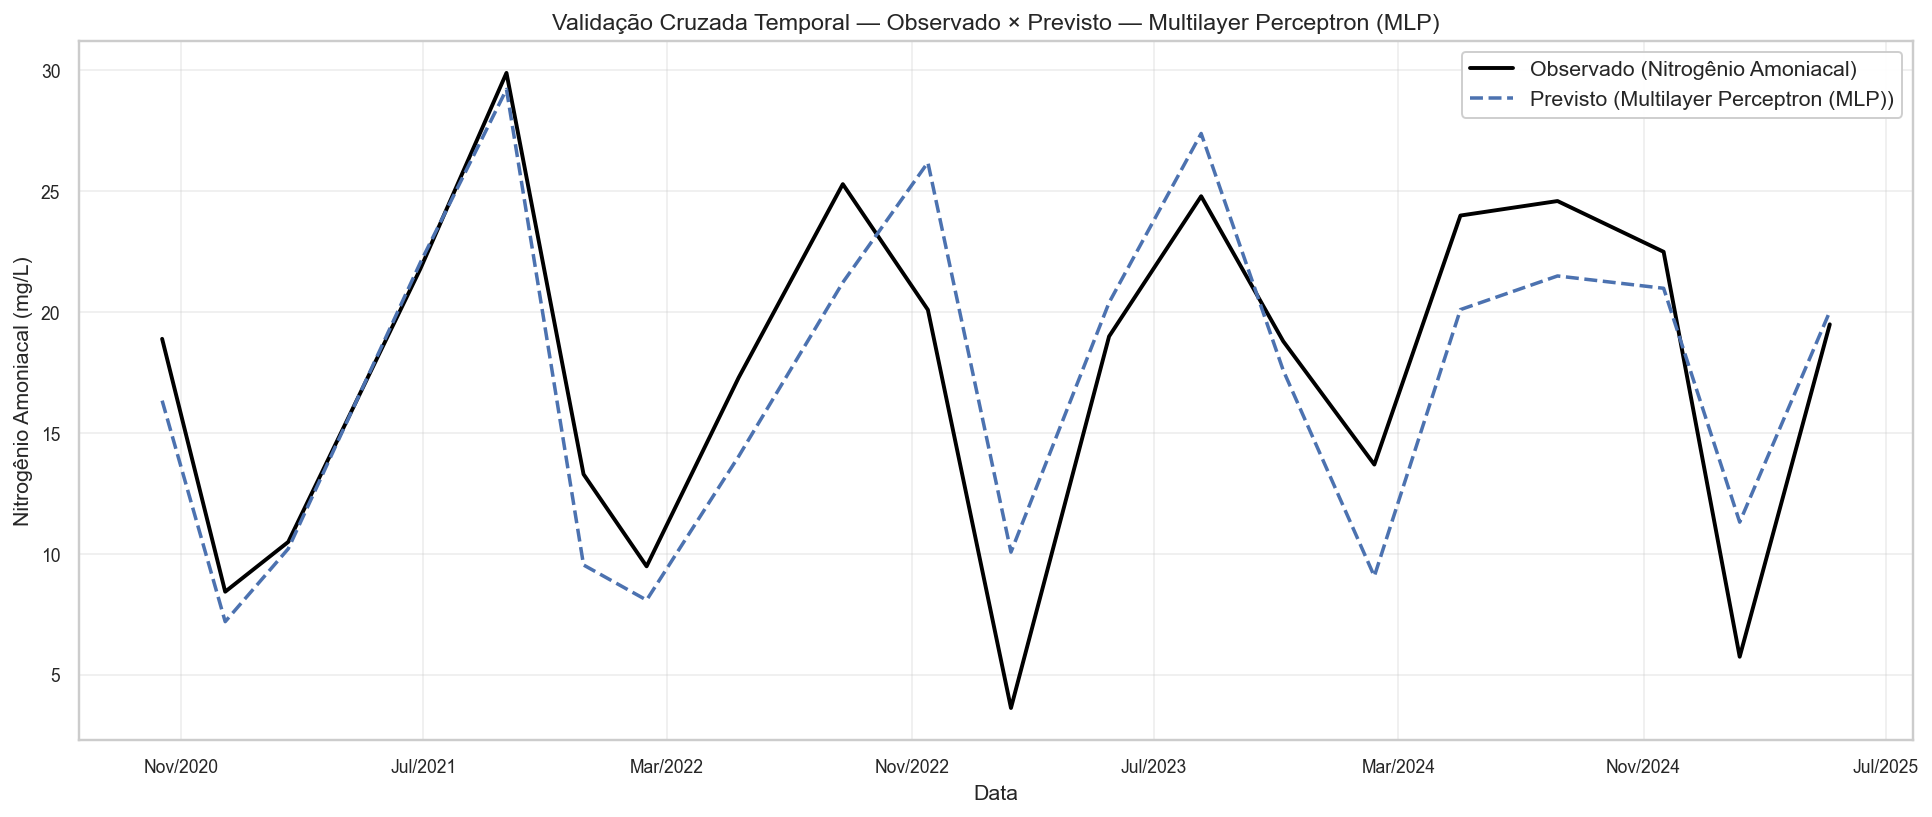

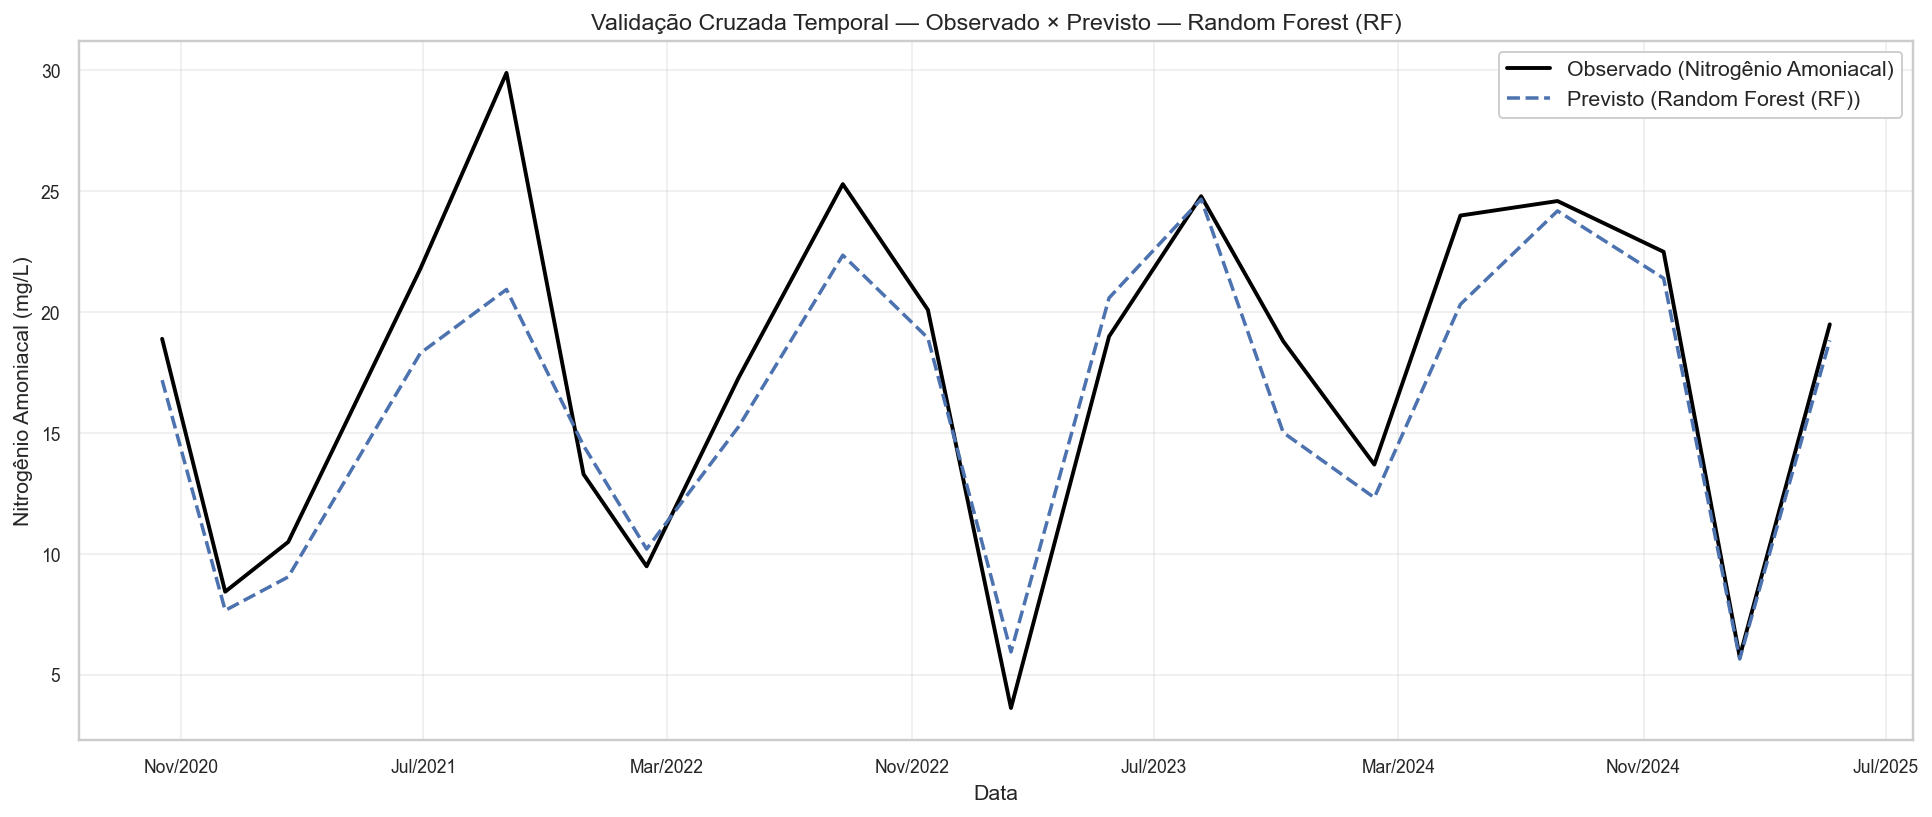

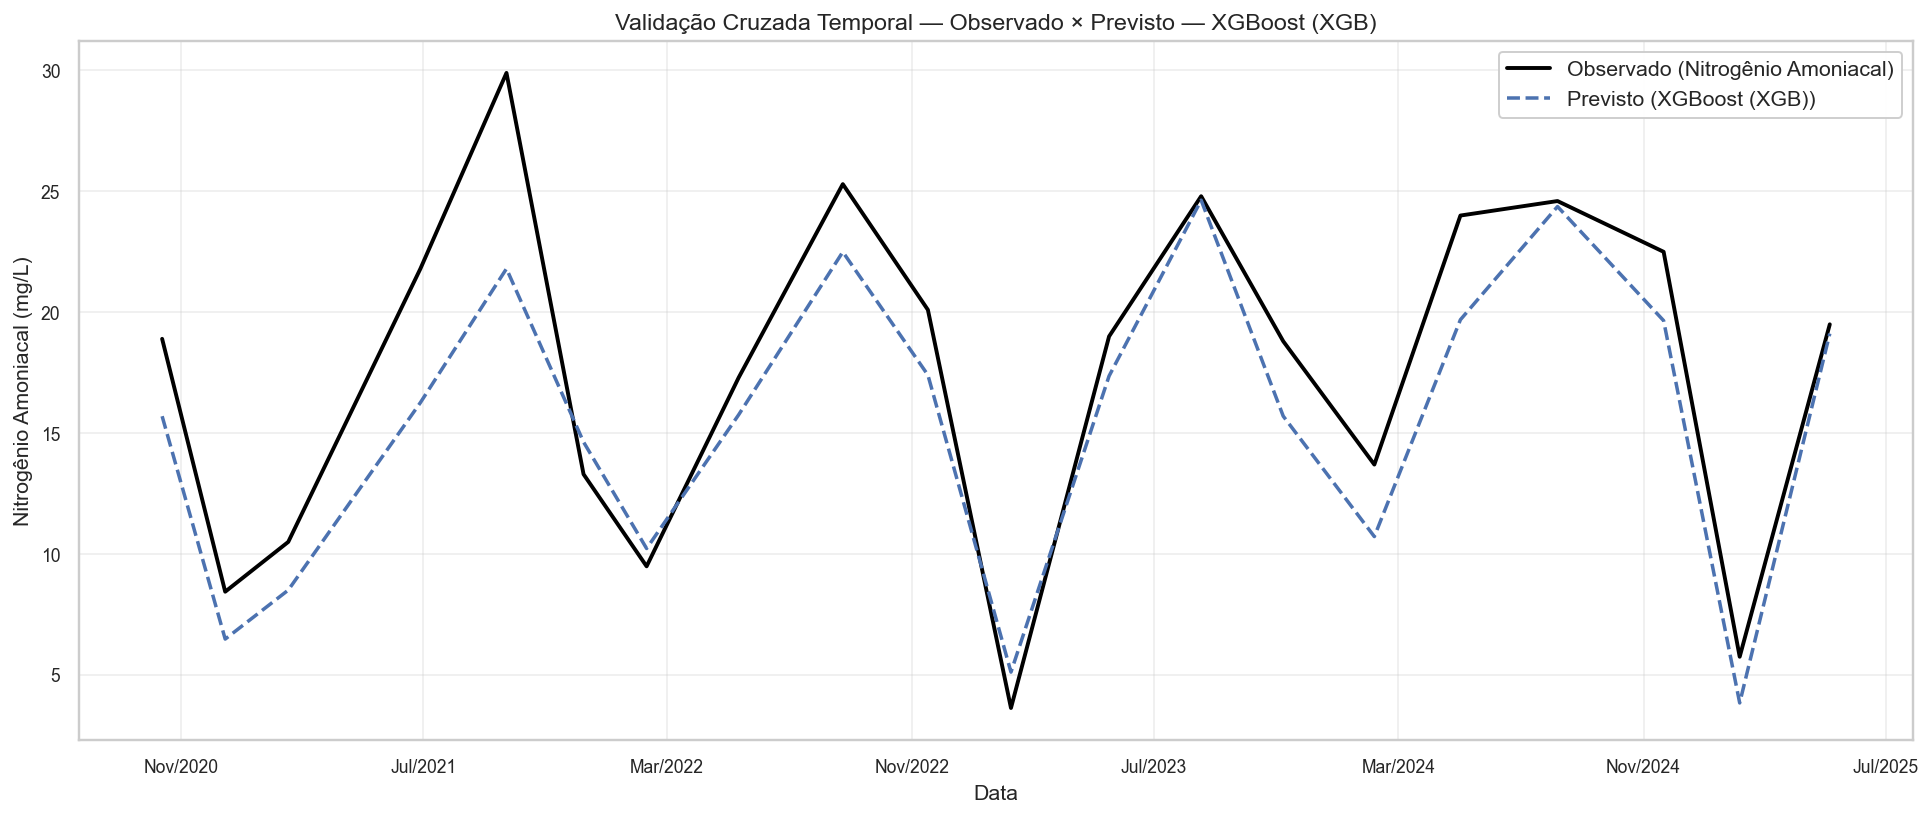

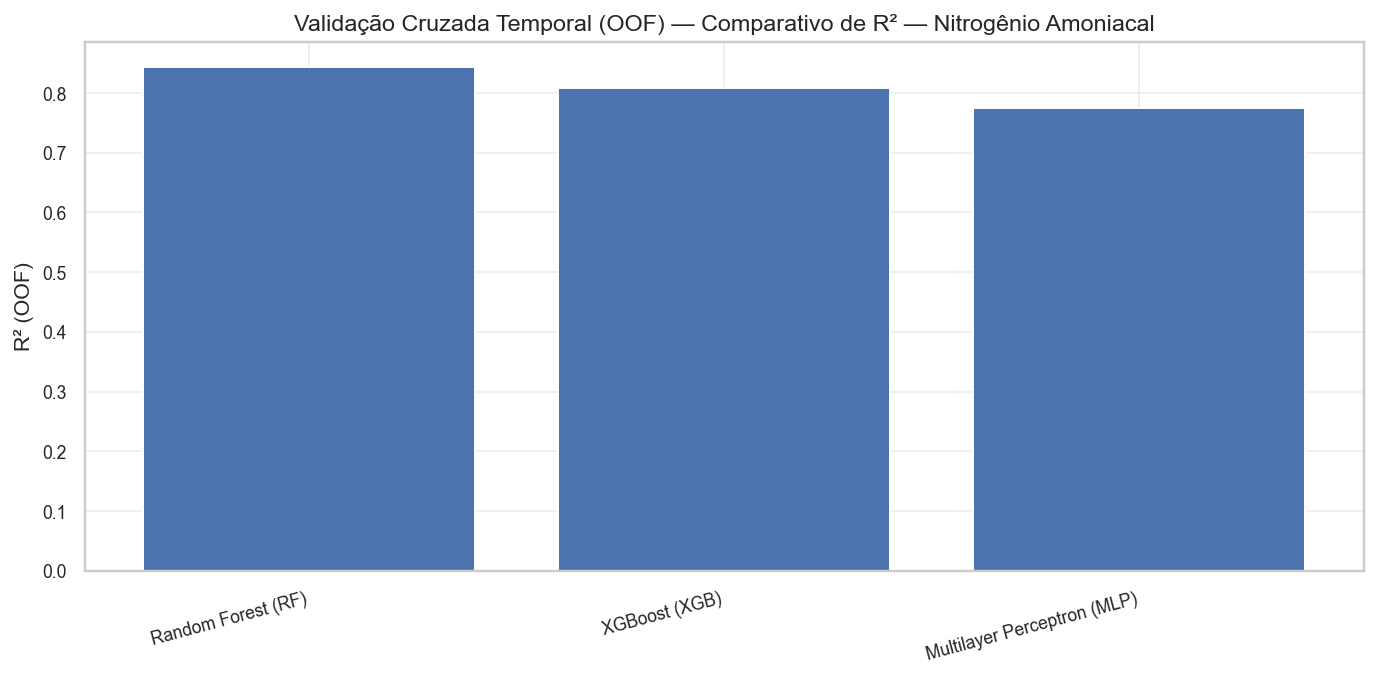

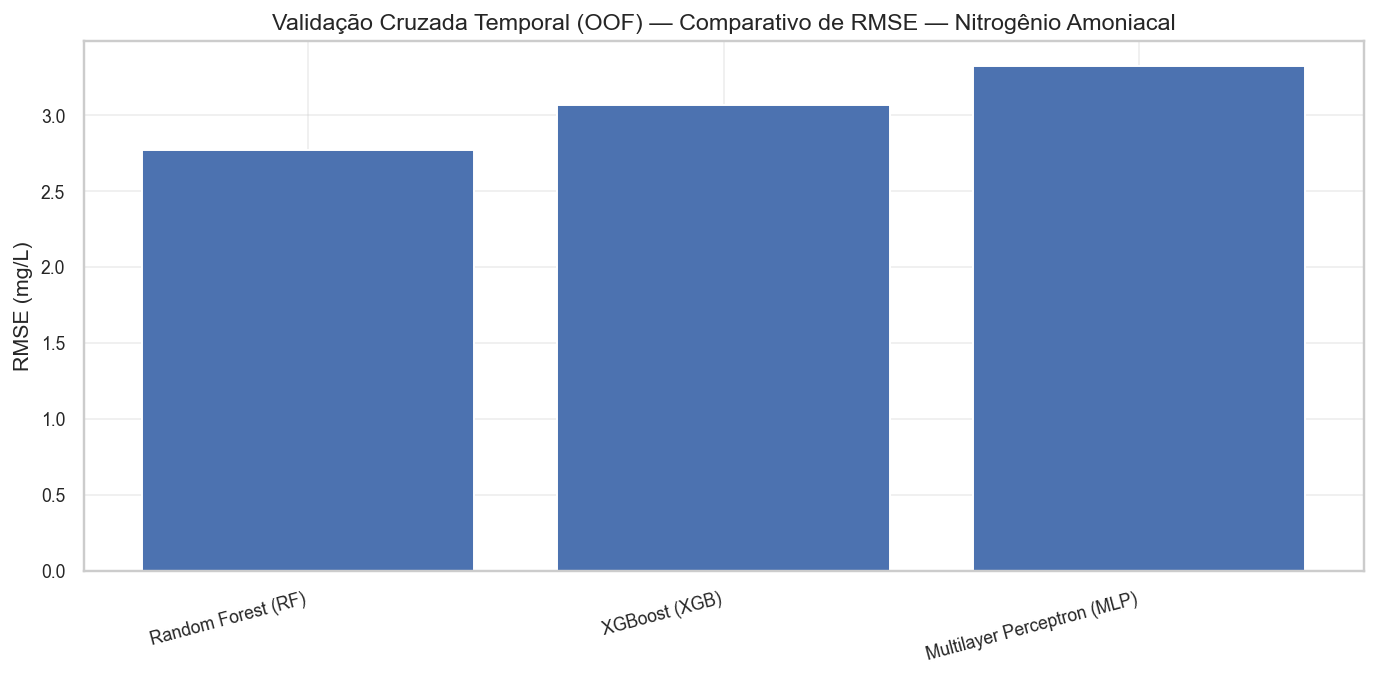

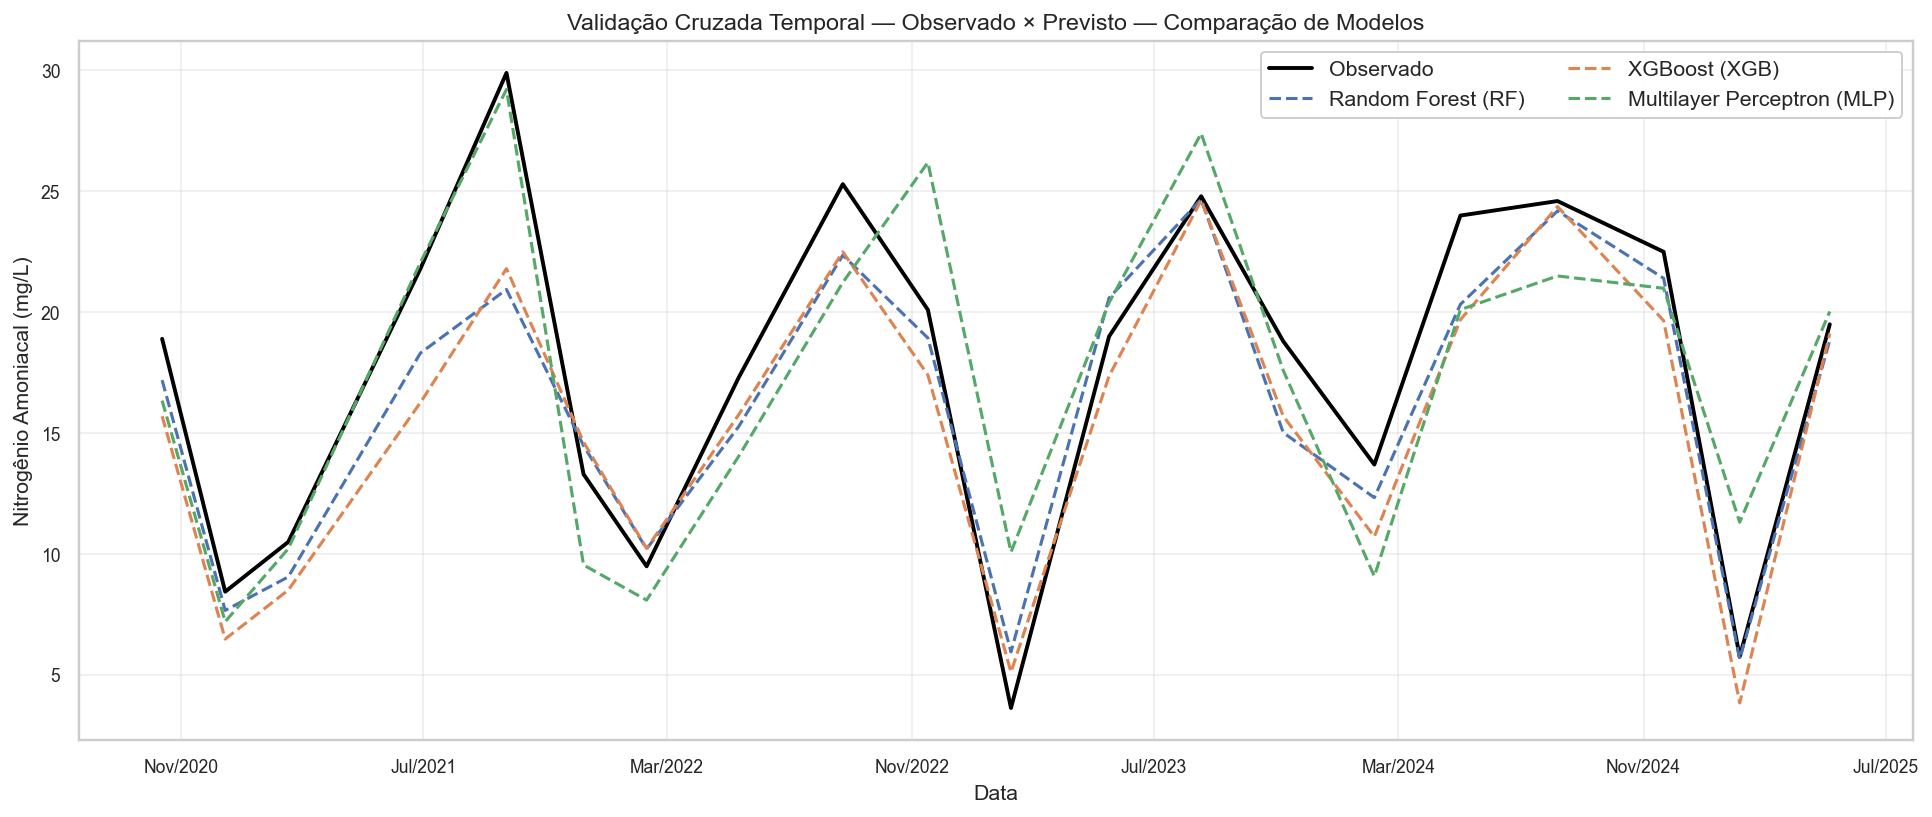

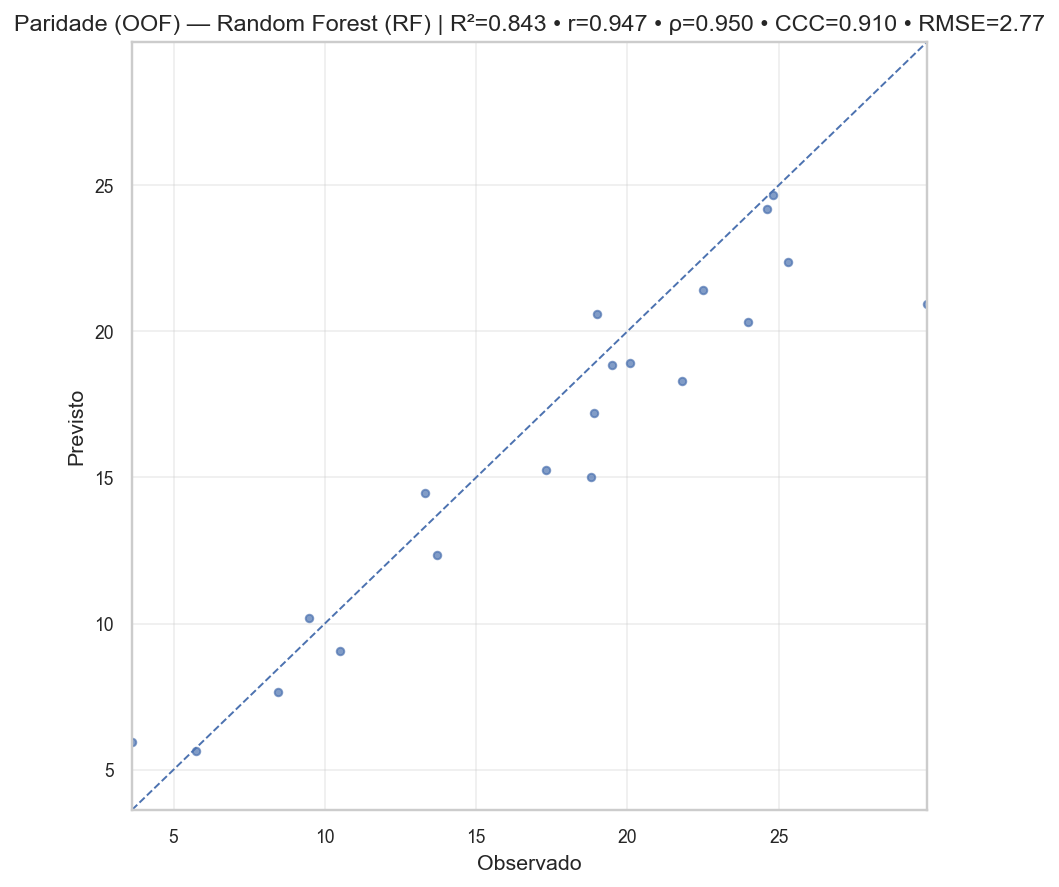

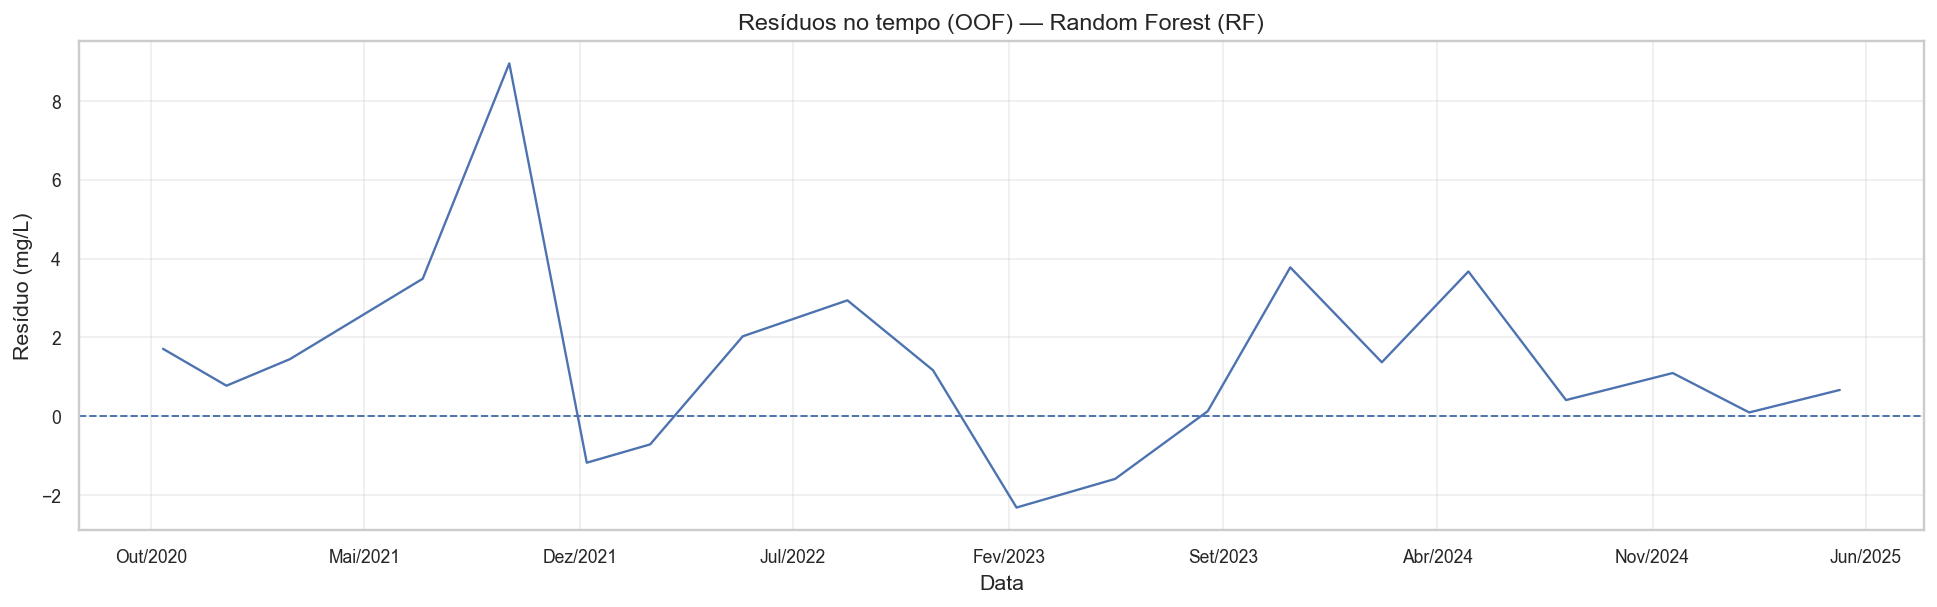

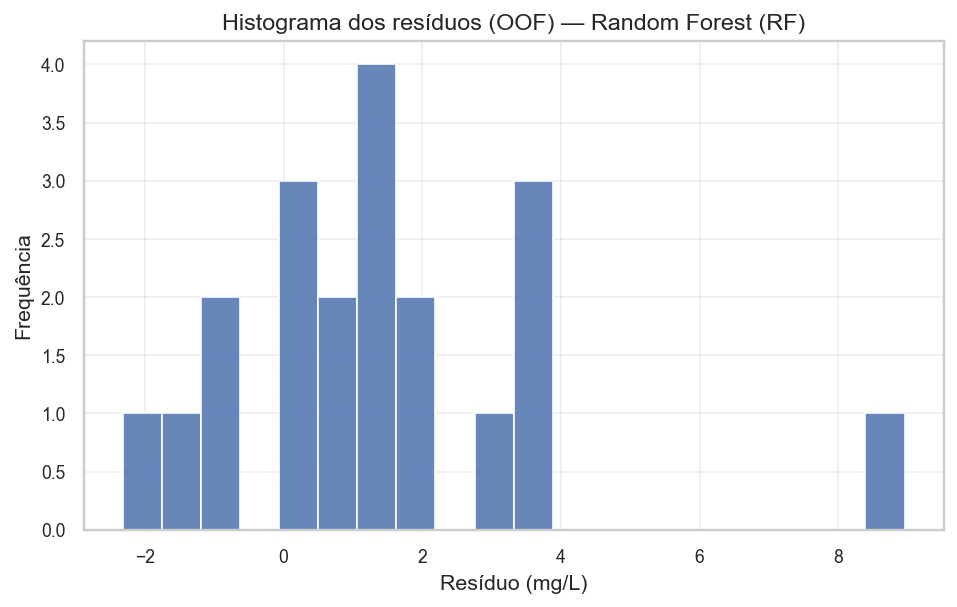

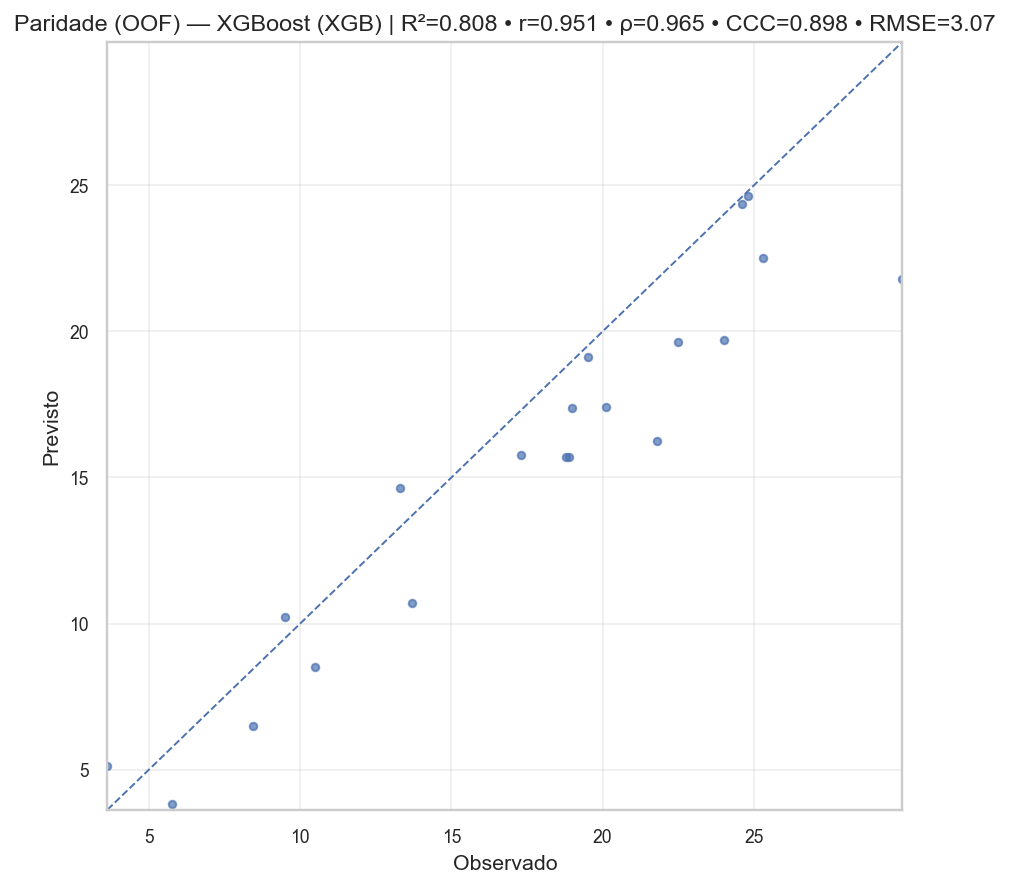

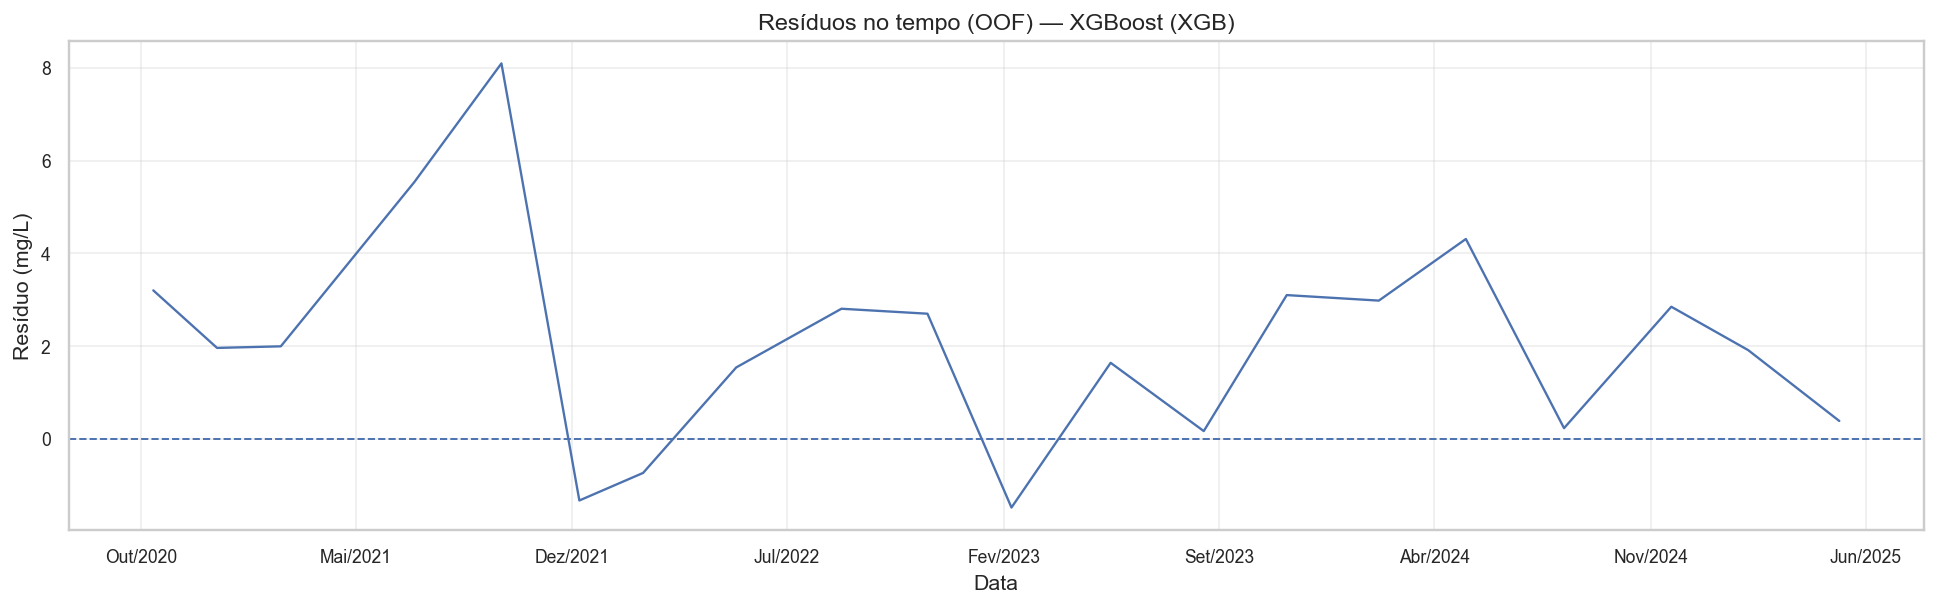

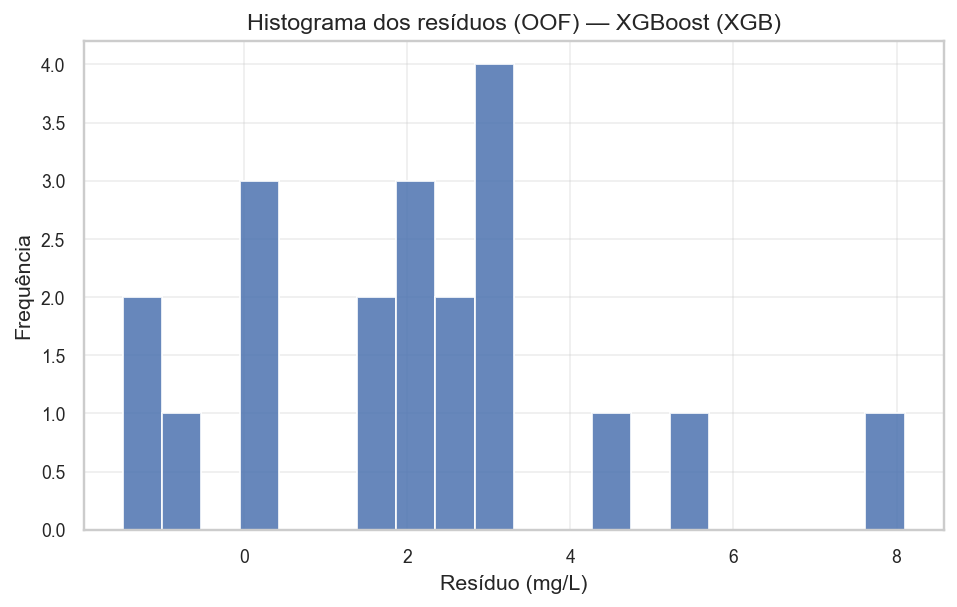

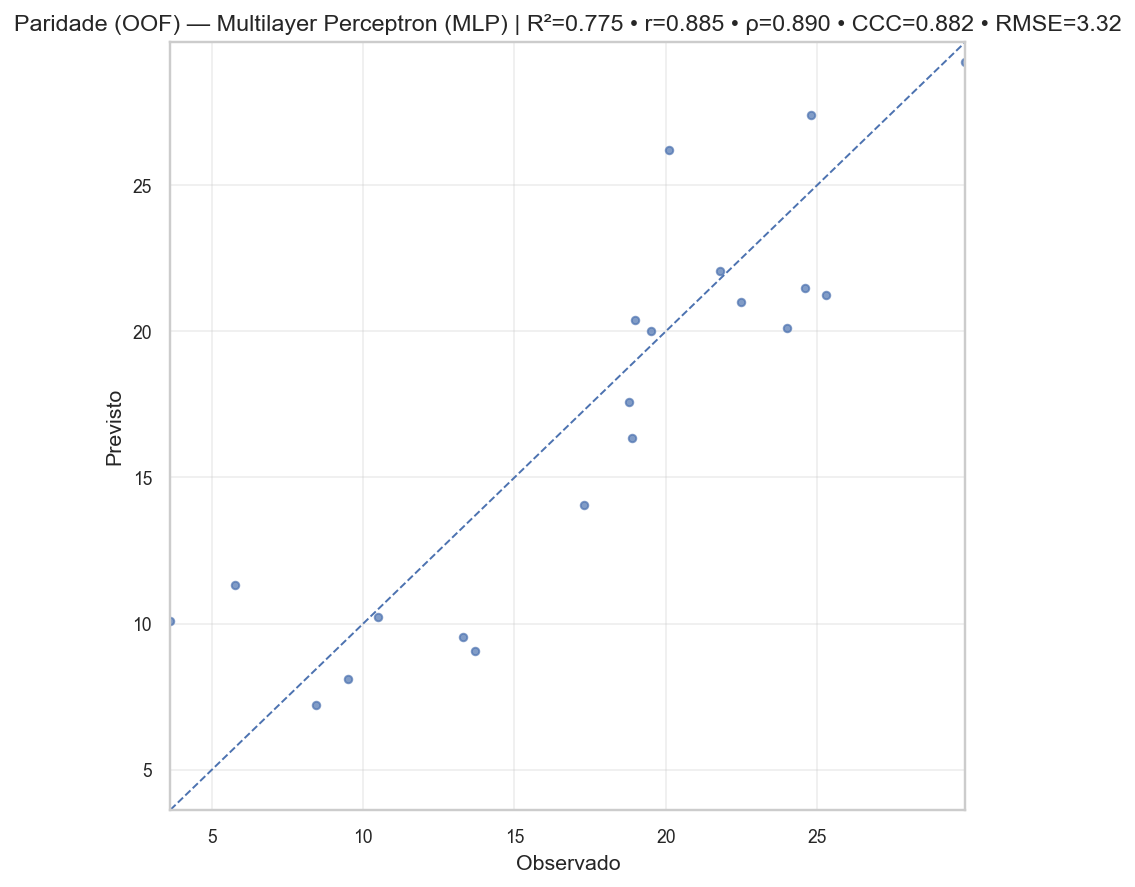

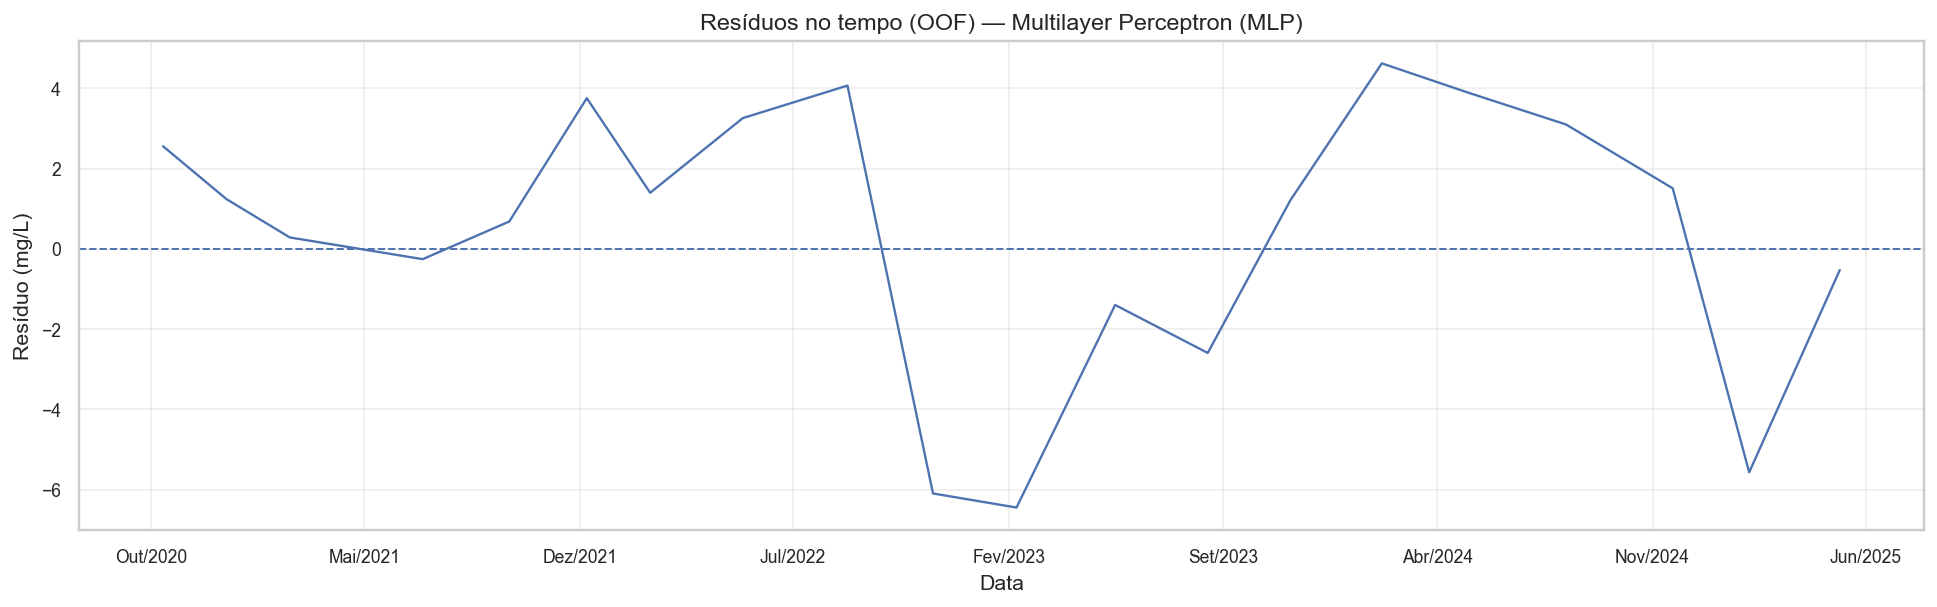

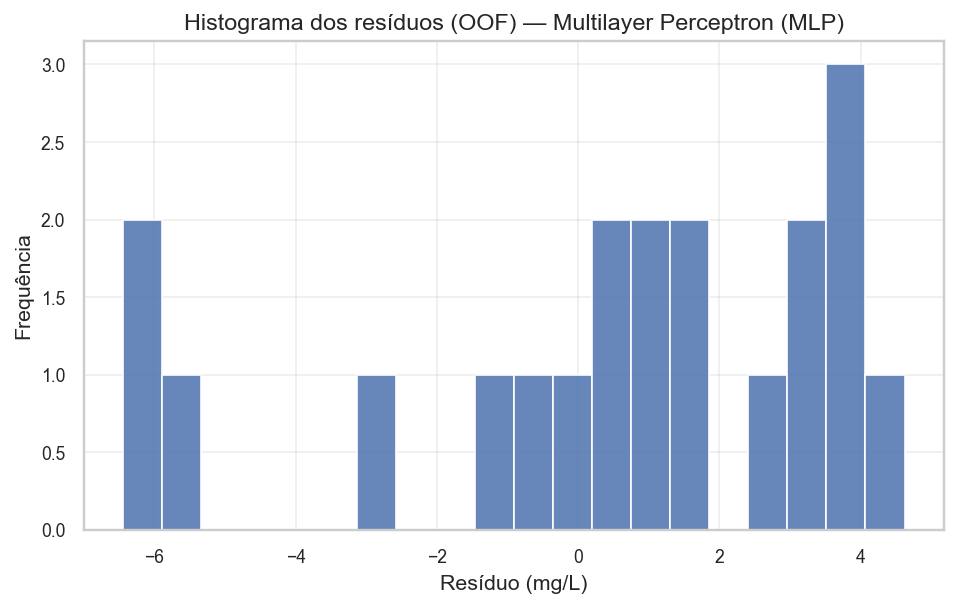

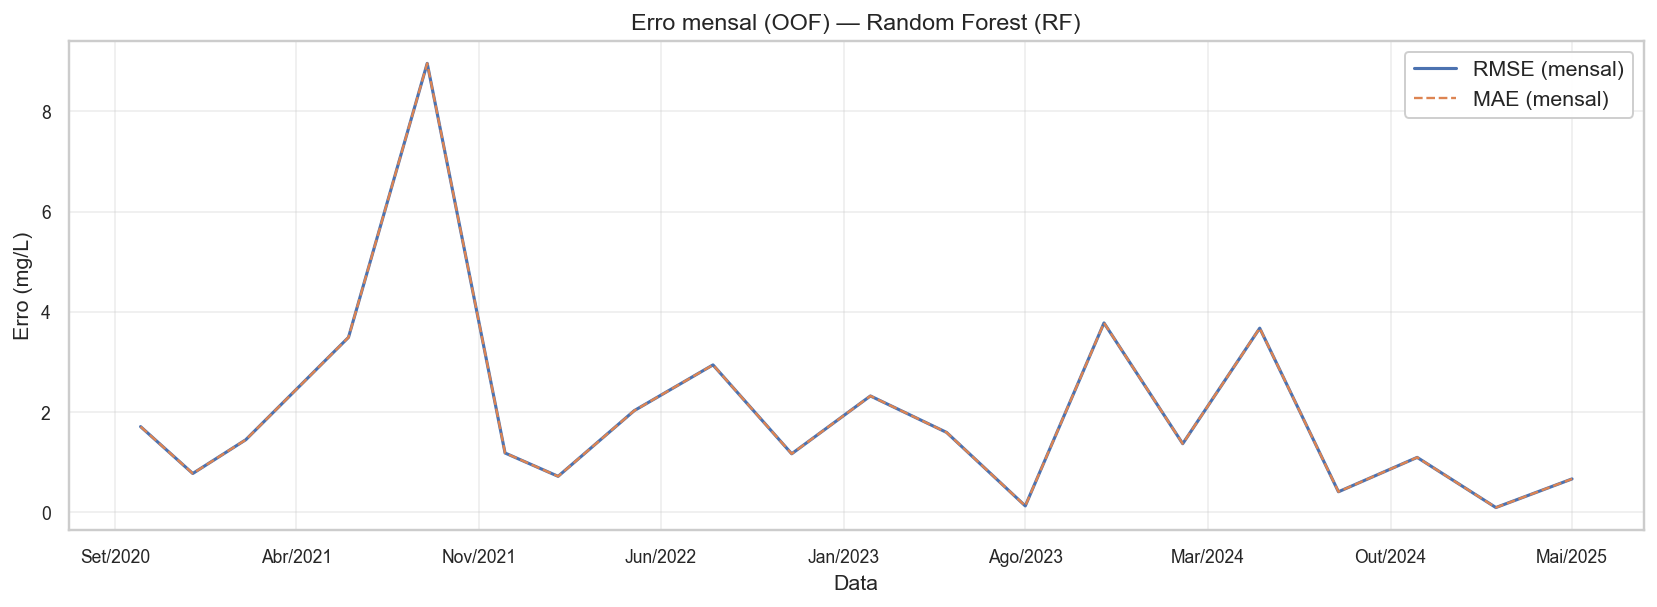

[INFO] Backtesting dinâmico – Janela 1: treina até 2023-02-07 e prevê de 2023-02-08 a 2025-05-06


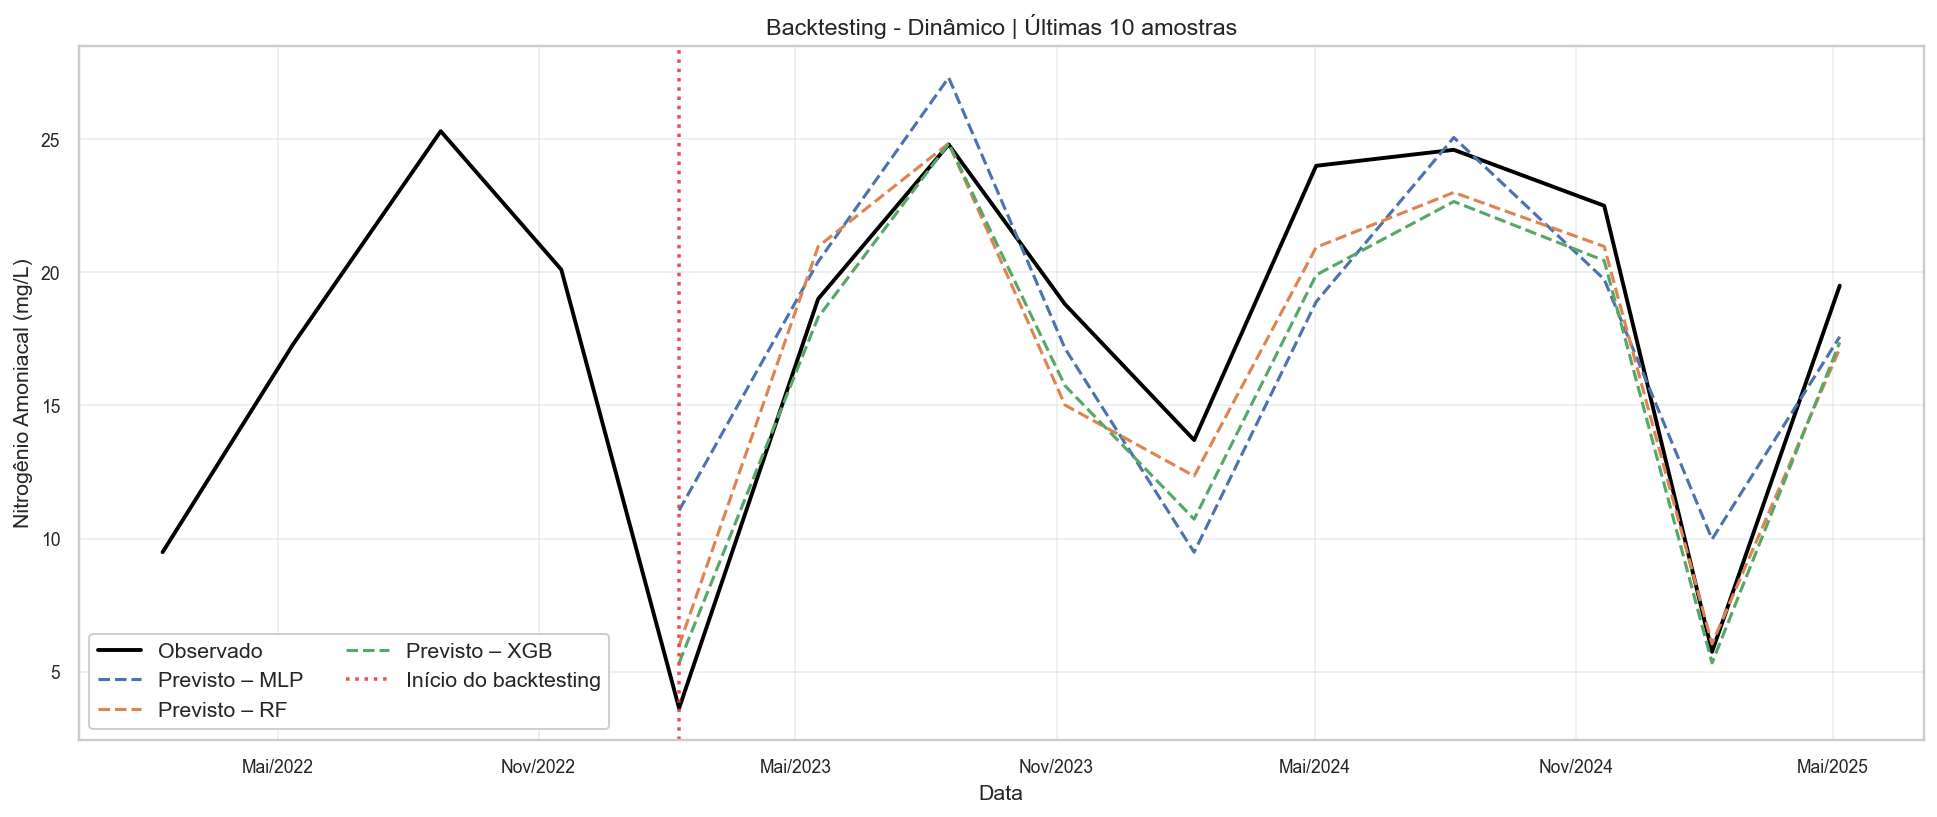

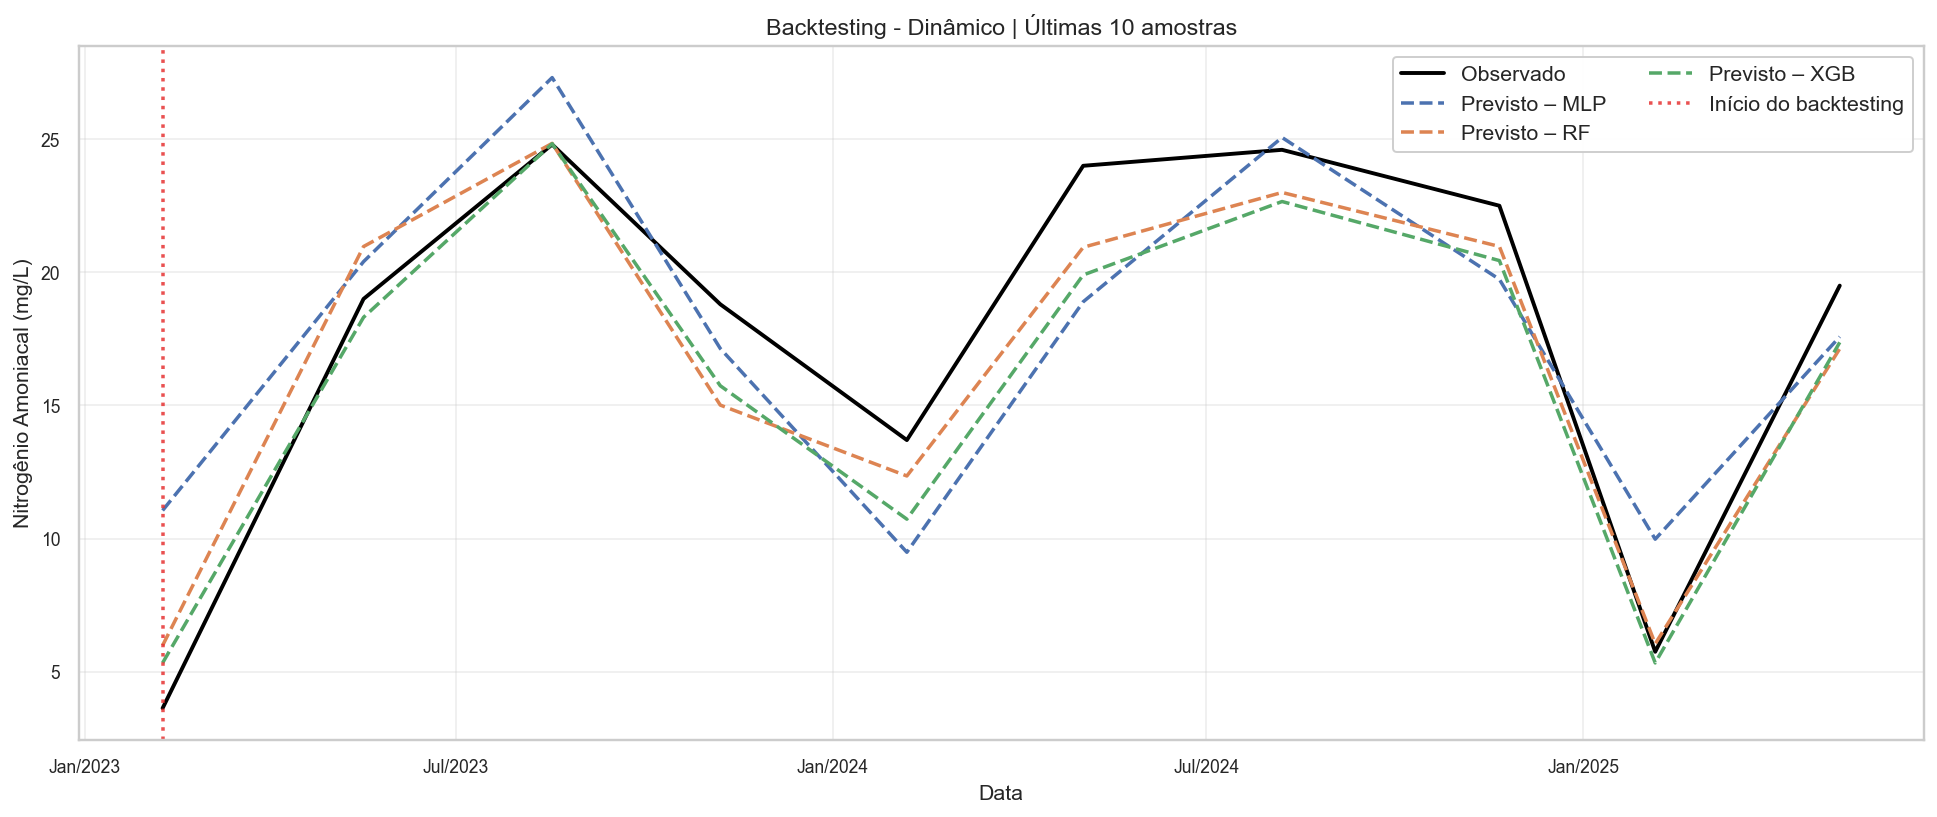

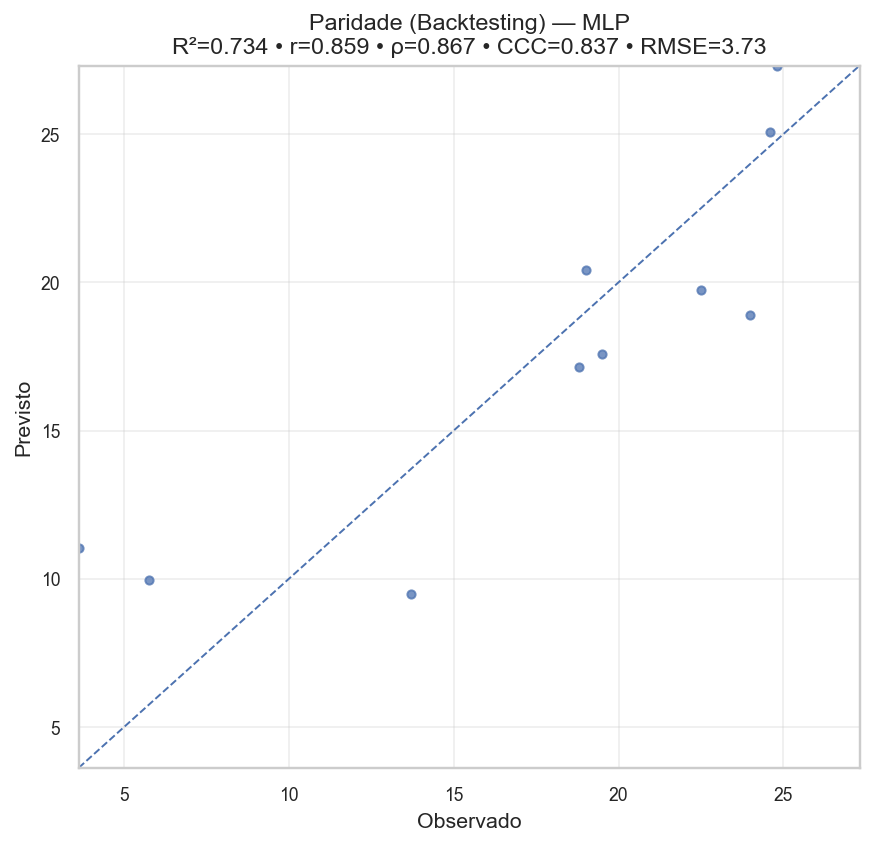

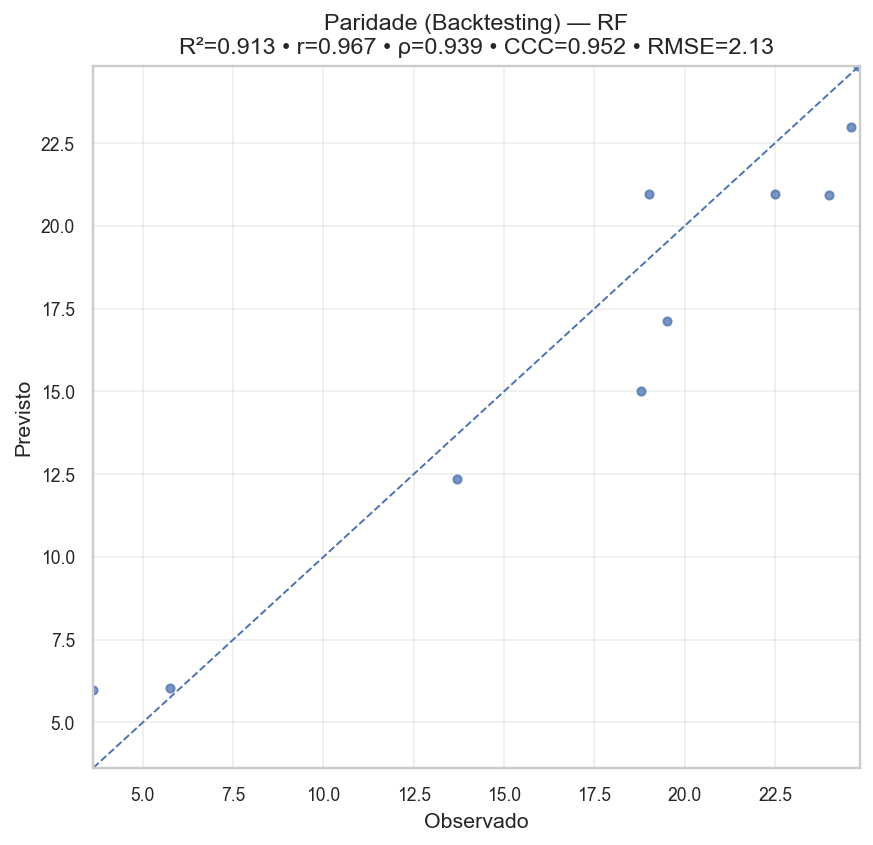

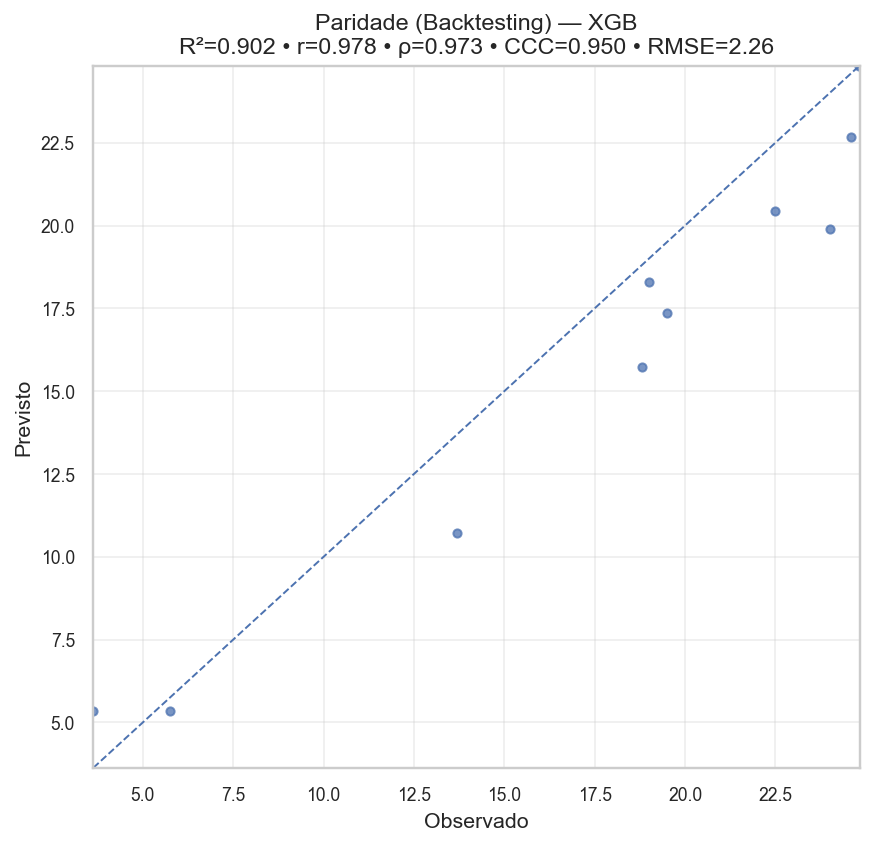


=== MÉTRICAS BACKTESTING (dinâmico – últimos pontos) ===
   Janela      Inicio         Fim Modelo        R2         R   R_spear  \
0       1  2023-02-08  2025-05-06    MLP  0.733704  0.858959  0.866667   
1       1  2023-02-08  2025-05-06     RF  0.912996  0.967073  0.939394   
2       1  2023-02-08  2025-05-06    XGB  0.902423  0.977697  0.972649   

        CCC      RMSE       MAE       MAPE        MSE  
0  0.836847  3.734085  3.169589  38.049296  13.943391  
1  0.952477  2.134383  1.835985  14.884852   4.555593  
2  0.949614  2.260348  1.910182  14.091723   5.109175  


In [ ]:
# -*- coding: utf-8 -*-
# TCC – Previsão de Nitrogênio Amoniacal
# RF / XGB (opcional) / MLP + pipeline sem vazamento
# Gráficos desde DATA_INICIO_PLOT + Pearson + Spearman + Backtesting dinâmico (últimos N pontos)

import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# =========================
# XGBoost (opcional)
# =========================
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    warnings.warn("xgboost não encontrado. O modelo XGB será pulado.")

# =========================
# PARÂMETROS
# =========================
CAMINHO_ARQUIVO = r'C:\Users\CAMINHO DOS SEUS DADOS AQUI.XLSX'
ABA = 'Planilha1'
TARGET_PARAM = 'Nitrogênio Amoniacal'

ANO_MINIMO = 2019
DATA_INICIO_PLOT = '2019-01-01'
N_SPLITS = 5
TOP_K = 5
ESTACAO_DUMMIES = True

# Método de correlação para o seletor de features: 'pearson' ou 'spearman'
CORR_SELECTOR_METHOD = 'spearman'

# Backtesting dinâmico
BACKTEST_POINTS = 10
BACKTEST_PLOT_START = '2022-01-01'  # força exibição do backtesting desde 2022 quando possível

SAIDA_DIR = 'resultados_tcc'
FIG_DIR = os.path.join(SAIDA_DIR, 'figuras')
os.makedirs(FIG_DIR, exist_ok=True)

# Mapeamento de nomes completos dos modelos
MODEL_NAME_MAP = {
    'MLP': 'Multilayer Perceptron (MLP)',
    'RF':  'Random Forest (RF)',
}
if HAS_XGB:
    MODEL_NAME_MAP['XGB'] = 'XGBoost (XGB)'

# =========================
# ESTILO DE FIGURAS
# =========================
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.frameon": True,
    "legend.framealpha": 0.95,
    "legend.facecolor": "white",
})

# =========================
# Eixo de datas em pt-BR
# =========================
PT_BR_MONTHS = ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"]
def _format_time_axis_ptbr(ax, month_interval=3, auto=True, max_ticks=8):
    if auto:
        xmin, xmax = ax.get_xlim()
        dmin = mdates.num2date(xmin)
        dmax = mdates.num2date(xmax)
        months = max(1, (dmax.year - dmin.year) * 12 + (dmax.month - dmin.month) + 1)
        interval = max(1, int(np.ceil(months / max_ticks)))
    else:
        interval = month_interval
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    def _fmt(x, pos=None):
        d = mdates.num2date(x)
        return f"{PT_BR_MONTHS[d.month-1]}/{d.year}"
    ax.xaxis.set_major_formatter(FuncFormatter(_fmt))

# =========================
# FUNÇÕES AUXILIARES
# =========================
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return np.mean(np.abs(y_true - y_pred) / denom) * 100.0

def _pearson_r(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size < 2:
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])

def _spearman_rho(a, b):
    """Correlação de Spearman sem depender do scipy.
    Calcula Pearson sobre os ranks (média para empates)."""
    a = pd.Series(np.asarray(a, dtype=float))
    b = pd.Series(np.asarray(b, dtype=float))
    if a.size < 2:
        return np.nan
    ra = a.rank(method='average')
    rb = b.rank(method='average')
    return float(np.corrcoef(ra, rb)[0, 1])

def _ccc(y_true, y_pred):
    """Concordance Correlation Coefficient (Lin, 1989)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.size < 2:
        return np.nan
    mu_x, mu_y = np.mean(y_true), np.mean(y_pred)
    var_x, var_y = np.var(y_true, ddof=1), np.var(y_pred, ddof=1)
    r = _pearson_r(y_true, y_pred)
    denom = var_x + var_y + (mu_x - mu_y)**2
    if denom == 0:
        return np.nan
    return float((2 * r * np.sqrt(var_x) * np.sqrt(var_y)) / denom)

def forward_fill_train_test(X_train, X_test):
    X_train = X_train.sort_index()
    X_test = X_test.sort_index()
    X_train_ff = X_train.ffill()
    med = X_train_ff.median(numeric_only=True)
    X_train_ff = X_train_ff.fillna(med)
    if len(X_train_ff) > 0:
        seed = X_train_ff.tail(1)
        X_test_ff = pd.concat([seed, X_test]).ffill().iloc[1:]
    else:
        X_test_ff = X_test.copy()
    X_test_ff = X_test_ff.fillna(med)
    na_cols = list(set(
        X_train_ff.columns[X_train_ff.isna().any()].tolist() +
        X_test_ff.columns[X_test_ff.isna().any()].tolist()
    ))
    if na_cols:
        X_train_ff = X_train_ff.drop(columns=na_cols, errors='ignore')
        X_test_ff  = X_test_ff.drop(columns=na_cols, errors='ignore')
    return X_train_ff, X_test_ff

class RobustClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lim_std=3.0): self.lim_std = lim_std
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("RobustClipper requer DataFrame.")
        self.means_ = X.mean()
        stds = X.std().replace(0, 1e-9)
        self.lower_ = self.means_ - self.lim_std * stds
        self.upper_ = self.means_ + self.lim_std * stds
        return self
    def transform(self, X):
        return X.clip(self.lower_, self.upper_, axis=1)

class CorrKSelector(BaseEstimator, TransformerMixin):
    def __init__(self, base_cols, dummy_cols, k=5, method='pearson'):
        self.base_cols = base_cols; self.dummy_cols = dummy_cols; self.k = k; self.method = method
    def fit(self, X, y):
        Xb = X[[c for c in self.base_cols if c in X.columns]].copy()
        y_arr = np.asarray(y, dtype=float)
        y_series = pd.Series(y_arr)
        corrs = {}
        for c in Xb.columns:
            x = pd.Series(np.asarray(Xb[c], dtype=float))
            if x.std(ddof=0) < 1e-12:
                corrs[c] = 0.0
            else:
                if self.method == 'spearman':
                    corrs[c] = _spearman_rho(x, y_series)
                else:
                    corrs[c] = _pearson_r(x, y_series)
        s = pd.Series(corrs).abs().sort_values(ascending=False)
        self.selected_base_ = s.head(self.k).index.tolist()
        kept_dummies = [c for c in self.dummy_cols if c in X.columns]
        self.out_cols_ = self.selected_base_ + kept_dummies
        return self
    def transform(self, X):
        cols = [c for c in self.out_cols_ if c in X.columns]
        return X[cols]

def montar_base(caminho, aba, alvo, ano_min=2019, usar_dummies=True):
    df = pd.read_excel(caminho, sheet_name=aba)
    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True, errors='coerce')
    df = df.dropna(subset=['Data', 'Parametro', 'Valor'])
    df['Valor'] = df['Valor'].astype(str).str.replace(',', '.', regex=False).astype(float)
    df = df[df['Data'].dt.year >= ano_min]
    wide = df.pivot_table(index='Data', columns='Parametro', values='Valor',
                          aggfunc='mean').sort_index()
    if usar_dummies:
        wide['Mes'] = wide.index.month
        wide['Estacao'] = wide.index.month % 12 // 3 + 1
        wide = pd.get_dummies(wide, columns=['Mes', 'Estacao'], drop_first=True)
    if alvo not in wide.columns:
        raise ValueError(f"O parâmetro alvo '{alvo}' não está presente após o pivot.")
    wide = wide.dropna(subset=[alvo])
    y = wide[alvo].copy()
    X = wide.drop(columns=[alvo]).copy()
    dummy_cols = [c for c in X.columns if c.startswith('Mes_') or c.startswith('Estacao_')]
    base_cols = [c for c in X.columns if c not in dummy_cols]
    return X, y, base_cols, dummy_cols

def avaliar_modelo(y_true, y_pred):
    y_true = pd.Series(y_true).astype(float)
    y_pred = pd.Series(y_pred).astype(float)
    common = y_true.index.intersection(y_pred.index)
    y_true = y_true.loc[common]
    y_pred = y_pred.loc[common]
    m = y_true.notna() & y_pred.notna()
    y_true = y_true[m].to_numpy()
    y_pred = y_pred[m].to_numpy()
    if y_true.size == 0:
        return dict(MSE=np.nan, RMSE=np.nan, MAE=np.nan, R2=np.nan, MAPE=np.nan, R=np.nan, R_spear=np.nan, CCC=np.nan)
    mse = mean_squared_error(y_true, y_pred)
    return dict(
        MSE=mse,
        RMSE=np.sqrt(mse),
        MAE=mean_absolute_error(y_true, y_pred),
        R2=r2_score(y_true, y_pred),
        MAPE=mape_safe(y_true, y_pred),
        R=_pearson_r(y_true, y_pred),
        R_spear=_spearman_rho(y_true, y_pred),
        CCC=_ccc(y_true, y_pred)
    )

# =========================
# PREPARAÇÃO
# =========================
X_all, y_all, base_cols_all, dummy_cols_all = montar_base(
    CAMINHO_ARQUIVO, ABA, TARGET_PARAM, ano_min=ANO_MINIMO, usar_dummies=ESTACAO_DUMMIES
)

# Logs informativos
data_min = pd.to_datetime(y_all.index.min()).date() if len(y_all) else None
data_max = pd.to_datetime(y_all.index.max()).date() if len(y_all) else None
print(f"[INFO] Dados (após filtro ANO_MINIMO={ANO_MINIMO} e alvo não nulo): {data_min} a {data_max}")
print(f"[INFO] CV temporal (OOF): treina sequencialmente desde {data_min}")
print(f"[INFO] Gráficos gerais: exibidos desde {pd.to_datetime(DATA_INICIO_PLOT).date()}")
print(f"[INFO] Backtesting (gráficos): desde {pd.to_datetime(BACKTEST_PLOT_START).date()} (ou 12 meses antes do início, o que for mais recente)")

# =========================
# CORRELAÇÕES (Pearson e Spearman) – Top-K + "escadinha" pastel (sem linhas)
# =========================
from matplotlib.colors import ListedColormap
import numpy.ma as ma

def _pastelize_cmap(base_cmap='RdBu_r', mix_with=(1,1,1), factor=0.25):
    """
    Deixa a paleta mais 'pastel' misturando com branco (ou outra cor clara).
    factor em [0,1]: 0 = original ; 1 = completamente 'mix_with'
    """
    cmap = plt.get_cmap(base_cmap, 256)
    colors = cmap(np.linspace(0,1,256))
    mix = np.array(list(mix_with) + [1.0])
    colors = (1-factor)*colors + factor*mix
    return ListedColormap(colors)

PASTEL_CMAP = _pastelize_cmap('RdBu_r', factor=0.25)  # vermelho positivo; azul negativo, suavizados

def _tri_corr_plot(df_vars, target_col, method='pearson', top_m=8,
                   title='Correlação', fname='tri_corr.png'):
    """
    - Seleciona top_m variáveis (por |corr| com o alvo), exclui o alvo da seleção,
      e monta uma matriz (top_m + alvo) ordenada por |corr| (alvo por último).
    - Plota heatmap triangular (lower) com paleta pastel e anotações.
    - Sem linhas de grade.
    """
    # Calcula correlações
    corr_full = df_vars.corr(numeric_only=True, method=method)
    if target_col not in corr_full.columns:
        raise ValueError(f"Alvo '{target_col}' não presente na base de correlações.")

    serie_corr_target = corr_full[target_col].drop(index=target_col).abs().sort_values(ascending=False)
    sel = list(serie_corr_target.head(top_m).index)

    cols_order = sel + [target_col]
    C = df_vars[cols_order].corr(numeric_only=True, method=method).values

    # Máscara triângulo superior
    mask = np.triu(np.ones_like(C, dtype=bool), k=1)
    C_masked = ma.array(C, mask=mask)

    # Plot
    fig, ax = plt.subplots(figsize=(8.8, 7.2))
    im = ax.imshow(C_masked, cmap=PASTEL_CMAP, vmin=-1, vmax=1)

    # Eixos/rotulagem
    ax.set_xticks(range(len(cols_order)))
    ax.set_yticks(range(len(cols_order)))
    ax.set_xticklabels(cols_order, rotation=45, ha='right')
    ax.set_yticklabels(cols_order)
    ax.set_title(title)
    ax.grid(False)  # <<< garante sem grade no heatmap

    # Anotações (apenas triângulo inferior)
    n = len(cols_order)
    for i in range(n):
        for j in range(n):
            if j > i:
                continue
            val = C[i, j]
            txt = f'{val:.2f}'
            ax.text(j, i, txt, ha='center', va='center', fontsize=8,
                    color='#111' if abs(val) < 0.6 else 'white')

    # Barra de cores
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlação' + (' (r)' if method=='pearson' else ' (ρ)'))

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, fname), bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, fname.replace('.png', '.svg')), bbox_inches='tight')
    plt.show()

# -------------------------
# Base de correlação (numéricas)
# -------------------------
df_corr_base = pd.concat([X_all[base_cols_all], y_all.rename(TARGET_PARAM)], axis=1).dropna()

# === Top-K barras (Pearson)
top_k_corr = 6
serie_corr_p = df_corr_base.corr(numeric_only=True, method='pearson')[TARGET_PARAM].drop(TARGET_PARAM)
serie_corr_p_abs = serie_corr_p.abs().sort_values(ascending=False)
top_names_p = serie_corr_p_abs.head(top_k_corr).index
top_vals_p = serie_corr_p_abs.head(top_k_corr).values

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(list(reversed(top_names_p)), list(reversed(top_vals_p)))
ax.set_xlabel('|Correlação de Pearson| com o alvo')
ax.set_title('Correlação (|r|) com Nitrogênio Amoniacal — Pearson')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, '01_pearson_top6_bar.png'), bbox_inches='tight')
plt.savefig(os.path.join(FIG_DIR, '01_pearson_top6_bar.svg'), bbox_inches='tight')
plt.show()

# === Triangular Pearson (sem linhas)
_tri_corr_plot(
    df_vars=df_corr_base,
    target_col=TARGET_PARAM,
    method='pearson',
    top_m=8,
    title='Correlação de Pearson — Nitrogênio Amoniacal',
    fname='02_pearson_triangulo_pastel.png'
)

# === Top-K barras (Spearman)
serie_corr_s = df_corr_base.corr(numeric_only=True, method='spearman')[TARGET_PARAM].drop(TARGET_PARAM)
serie_corr_s_abs = serie_corr_s.abs().sort_values(ascending=False)
top_names_s = serie_corr_s_abs.head(top_k_corr).index
top_vals_s = serie_corr_s_abs.head(top_k_corr).values

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(list(reversed(top_names_s)), list(reversed(top_vals_s)))
ax.set_xlabel('|Correlação de Spearman|')
ax.set_title('Correlação (|ρ|) com Nitrogênio Amoniacal — Spearman')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, '03_spearman_top6_bar.png'), bbox_inches='tight')
plt.savefig(os.path.join(FIG_DIR, '03_spearman_top6_bar.svg'), bbox_inches='tight')
plt.show()

# === Triangular Spearman (sem linhas)
_tri_corr_plot(
    df_vars=df_corr_base,
    target_col=TARGET_PARAM,
    method='spearman',
    top_m=8,
    title='Correlação de Spearman',
    fname='04_spearman_triangulo_pastel.png'
)

# =========================
# MODELOS
# =========================
modelos = {
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42),
    'RF': RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
}
if HAS_XGB:
    modelos['XGB'] = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective='reg:squarederror', random_state=42, n_jobs=-1
    )

# =========================
# CV TEMPORAL (OOF)
# =========================
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
metricas_por_modelo = {nome: [] for nome in modelos}
oof_preds_por_modelo = {nome: pd.Series(dtype=float) for nome in modelos}
oof_truth = pd.Series(dtype=float)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all), start=1):
    X_train_raw = X_all.iloc[train_idx].copy()
    X_test_raw  = X_all.iloc[test_idx].copy()
    y_train = y_all.iloc[train_idx].copy()
    y_test  = y_all.iloc[test_idx].copy()

    if y_test.isna().any():
        y_test = y_test.dropna()
        X_test_raw = X_test_raw.loc[y_test.index]
    if len(y_test) < 2:
        continue  # dobra muito pequena → pula

    X_train_filled, X_test_filled = forward_fill_train_test(X_train_raw, X_test_raw)

    clipper = RobustClipper(lim_std=3.0).fit(X_train_filled)
    X_train_clip = clipper.transform(X_train_filled)
    X_test_clip  = clipper.transform(X_test_filled)

    selector = CorrKSelector(
        base_cols=[c for c in base_cols_all if c in X_train_clip.columns],
        dummy_cols=[c for c in dummy_cols_all if c in X_train_clip.columns],
        k=TOP_K,
        method=CORR_SELECTOR_METHOD
    ).fit(X_train_clip, y_train)
    X_train_sel = selector.transform(X_train_clip)
    X_test_sel  = selector.transform(X_test_clip)

    scaler = StandardScaler().fit(X_train_sel)
    X_train_scaled = scaler.transform(X_train_sel)
    X_test_scaled  = scaler.transform(X_test_sel)

    for nome, modelo in modelos.items():
        mdl = clone(modelo)
        mdl.fit(X_train_scaled, y_train)
        if len(X_test_sel) == 0 or len(y_test) == 0:
            continue
        y_pred = mdl.predict(X_test_scaled)
        met_fold = avaliar_modelo(y_test, y_pred)
        if not np.isnan(met_fold['R2']):
            metricas_por_modelo[nome].append(met_fold)
        idx_test = X_test_sel.index
        oof_preds_por_modelo[nome] = pd.concat(
            [oof_preds_por_modelo[nome], pd.Series(y_pred, index=idx_test)]
        )

    oof_truth = pd.concat([oof_truth, pd.Series(y_test.values, index=y_test.index)])

# =========================
# AGREGAÇÃO (média±std e OOF)
# =========================
linhas = []
for nome in modelos.keys():
    lista = metricas_por_modelo.get(nome, [])
    def _avg(key):
        return np.mean([d[key] for d in lista]) if lista else np.nan
    def _std(key):
        return np.std([d[key] for d in lista]) if lista else np.nan

    mse_mean, mse_std = _avg('MSE'), _std('MSE')
    rmse_mean, rmse_std = _avg('RMSE'), _std('RMSE')
    mae_mean, mae_std = _avg('MAE'), _std('MAE')
    r2_mean, r2_std = _avg('R2'), _std('R2')
    mape_mean, mape_std = _avg('MAPE'), _std('MAPE')
    r_mean, r_std = _avg('R'), _std('R')
    rs_mean, rs_std = _avg('R_spear'), _std('R_spear')
    ccc_mean, ccc_std = _avg('CCC'), _std('CCC')

    y_pred_oof = oof_preds_por_modelo[nome].sort_index()
    y_true_oof = oof_truth.loc[y_pred_oof.index].sort_index()
    met_oof = avaliar_modelo(y_true_oof, y_pred_oof)

    topk_last = ', '.join(getattr(selector, 'selected_base_', [])) if 'selector' in locals() else ''

    linhas.append({
        'Modelo': nome,
        'R2_mean': r2_mean, 'R2_std': r2_std, 'R2_OOF': met_oof['R2'],
        'RMSE_mean': rmse_mean, 'RMSE_std': rmse_std, 'RMSE_OOF': met_oof['RMSE'],
        'MAE_mean': mae_mean, 'MAE_std': mae_std, 'MAE_OOF': met_oof['MAE'],
        'MSE_mean': mse_mean, 'MSE_std': mse_std, 'MSE_OOF': met_oof['MSE'],
        'MAPE_mean(%)': mape_mean, 'MAPE_std(%)': mape_std, 'MAPE_OOF(%)': met_oof['MAPE'],
        'R_mean(Pearson)': r_mean, 'R_std(Pearson)': r_std, 'R_OOF(Pearson)': met_oof['R'],
        'R_mean(Spearman)': rs_mean, 'R_std(Spearman)': rs_std, 'R_OOF(Spearman)': met_oof['R_spear'],
        'CCC_mean': ccc_mean, 'CCC_std': ccc_std, 'CCC_OOF': met_oof['CCC'],
        'TopK_features(último_fold)': topk_last,
        'Seletor_corr': CORR_SELECTOR_METHOD
    })

df_metricas = pd.DataFrame(linhas)

# Ordenação robusta
sort_key = None
if 'RMSE_mean' in df_metricas.columns and not df_metricas['RMSE_mean'].isna().all():
    sort_key = 'RMSE_mean'
elif 'RMSE_OOF' in df_metricas.columns:
    sort_key = 'RMSE_OOF'
if sort_key:
    df_metricas = df_metricas.sort_values(by=sort_key)

os.makedirs(SAIDA_DIR, exist_ok=True)
df_metricas.to_csv(os.path.join(SAIDA_DIR, 'metricas_modelos.csv'), index=False, sep=';')
try:
    df_fmt = df_metricas.copy()
    for c in df_fmt.columns:
        if c not in ['Modelo', 'TopK_features(último_fold)', 'Seletor_corr']:
            df_fmt[c] = pd.to_numeric(df_fmt[c], errors='ignore')
            if pd.api.types.is_float_dtype(df_fmt[c]):
                df_fmt[c] = df_fmt[c].round(4)
    df_fmt.to_excel(os.path.join(SAIDA_DIR, 'metricas_modelos.xlsx'), index=False)
except Exception:
    pass

print("\n=== MÉTRICAS (média ± desvio; e OOF) ===")
cols_print = [
    'Modelo','Seletor_corr','R2_mean','R2_std','R2_OOF',
    'RMSE_mean','RMSE_std','RMSE_OOF',
    'MAE_mean','MAE_std','MAE_OOF',
    'MAPE_mean(%)','MAPE_std(%)','MAPE_OOF(%)',
    'R_mean(Pearson)','R_std(Pearson)','R_OOF(Pearson)',
    'R_mean(Spearman)','R_std(Spearman)','R_OOF(Spearman)',
    'CCC_mean','CCC_std','CCC_OOF'
]
print(df_metricas[cols_print])

# =========================
# GRÁFICOS 5,6,7 – OOF (Observado × Previsto)
# =========================
data_corte = pd.to_datetime(DATA_INICIO_PLOT)

def _plot_model_series(nome_modelo, serie_pred):
    if serie_pred.empty:
        return
    dfp = pd.DataFrame({'Previsto': serie_pred}).sort_index()
    y_alinh = oof_truth.loc[dfp.index].rename('Observado')
    dfp = pd.concat([y_alinh, dfp], axis=1).dropna()
    dfp = dfp[dfp.index >= data_corte]
    if dfp.empty:
        return
    full_name = MODEL_NAME_MAP.get(nome_modelo, nome_modelo)

    # Título simplificado (sem período/folds)
    titulo = f'Validação Cruzada Temporal — Observado × Previsto — {full_name}'

    fig, ax = plt.subplots(figsize=(14,6))
    # Observado PRETO
    ax.plot(dfp.index, dfp['Observado'], label=f'Observado ({TARGET_PARAM})', linewidth=2, color='black')
    ax.plot(dfp.index, dfp['Previsto'], label=f'Previsto ({full_name})', linewidth=1.8, linestyle='--')
    ax.set_title(titulo)
    ax.set_xlabel('Data'); ax.set_ylabel(f'{TARGET_PARAM} (mg/L)')
    _format_time_axis_ptbr(ax, auto=True, max_ticks=8)
    ax.legend(loc='best'); plt.tight_layout()
    fname = f"0{ {'MLP':5,'RF':6,'XGB':7}.get(nome_modelo, 99) }_{nome_modelo}_observado_vs_previsto_OOF.png"
    fbase = os.path.join(FIG_DIR, fname)
    plt.savefig(fbase, bbox_inches='tight')
    plt.savefig(fbase.replace('.png','.svg'), bbox_inches='tight')
    plt.show()

for nome, preds in oof_preds_por_modelo.items():
    _plot_model_series(nome, preds)

# =========================
# GRÁFICOS 8 e 9 – Comparativos (OOF)
# =========================
if not df_metricas.empty:
    # 8) R² (OOF)
    df_plot = df_metricas.sort_values('R2_OOF', ascending=False).copy()
    df_plot['Modelo_full'] = df_plot['Modelo'].map(MODEL_NAME_MAP).fillna(df_plot['Modelo'])
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(df_plot['Modelo_full'], df_plot['R2_OOF'])
    ax.set_title(f'Validação Cruzada Temporal (OOF) — Comparativo de R² — {TARGET_PARAM}')
    ax.set_ylabel('R² (OOF)')
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, '08_comparativo_R2_OOF.png'), bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, '08_comparativo_R2_OOF.svg'), bbox_inches='tight')
    plt.show()

    # 9) RMSE (OOF)
    df_plot2 = df_metricas.sort_values('RMSE_OOF', ascending=True).copy()
    df_plot2['Modelo_full'] = df_plot2['Modelo'].map(MODEL_NAME_MAP).fillna(df_plot2['Modelo'])
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(df_plot2['Modelo_full'], df_plot2['RMSE_OOF'])
    ax.set_title(f'Validação Cruzada Temporal (OOF) — Comparativo de RMSE — {TARGET_PARAM}')
    ax.set_ylabel('RMSE (mg/L)')
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, '09_comparativo_RMSE_OOF.png'), bbox_inches='tight')
    plt.savefig(os.path.join(FIG_DIR, '09_comparativo_RMSE_OOF.svg'), bbox_inches='tight')
    plt.show()

# =========================
# 10) OOF — Observado × Previsto — Comparação de Modelos
# =========================
preds_dict = {}
for nome, preds in oof_preds_por_modelo.items():
    if not preds.empty:
        preds_dict[nome] = preds

if preds_dict:
    base = pd.DataFrame({'Observado': oof_truth}).sort_index()
    for nome in df_metricas['Modelo']:
        if nome in preds_dict:
            base[nome] = preds_dict[nome]
    base = base.dropna()
    base = base[base.index >= data_corte]
    if not base.empty:
        # Título simplificado (sem período/folds)
        titulo = 'Validação Cruzada Temporal — Observado × Previsto — Comparação de Modelos'

        fig, ax = plt.subplots(figsize=(14,6))
        # Observado PRETO
        ax.plot(base.index, base['Observado'], label='Observado', linewidth=2, color='black')
        for nome in df_metricas['Modelo']:
            if nome in base.columns:
                ax.plot(base.index, base[nome], label=MODEL_NAME_MAP.get(nome, nome),
                        linewidth=1.6, linestyle='--')
        ax.set_title(titulo)
        ax.set_xlabel('Data'); ax.set_ylabel(f'{TARGET_PARAM} (mg/L)')
        _format_time_axis_ptbr(ax, auto=True, max_ticks=8)
        ax.legend(loc='best', ncol=2); plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, '10_OOF_comparacao_modelos_observado_vs_previsto.png'), bbox_inches='tight')
        plt.savefig(os.path.join(FIG_DIR, '10_OOF_comparacao_modelos_observado_vs_previsto.svg'), bbox_inches='tight')
        plt.show()

# =========================
# GRÁFICOS EXTRAS – Paridade (OOF) / Resíduos / Erro Mensal
# =========================
if preds_dict:
    for nome in df_metricas['Modelo']:
        if nome not in preds_dict:
            continue
        full_name = MODEL_NAME_MAP.get(nome, nome)
        dfp = pd.DataFrame({'Observado': oof_truth, 'Previsto': preds_dict[nome]}).dropna()
        if dfp.empty:
            continue

        r2 = r2_score(dfp['Observado'], dfp['Previsto'])
        rmse = mean_squared_error(dfp['Observado'], dfp['Previsto'])**0.5
        r = _pearson_r(dfp['Observado'].to_numpy(), dfp['Previsto'].to_numpy())
        rs = _spearman_rho(dfp['Observado'].to_numpy(), dfp['Previsto'].to_numpy())
        ccc = _ccc(dfp['Observado'].to_numpy(), dfp['Previsto'].to_numpy())

        fig, ax = plt.subplots(figsize=(6.5,6.5))
        ax.scatter(dfp['Observado'], dfp['Previsto'], s=15, alpha=0.7)
        lims = [min(dfp.min().min(), dfp.max().max()), max(dfp.min().min(), dfp.max().max())]
        ax.plot(lims, lims, linestyle='--', linewidth=1)
        ax.set_xlim(lims); ax.set_ylim(lims)
        ax.set_xlabel('Observado'); ax.set_ylabel('Previsto')
        ax.set_title(f'Paridade (OOF) — {full_name} | R²={r2:.3f} • r={r:.3f} • ρ={rs:.3f} • CCC={ccc:.3f} • RMSE={rmse:.2f}')
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f'paridade_OOF_{nome}.png'), bbox_inches='tight')
        plt.savefig(os.path.join(FIG_DIR, f'paridade_OOF_{nome}.svg'), bbox_inches='tight')
        plt.show()

        dfres = dfp.copy()
        dfres['Residuo'] = dfres['Observado'] - dfres['Previsto']
        dfres = dfres[dfres.index >= data_corte]
        if not dfres.empty:
            fig, ax = plt.subplots(figsize=(14,4.5))
            ax.plot(dfres.index, dfres['Residuo'], linewidth=1.2)
            ax.axhline(0, linestyle='--', linewidth=1)
            _format_time_axis_ptbr(ax, auto=True, max_ticks=10)
            ax.set_title(f'Resíduos no tempo (OOF) — {full_name}')
            ax.set_xlabel('Data'); ax.set_ylabel('Resíduo (mg/L)')
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f'residuos_tempo_OOF_{nome}.png'), bbox_inches='tight')
            plt.savefig(os.path.join(FIG_DIR, f'residuos_tempo_OOF_{nome}.svg'), bbox_inches='tight')
            plt.show()

            fig, ax = plt.subplots(figsize=(7,4.5))
            ax.hist(dfres['Residuo'], bins=20, alpha=0.85)
            ax.set_title(f'Histograma dos resíduos (OOF) — {full_name}')
            ax.set_xlabel('Resíduo (mg/L)'); ax.set_ylabel('Frequência')
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f'residuos_hist_OOF_{nome}.png'), bbox_inches='tight')
            plt.savefig(os.path.join(FIG_DIR, f'residuos_hist_OOF_{nome}.svg'), bbox_inches='tight')
            plt.show()

    if not df_metricas.empty and preds_dict:
        best_name = df_metricas.sort_values('R2_OOF', ascending=False)['Modelo'].iloc[0]
        if best_name in preds_dict:
            full_best = MODEL_NAME_MAP.get(best_name, best_name)
            dfm = pd.DataFrame({'Observado': oof_truth, 'Prev': preds_dict[best_name]}).dropna()
            dfm = dfm[dfm.index >= data_corte]
            if not dfm.empty:
                dfm['abs_err'] = (dfm['Observado'] - dfm['Prev']).abs()
                dfm['sq_err']  = (dfm['Observado'] - dfm['Prev'])**2
                idx_month = dfm.index.to_period('M').to_timestamp()
                g = dfm.groupby(idx_month).agg(
                    RMSE=('sq_err', lambda s: np.sqrt(np.mean(s))),
                    MAE=('abs_err', 'mean')
                )
                fig, ax = plt.subplots(figsize=(12,4.5))
                ax.plot(g.index, g['RMSE'], label='RMSE (mensal)', linewidth=1.6)
                ax.plot(g.index, g['MAE'], label='MAE (mensal)', linewidth=1.2, linestyle='--')
                _format_time_axis_ptbr(ax, auto=True, max_ticks=10)
                ax.set_title(f'Erro mensal (OOF) — {full_best}')
                ax.set_xlabel('Data'); ax.set_ylabel('Erro (mg/L)')
                ax.legend(loc='best'); plt.tight_layout()
                plt.savefig(os.path.join(FIG_DIR, f'erro_mensal_OOF_{best_name}.png'), bbox_inches='tight')
                plt.savefig(os.path.join(FIG_DIR, f'erro_mensal_OOF_{best_name}.svg'), bbox_inches='tight')
                plt.show()

# =========================
# BACKTESTING – Dinâmico: últimos N pontos
# =========================

def _fit_predict_window(X_all, y_all, start, end, modelos, base_cols_all, dummy_cols_all):
    """Treina até (start - 1) e prevê no intervalo [start, end]."""
    X_all = X_all.sort_index(); y_all = y_all.sort_index()
    train_mask = (X_all.index < start)
    test_mask  = (X_all.index >= start) & (X_all.index <= end)
    X_tr_raw, X_te_raw = X_all.loc[train_mask].copy(), X_all.loc[test_mask].copy()
    y_tr, y_te = y_all.loc[train_mask].copy(), y_all.loc[test_mask].copy()

    if y_te.isna().any():
        y_te = y_te.dropna()
        X_te_raw = X_te_raw.loc[y_te.index]
    if len(X_tr_raw)==0 or len(X_te_raw)==0:
        return {}, y_te

    X_tr_ff, X_te_ff = forward_fill_train_test(X_tr_raw, X_te_raw)
    clipper = RobustClipper(3.0).fit(X_tr_ff)
    X_tr_clip = clipper.transform(X_tr_ff)
    X_te_clip = clipper.transform(X_te_ff)

    selector = CorrKSelector(
        base_cols=[c for c in base_cols_all if c in X_tr_clip.columns],
        dummy_cols=[c for c in dummy_cols_all if c in X_tr_clip.columns],
        k=TOP_K,
        method=CORR_SELECTOR_METHOD
    ).fit(X_tr_clip, y_tr)
    X_tr_sel = selector.transform(X_tr_clip)
    X_te_sel = selector.transform(X_te_clip)

    scaler = StandardScaler().fit(X_tr_sel)
    X_tr_scaled = scaler.transform(X_tr_sel)
    X_te_scaled  = scaler.transform(X_te_sel)

    preds = {}
    for nome, modelo in modelos.items():
        mdl = clone(modelo)
        mdl.fit(X_tr_scaled, y_tr)
        preds[nome] = pd.Series(mdl.predict(X_te_scaled), index=X_te_sel.index)
    return preds, y_te


def _build_backtest_window_last_points(idx, n_points=5):
    """Cria 1 janela dinâmica com os 'n_points' últimos timestamps disponíveis."""
    ts = pd.to_datetime(pd.Index(idx)).sort_values()
    ts_unique = pd.Index(ts).unique()
    if len(ts_unique) == 0:
        return []
    n = min(n_points, len(ts_unique))
    start = pd.Timestamp(ts_unique[-n])
    end   = pd.Timestamp(ts_unique[-1])
    titulo = f'Backtesting - Dinâmico | Últimas {n} amostras'
    return [(1, start, end, titulo)]

# Rodar backtesting
bt_windows_info = _build_backtest_window_last_points(X_all.index, n_points=BACKTEST_POINTS)

bt_rows = []
for (i, w_start, w_end, titulo_info) in bt_windows_info:
    dia_antes = (pd.to_datetime(w_start) - pd.Timedelta(days=1)).date()
    print(f"[INFO] Backtesting dinâmico – Janela {i}: treina até {dia_antes} e prevê de {w_start.date()} a {w_end.date()}")

    preds_dict_bt, y_true = _fit_predict_window(X_all, y_all, w_start, w_end,
                                             modelos, base_cols_all, dummy_cols_all)

    if preds_dict_bt and len(y_true) > 0:
        df_bt = pd.DataFrame({'Observado': y_true}).sort_index()
        for nome, s in preds_dict_bt.items():
            df_bt[nome] = s
        os.makedirs(SAIDA_DIR, exist_ok=True)
        df_bt.to_csv(os.path.join(SAIDA_DIR, f'backtest_{i}_predicoes.csv'), sep=';', index=True)

        for nome, s in preds_dict_bt.items():
            met = avaliar_modelo(y_true.loc[s.index], s)
            met.update({'Janela': i, 'Inicio': str(pd.to_datetime(w_start).date()),
                        'Fim': str(pd.to_datetime(w_end).date()), 'Modelo': nome})
            bt_rows.append(met)

        # Linha com contexto (Observado PRETO)
        ctx_start_12m = pd.to_datetime(w_start) - pd.DateOffset(months=12)
        backtest_plot_start = pd.to_datetime(BACKTEST_PLOT_START)
        plot_start_candidate = max(ctx_start_12m, backtest_plot_start)
        plot_start = plot_start_candidate if plot_start_candidate <= pd.to_datetime(w_end) else ctx_start_12m

        df_full = pd.DataFrame({'Observado': y_all}).sort_index()
        for nome, s in preds_dict_bt.items():
            df_full[nome] = s
        df_full = df_full[(df_full.index >= plot_start) & (df_full.index <= w_end)]

        if not df_full.empty:
            fig, ax = plt.subplots(figsize=(14,6))
            ax.plot(df_full.index, df_full['Observado'], label='Observado', linewidth=2, color='black')
            for nome in modelos.keys():
                if nome in df_full.columns:
                    ax.plot(df_full.index, df_full[nome], label=f'Previsto – {nome}',
                            linewidth=1.6, linestyle='--')
            ax.axvline(w_start, color=(0.9, 0.2, 0.2, 0.85), linestyle=':', linewidth=1.8, label='Início do backtesting')
            ax.set_title('Backtesting - Dinâmico | Últimas 10 amostras')
            ax.set_xlabel('Data'); ax.set_ylabel(f'{TARGET_PARAM} (mg/L)')
            _format_time_axis_ptbr(ax, auto=True, max_ticks=8)
            ax.legend(ncol=2, loc='best'); plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f'backtest_{i}_linha_contexto.png'), bbox_inches='tight')
            plt.savefig(os.path.join(FIG_DIR, f'backtest_{i}_linha_contexto.svg'), bbox_inches='tight')
            plt.show()

        # Zoom (Observado PRETO)
        df_zoom = df_full[(df_full.index >= w_start) & (df_full.index <= w_end)]
        if df_zoom.empty:
            df_zoom = pd.DataFrame({'Observado': y_all}).sort_index()
            for nome, s in preds_dict_bt.items():
                df_zoom[nome] = s
            df_zoom = df_zoom[(df_zoom.index >= w_start) & (df_zoom.index <= w_end)]

        if not df_zoom.empty:
            fig, ax = plt.subplots(figsize=(14,6))
            ax.plot(df_zoom.index, df_zoom['Observado'], label='Observado', linewidth=2, color='black')
            for nome in modelos.keys():
                if nome in df_zoom.columns:
                    ax.plot(df_zoom.index, df_zoom[nome], label=f'Previsto – {nome}',
                            linewidth=1.8, linestyle='--')
            ax.axvline(w_start, color=(0.9, 0.2, 0.2, 0.85), linestyle=':', linewidth=1.8, label='Início do backtesting')
            ax.set_title('Backtesting - Dinâmico | Últimas 10 amostras')
            ax.set_xlabel('Data'); ax.set_ylabel(f'{TARGET_PARAM} (mg/L)')
            _format_time_axis_ptbr(ax, auto=True, max_ticks=6)
            ax.legend(ncol=2, loc='best'); plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f'backtest_{i}_zoom_janela.png'), bbox_inches='tight')
            plt.savefig(os.path.join(FIG_DIR, f'backtest_{i}_zoom_janela.svg'), bbox_inches='tight')
            plt.show()

        # Paridade (Backtesting)
        for nome, s in preds_dict_bt.items():
            dfp = pd.DataFrame({'Observado': y_true.loc[s.index], 'Prev': s}).dropna()
            if dfp.empty:
                continue
            r2 = r2_score(dfp['Observado'], dfp['Prev'])
            rmse = mean_squared_error(dfp['Observado'], dfp['Prev'])**0.5
            r = _pearson_r(dfp['Observado'].to_numpy(), dfp['Prev'].to_numpy())
            rs = _spearman_rho(dfp['Observado'].to_numpy(), dfp['Prev'].to_numpy())
            ccc = _ccc(dfp['Observado'].to_numpy(), dfp['Prev'].to_numpy())
            fig, ax = plt.subplots(figsize=(6.4,6.2))
            ax.scatter(dfp['Observado'], dfp['Prev'], s=18, alpha=0.75)
            lims = [min(dfp.min().min(), dfp.max().max()),
                    max(dfp.min().min(), dfp.max().max())]
            ax.plot(lims, lims, linestyle='--', linewidth=1)
            ax.set_xlim(lims); ax.set_ylim(lims)
            ax.set_xlabel('Observado'); ax.set_ylabel('Previsto')
            ax.set_title(f'Paridade (Backtesting) — {nome}\nR²={r2:.3f} • r={r:.3f} • ρ={rs:.3f} • CCC={ccc:.3f} • RMSE={rmse:.2f}')
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f'backtest_{i}_paridade_{nome}.png'), bbox_inches='tight')
            plt.savefig(os.path.join(FIG_DIR, f'backtest_{i}_paridade_{nome}.svg'), bbox_inches='tight')
            plt.show()

# Consolidação do backtesting
if bt_rows:
    df_bt = pd.DataFrame(bt_rows)[[
        'Janela','Inicio','Fim','Modelo',
        'R2','R','R_spear','CCC','RMSE','MAE','MAPE','MSE'
    ]]
    df_bt = df_bt.sort_values(['Janela','Modelo'])
    df_bt.to_csv(os.path.join(SAIDA_DIR, 'backtesting_metricas.csv'), index=False, sep=';')
    try:
        df_bt.to_excel(os.path.join(SAIDA_DIR, 'backtesting_metricas.xlsx'), index=False)
    except Exception:
        pass
    print("\n=== MÉTRICAS BACKTESTING (dinâmico – últimos pontos) ===")
    print(df_bt)
